In [634]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
import warnings
warnings.filterwarnings('ignore')
import pprint
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score,accuracy_score,classification_report,make_scorer,fbeta_score
import scorecardpy as sc

# Represent data in standard decimal notation
pd.options.display.float_format = '{:.2f}'.format

### Load Application and Bureau Data

In [635]:
app_data = pd.read_csv('application_data.csv')
app_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [636]:
bureau_data = pd.read_csv("bureau_data.csv")
bureau_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


## Prepare Application Data & Bureau Data for Merge

### Application Data

#### Selecting Columns

In [637]:
selected_cols_application = ["SK_ID_CURR", 
                              "TARGET",
                              "FLAG_OWN_CAR",
                              "FLAG_OWN_REALTY",
                              "CNT_CHILDREN",
                              "AMT_INCOME_TOTAL",
                              "AMT_CREDIT",
                              "AMT_ANNUITY",
                              "AMT_GOODS_PRICE",
                              "NAME_INCOME_TYPE",
                              "NAME_EDUCATION_TYPE",
                              "NAME_FAMILY_STATUS",
                              "NAME_HOUSING_TYPE",
                              "REGION_POPULATION_RELATIVE",
                              "DAYS_BIRTH",
                              "DAYS_EMPLOYED",
                              "DAYS_REGISTRATION",
                              "DAYS_ID_PUBLISH",
                              "OWN_CAR_AGE",
                              "OCCUPATION_TYPE",
                              "CNT_FAM_MEMBERS",
                              "REGION_RATING_CLIENT",
                              "REGION_RATING_CLIENT_W_CITY",
                              "EXT_SOURCE_1",
                              "EXT_SOURCE_2",
                              "EXT_SOURCE_3",
                              "FLAG_DOCUMENT_3",
                              "OBS_30_CNT_SOCIAL_CIRCLE",
                              "DEF_30_CNT_SOCIAL_CIRCLE",
                              "OBS_60_CNT_SOCIAL_CIRCLE",
                              "DEF_60_CNT_SOCIAL_CIRCLE",
                              "AMT_REQ_CREDIT_BUREAU_HOUR",
                              "AMT_REQ_CREDIT_BUREAU_DAY",
                              "AMT_REQ_CREDIT_BUREAU_WEEK",
                              "AMT_REQ_CREDIT_BUREAU_MON",
                              "AMT_REQ_CREDIT_BUREAU_QRT",
                              "AMT_REQ_CREDIT_BUREAU_YEAR",
                              "ORGANIZATION_TYPE"]

# extract selected columns and filter by self-employed
filtered_app_data = app_data[selected_cols_application]
filtered_app_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 38 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  int64  
 2   FLAG_OWN_CAR                 307511 non-null  object 
 3   FLAG_OWN_REALTY              307511 non-null  object 
 4   CNT_CHILDREN                 307511 non-null  int64  
 5   AMT_INCOME_TOTAL             307511 non-null  float64
 6   AMT_CREDIT                   307511 non-null  float64
 7   AMT_ANNUITY                  307499 non-null  float64
 8   AMT_GOODS_PRICE              307233 non-null  float64
 9   NAME_INCOME_TYPE             307511 non-null  object 
 10  NAME_EDUCATION_TYPE          307511 non-null  object 
 11  NAME_FAMILY_STATUS           307511 non-null  object 
 12  NAME_HOUSING_TYPE            307511 non-null  object 
 13 

#### Changing DAYS_BIRTH & DAYS_EMPLOYED to more intuitive variables AGE & YEARS_EMPLOYED

In [638]:
# create AGE, YEARS_EMPLOYED variable using DAYS_BIRTH, DAYS_EMPLOYED
filtered_app_data['AGE'] = filtered_app_data['DAYS_BIRTH']/-365
filtered_app_data['AGE'] = filtered_app_data['AGE'].astype(int)

filtered_app_data['YEARS_EMPLOYED'] = filtered_app_data['DAYS_EMPLOYED']/-365
filtered_app_data['YEARS_EMPLOYED'] = filtered_app_data['YEARS_EMPLOYED'].astype(int)

# drop DAYS_BIRTH, DAYS_EMPLOYED  variables - no longer needed since AGE,YEARS_EMPLOYED already exists
filtered_app_data.drop("DAYS_BIRTH", axis=1, inplace=True)
filtered_app_data.drop("DAYS_EMPLOYED", axis=1, inplace=True)

### Bureau Data

#### Selecting Columns

In [639]:
selected_cols_bureau = ["SK_ID_CURR",
                        "AMT_CREDIT_MAX_OVERDUE",
                        "CNT_CREDIT_PROLONG",
                        "AMT_CREDIT_SUM",
                        "AMT_CREDIT_SUM_DEBT",
                        "AMT_CREDIT_SUM_LIMIT",
                        "AMT_CREDIT_SUM_OVERDUE",
                        "CREDIT_ACTIVE"]

# extract selected columns of bureau data
filtered_bureau_data = bureau_data[selected_cols_bureau]
filtered_bureau_data

SK_ID_CURR  AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  \
0            215354                     NaN                   0   
1            215354                     NaN                   0   
2            215354                     NaN                   0   
3            215354                     NaN                   0   
4            215354                77674.50                   0   
...             ...                     ...                 ...   
1716423      259355                    0.00                   0   
1716424      100044                 5476.50                   0   
1716425      100044                     NaN                   0   
1716426      246829                     NaN                   0   
1716427      246829                     NaN                   0   

         AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  \
0              91323.00                 0.00                   NaN   
1             225000.00            171342.00                   NaN   
2             464323.50                  NaN                   NaN   
3              90000.00                  NaN                   NaN   
4            2700000.00                  NaN                   NaN   
...                 ...                  ...                   ...   
1716423        11250.00             11250.00                  0.00   
1716424        38130.84                 0.00                  0.00   
1716425        15570.00                  NaN                   NaN   
1716426        36000.00                 0.00                  0.00   
1716427        22500.00                 0.00                   NaN   

         AMT_CREDIT_SUM_OVERDUE CREDIT_ACTIVE  
0                          0.00        Closed  
1                          0.00        Active  
2                          0.00        Active  
3                          0.00        Active  
4                          0.00        Active  
...                         ...           ...  
1716423                    0.00        Active  
1716424                    0.00        Closed  
1716425                    0.00        Closed  
1716426                    0.00        Closed  
1716427                    0.00        Closed  

[1716428 rows x 8 columns]

##### Number of Active Loans

In [640]:
active_loan = pd.DataFrame(filtered_bureau_data[(filtered_bureau_data["CREDIT_ACTIVE"]=="Active")].groupby("SK_ID_CURR").count())
active_loan.rename(columns={"CREDIT_ACTIVE": "NUM_ACTIVE_LOANS"}, inplace=True)
# Drop everything but SK_ID_CURR and NUM_ACTIVE_LOANS
active_loan.drop(["AMT_CREDIT_MAX_OVERDUE", "CNT_CREDIT_PROLONG", "AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT", "AMT_CREDIT_SUM_LIMIT", "AMT_CREDIT_SUM_OVERDUE"], axis=1, inplace=True)

##### Number of Sold Loans

In [641]:
sold_loan = pd.DataFrame(filtered_bureau_data[(filtered_bureau_data["CREDIT_ACTIVE"]=="Sold")].groupby("SK_ID_CURR").count())
sold_loan.rename(columns={"CREDIT_ACTIVE": "NUM_SOLD_LOANS"}, inplace=True)
# Drop everything but SK_ID_CURR and NUM_SOLD_LOANS
sold_loan.drop(["AMT_CREDIT_MAX_OVERDUE", "CNT_CREDIT_PROLONG", "AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT", "AMT_CREDIT_SUM_LIMIT", "AMT_CREDIT_SUM_OVERDUE"], axis=1, inplace=True)

##### Number of Bad Debt Loans

In [642]:
# Create new column to count number of bad debt loans using num_loan_dataset
bad_debt_loan = pd.DataFrame(filtered_bureau_data[(filtered_bureau_data["CREDIT_ACTIVE"]=="Bad debt")].groupby("SK_ID_CURR").count())
bad_debt_loan.rename(columns={"CREDIT_ACTIVE": "NUM_BAD_DEBT_LOANS"}, inplace=True)
# Drop everything but SK_ID_CURR and NUM_BAD_DEBT_LOANS
bad_debt_loan.drop(["AMT_CREDIT_MAX_OVERDUE", "CNT_CREDIT_PROLONG", "AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT", "AMT_CREDIT_SUM_LIMIT", "AMT_CREDIT_SUM_OVERDUE"], axis=1, inplace=True)

##### Number of Closed Loans

In [643]:
closed_loan = pd.DataFrame(filtered_bureau_data[(filtered_bureau_data["CREDIT_ACTIVE"]=="Closed")].groupby("SK_ID_CURR").count())
closed_loan.rename(columns={"CREDIT_ACTIVE": "NUM_CLOSED_LOANS"}, inplace=True)
# Drop everything but SK_ID_CURR and NUM_CLOSED_LOANS
closed_loan.drop(["AMT_CREDIT_MAX_OVERDUE", "CNT_CREDIT_PROLONG", "AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT", "AMT_CREDIT_SUM_LIMIT", "AMT_CREDIT_SUM_OVERDUE"], axis=1, inplace=True)

##### Combine Features 

In [644]:
num_loan_dataset = pd.merge(active_loan, sold_loan, on="SK_ID_CURR", how="outer")
num_loan_dataset = pd.merge(num_loan_dataset, bad_debt_loan, on="SK_ID_CURR", how="outer")
num_loan_dataset = pd.merge(num_loan_dataset, closed_loan, on="SK_ID_CURR", how="outer")
num_loan_dataset.fillna(0, inplace=True)

num_loan_dataset

NUM_ACTIVE_LOANS  NUM_SOLD_LOANS  NUM_BAD_DEBT_LOANS  \
SK_ID_CURR                                                         
100001                  3.00            0.00                0.00   
100002                  2.00            0.00                0.00   
100003                  1.00            0.00                0.00   
100005                  2.00            0.00                0.00   
100008                  1.00            0.00                0.00   
...                      ...             ...                 ...   
456185                  0.00            0.00                0.00   
456191                  0.00            0.00                0.00   
456197                  0.00            0.00                0.00   
456237                  0.00            0.00                0.00   
456254                  0.00            0.00                0.00   

            NUM_CLOSED_LOANS  
SK_ID_CURR                    
100001                  4.00  
100002                  6.00  
100003                  3.00  
100005                  1.00  
100008                  2.00  
...                      ...  
456185                  5.00  
456191                  3.00  
456197                  7.00  
456237                  1.00  
456254                  1.00  

[305811 rows x 4 columns]

In [645]:
avg_bureau_data = filtered_bureau_data.drop("CREDIT_ACTIVE", axis=1).groupby("SK_ID_CURR").mean()
avg_bureau_data

AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
SK_ID_CURR                                                               
100001                         NaN                0.00       207623.57   
100002                     1681.03                0.00       108131.95   
100003                        0.00                0.00       254350.12   
100004                        0.00                0.00        94518.90   
100005                        0.00                0.00       219042.00   
...                            ...                 ...             ...   
456249                     6147.00                0.00       284142.97   
456250                        0.00                0.00      1028819.85   
456253                         NaN                0.00       990000.00   
456254                         NaN                0.00        45000.00   
456255                    12056.48                0.09       345629.05   

            AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  
SK_ID_CURR                                                                     
100001                 85240.93                  0.00                    0.00  
100002                 49156.20               7997.14                    0.00  
100003                     0.00             202500.00                    0.00  
100004                     0.00                  0.00                    0.00  
100005                189469.50                  0.00                    0.00  
...                         ...                   ...                     ...  
456249                 16307.10                  0.00                    0.00  
456250                744013.36              19422.80                    0.00  
456253                448958.25                  0.00                    0.00  
456254                     0.00                   NaN                    0.00  
456255                191864.13                  0.00                    0.00  

[305811 rows x 6 columns]

In [646]:
avg_bureau_data.rename(columns={"AMT_CREDIT_MAX_OVERDUE":"AVG_AMT_CREDIT_MAX_OVERDUE","CNT_CREDIT_PROLONG":"AVG_CNT_CREDIT_PROLONG","AMT_CREDIT_SUM": "AVG_AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT": "AVG_AMT_CREDIT_SUM_DEBT","AMT_CREDIT_SUM_LIMIT":"AVG_AMT_CREDIT_SUM_LIMIT", "AMT_CREDIT_SUM_OVERDUE": "AVG_AMT_CREDIT_SUM_OVERDUE"}, inplace=True)

In [647]:
avg_bureau_data

AVG_AMT_CREDIT_MAX_OVERDUE  AVG_CNT_CREDIT_PROLONG  \
SK_ID_CURR                                                       
100001                             NaN                    0.00   
100002                         1681.03                    0.00   
100003                            0.00                    0.00   
100004                            0.00                    0.00   
100005                            0.00                    0.00   
...                                ...                     ...   
456249                         6147.00                    0.00   
456250                            0.00                    0.00   
456253                             NaN                    0.00   
456254                             NaN                    0.00   
456255                        12056.48                    0.09   

            AVG_AMT_CREDIT_SUM  AVG_AMT_CREDIT_SUM_DEBT  \
SK_ID_CURR                                                
100001               207623.57                 85240.93   
100002               108131.95                 49156.20   
100003               254350.12                     0.00   
100004                94518.90                     0.00   
100005               219042.00                189469.50   
...                        ...                      ...   
456249               284142.97                 16307.10   
456250              1028819.85                744013.36   
456253               990000.00                448958.25   
456254                45000.00                     0.00   
456255               345629.05                191864.13   

            AVG_AMT_CREDIT_SUM_LIMIT  AVG_AMT_CREDIT_SUM_OVERDUE  
SK_ID_CURR                                                        
100001                          0.00                        0.00  
100002                       7997.14                        0.00  
100003                     202500.00                        0.00  
100004                          0.00                        0.00  
100005                          0.00                        0.00  
...                              ...                         ...  
456249                          0.00                        0.00  
456250                      19422.80                        0.00  
456253                          0.00                        0.00  
456254                           NaN                        0.00  
456255                          0.00                        0.00  

[305811 rows x 6 columns]

In [648]:
aggregated_credit_bureau_data = pd.merge(avg_bureau_data, num_loan_dataset,on="SK_ID_CURR")

In [649]:
aggregated_credit_bureau_data

AVG_AMT_CREDIT_MAX_OVERDUE  AVG_CNT_CREDIT_PROLONG  \
SK_ID_CURR                                                       
100001                             NaN                    0.00   
100002                         1681.03                    0.00   
100003                            0.00                    0.00   
100004                            0.00                    0.00   
100005                            0.00                    0.00   
...                                ...                     ...   
456249                         6147.00                    0.00   
456250                            0.00                    0.00   
456253                             NaN                    0.00   
456254                             NaN                    0.00   
456255                        12056.48                    0.09   

            AVG_AMT_CREDIT_SUM  AVG_AMT_CREDIT_SUM_DEBT  \
SK_ID_CURR                                                
100001               207623.57                 85240.93   
100002               108131.95                 49156.20   
100003               254350.12                     0.00   
100004                94518.90                     0.00   
100005               219042.00                189469.50   
...                        ...                      ...   
456249               284142.97                 16307.10   
456250              1028819.85                744013.36   
456253               990000.00                448958.25   
456254                45000.00                     0.00   
456255               345629.05                191864.13   

            AVG_AMT_CREDIT_SUM_LIMIT  AVG_AMT_CREDIT_SUM_OVERDUE  \
SK_ID_CURR                                                         
100001                          0.00                        0.00   
100002                       7997.14                        0.00   
100003                     202500.00                        0.00   
100004                          0.00                        0.00   
100005                          0.00                        0.00   
...                              ...                         ...   
456249                          0.00                        0.00   
456250                      19422.80                        0.00   
456253                          0.00                        0.00   
456254                           NaN                        0.00   
456255                          0.00                        0.00   

            NUM_ACTIVE_LOANS  NUM_SOLD_LOANS  NUM_BAD_DEBT_LOANS  \
SK_ID_CURR                                                         
100001                  3.00            0.00                0.00   
100002                  2.00            0.00                0.00   
100003                  1.00            0.00                0.00   
100004                  0.00            0.00                0.00   
100005                  2.00            0.00                0.00   
...                      ...             ...                 ...   
456249                  2.00            0.00                0.00   
456250                  2.00            0.00                0.00   
456253                  2.00            0.00                0.00   
456254                  0.00            0.00                0.00   
456255                  5.00            0.00                0.00   

            NUM_CLOSED_LOANS  
SK_ID_CURR                    
100001                  4.00  
100002                  6.00  
100003                  3.00  
100004                  2.00  
100005                  1.00  
...                      ...  
456249                 11.00  
456250                  1.00  
456253                  2.00  
456254                  1.00  
456255                  6.00  

[305811 rows x 10 columns]

## Merge Application & Bureau Data for EDA

In [650]:
unclean_merged_data = filtered_app_data.merge(aggregated_credit_bureau_data, how="left", on="SK_ID_CURR")
unclean_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 48 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  int64  
 2   FLAG_OWN_CAR                 307511 non-null  object 
 3   FLAG_OWN_REALTY              307511 non-null  object 
 4   CNT_CHILDREN                 307511 non-null  int64  
 5   AMT_INCOME_TOTAL             307511 non-null  float64
 6   AMT_CREDIT                   307511 non-null  float64
 7   AMT_ANNUITY                  307499 non-null  float64
 8   AMT_GOODS_PRICE              307233 non-null  float64
 9   NAME_INCOME_TYPE             307511 non-null  object 
 10  NAME_EDUCATION_TYPE          307511 non-null  object 
 11  NAME_FAMILY_STATUS           307511 non-null  object 
 12  NAME_HOUSING_TYPE            307511 non-null  object 
 13 

## 1. Data Exploration (TO BE EDITED)

### Sorting Out Numerical (Continuous & Discrete) & Categorical Data 

In [651]:
num_cont_var = ["AMT_INCOME_TOTAL",
                "AMT_CREDIT",
                "AMT_ANNUITY",
                "AMT_GOODS_PRICE",
                "REGION_POPULATION_RELATIVE",
                "DAYS_REGISTRATION",
                "AGE",
                "YEARS_EMPLOYED",
                "DAYS_ID_PUBLISH",
                "OWN_CAR_AGE",
                "EXT_SOURCE_1",
                "EXT_SOURCE_2",
                "EXT_SOURCE_3",
                "AVG_AMT_CREDIT_MAX_OVERDUE",
                "AVG_AMT_CREDIT_SUM",
                "AVG_AMT_CREDIT_SUM_DEBT",
                "AVG_AMT_CREDIT_SUM_OVERDUE",
                "AVG_CNT_CREDIT_PROLONG",
                "AVG_AMT_CREDIT_SUM_LIMIT"]

num_disc_var = ["CNT_CHILDREN",
                "CNT_FAM_MEMBERS", 
                "OBS_30_CNT_SOCIAL_CIRCLE", 
                "DEF_30_CNT_SOCIAL_CIRCLE", 
                "OBS_60_CNT_SOCIAL_CIRCLE",
                "DEF_60_CNT_SOCIAL_CIRCLE",
                "AMT_REQ_CREDIT_BUREAU_HOUR",
                "AMT_REQ_CREDIT_BUREAU_DAY",
                "AMT_REQ_CREDIT_BUREAU_WEEK",
                "AMT_REQ_CREDIT_BUREAU_MON",
                "AMT_REQ_CREDIT_BUREAU_QRT",
                "AMT_REQ_CREDIT_BUREAU_YEAR",
                "NUM_ACTIVE_LOANS",
                "NUM_SOLD_LOANS",
                "NUM_BAD_DEBT_LOANS",
                "NUM_CLOSED_LOANS",
                "REGION_RATING_CLIENT",
                "REGION_RATING_CLIENT_W_CITY"]


cat_var = [ "FLAG_OWN_CAR",
            "FLAG_OWN_REALTY",
            "CNT_FAM_MEMBERS",
            "CNT_CHILDREN",
            "NAME_INCOME_TYPE",
            "NAME_EDUCATION_TYPE",
            "NAME_FAMILY_STATUS",
            "NAME_HOUSING_TYPE",
            "OCCUPATION_TYPE",
            "FLAG_DOCUMENT_3"]

## 1.1 Univariate Analysis 

#### Histogram 

##### Age

<Axes: >

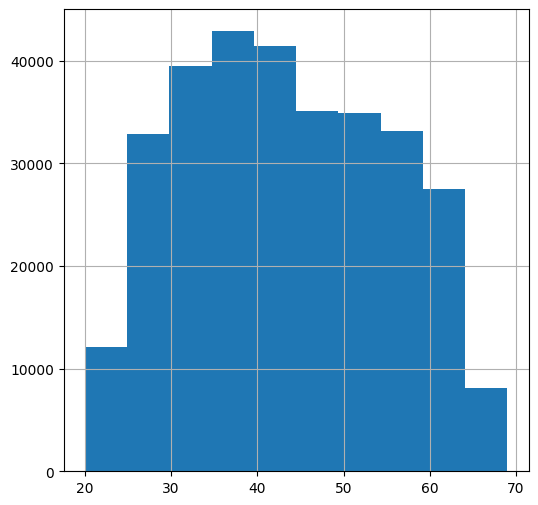

In [652]:
unclean_merged_data["AGE"].hist(figsize=(6,6))

##### Continuous Numerical Variables 

** might have to deal with those x10^6 histograms separately

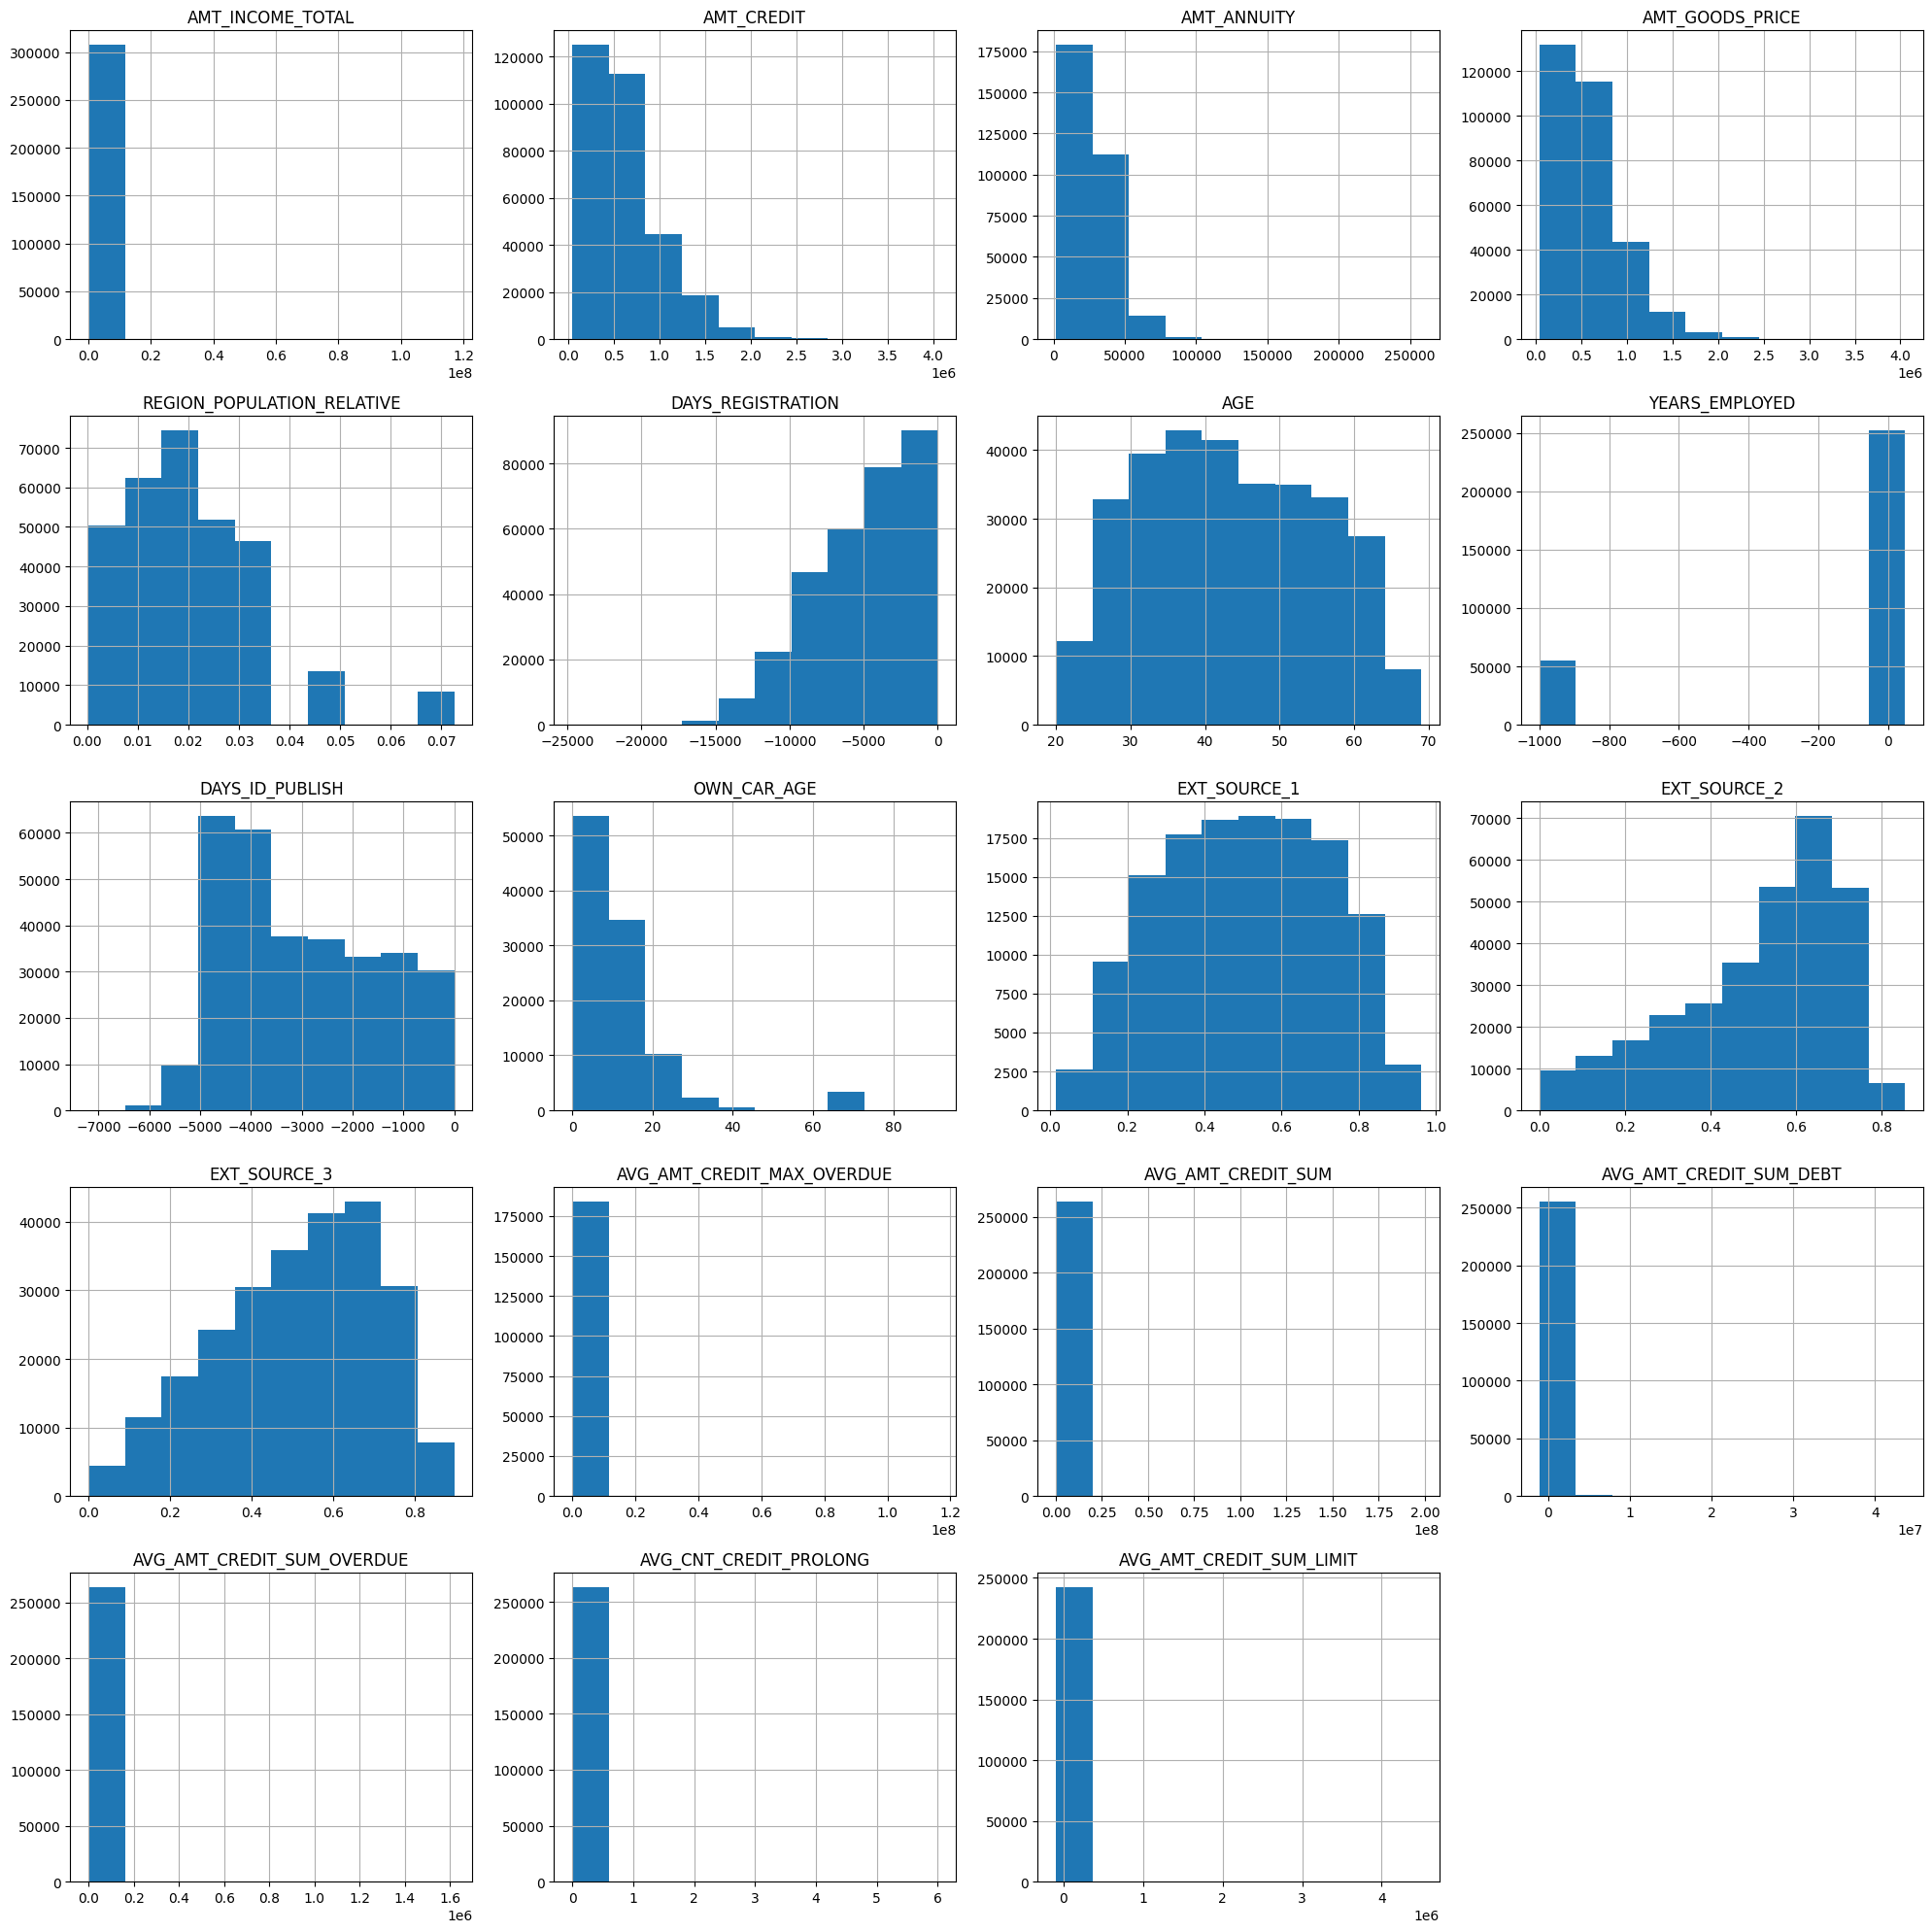

In [653]:
unclean_merged_data[num_cont_var].hist(figsize=(20,20))
plt.tight_layout()

#### Bar Chart - Discrete Numerical Variables

** maybe can j remove also coz some dont make sense

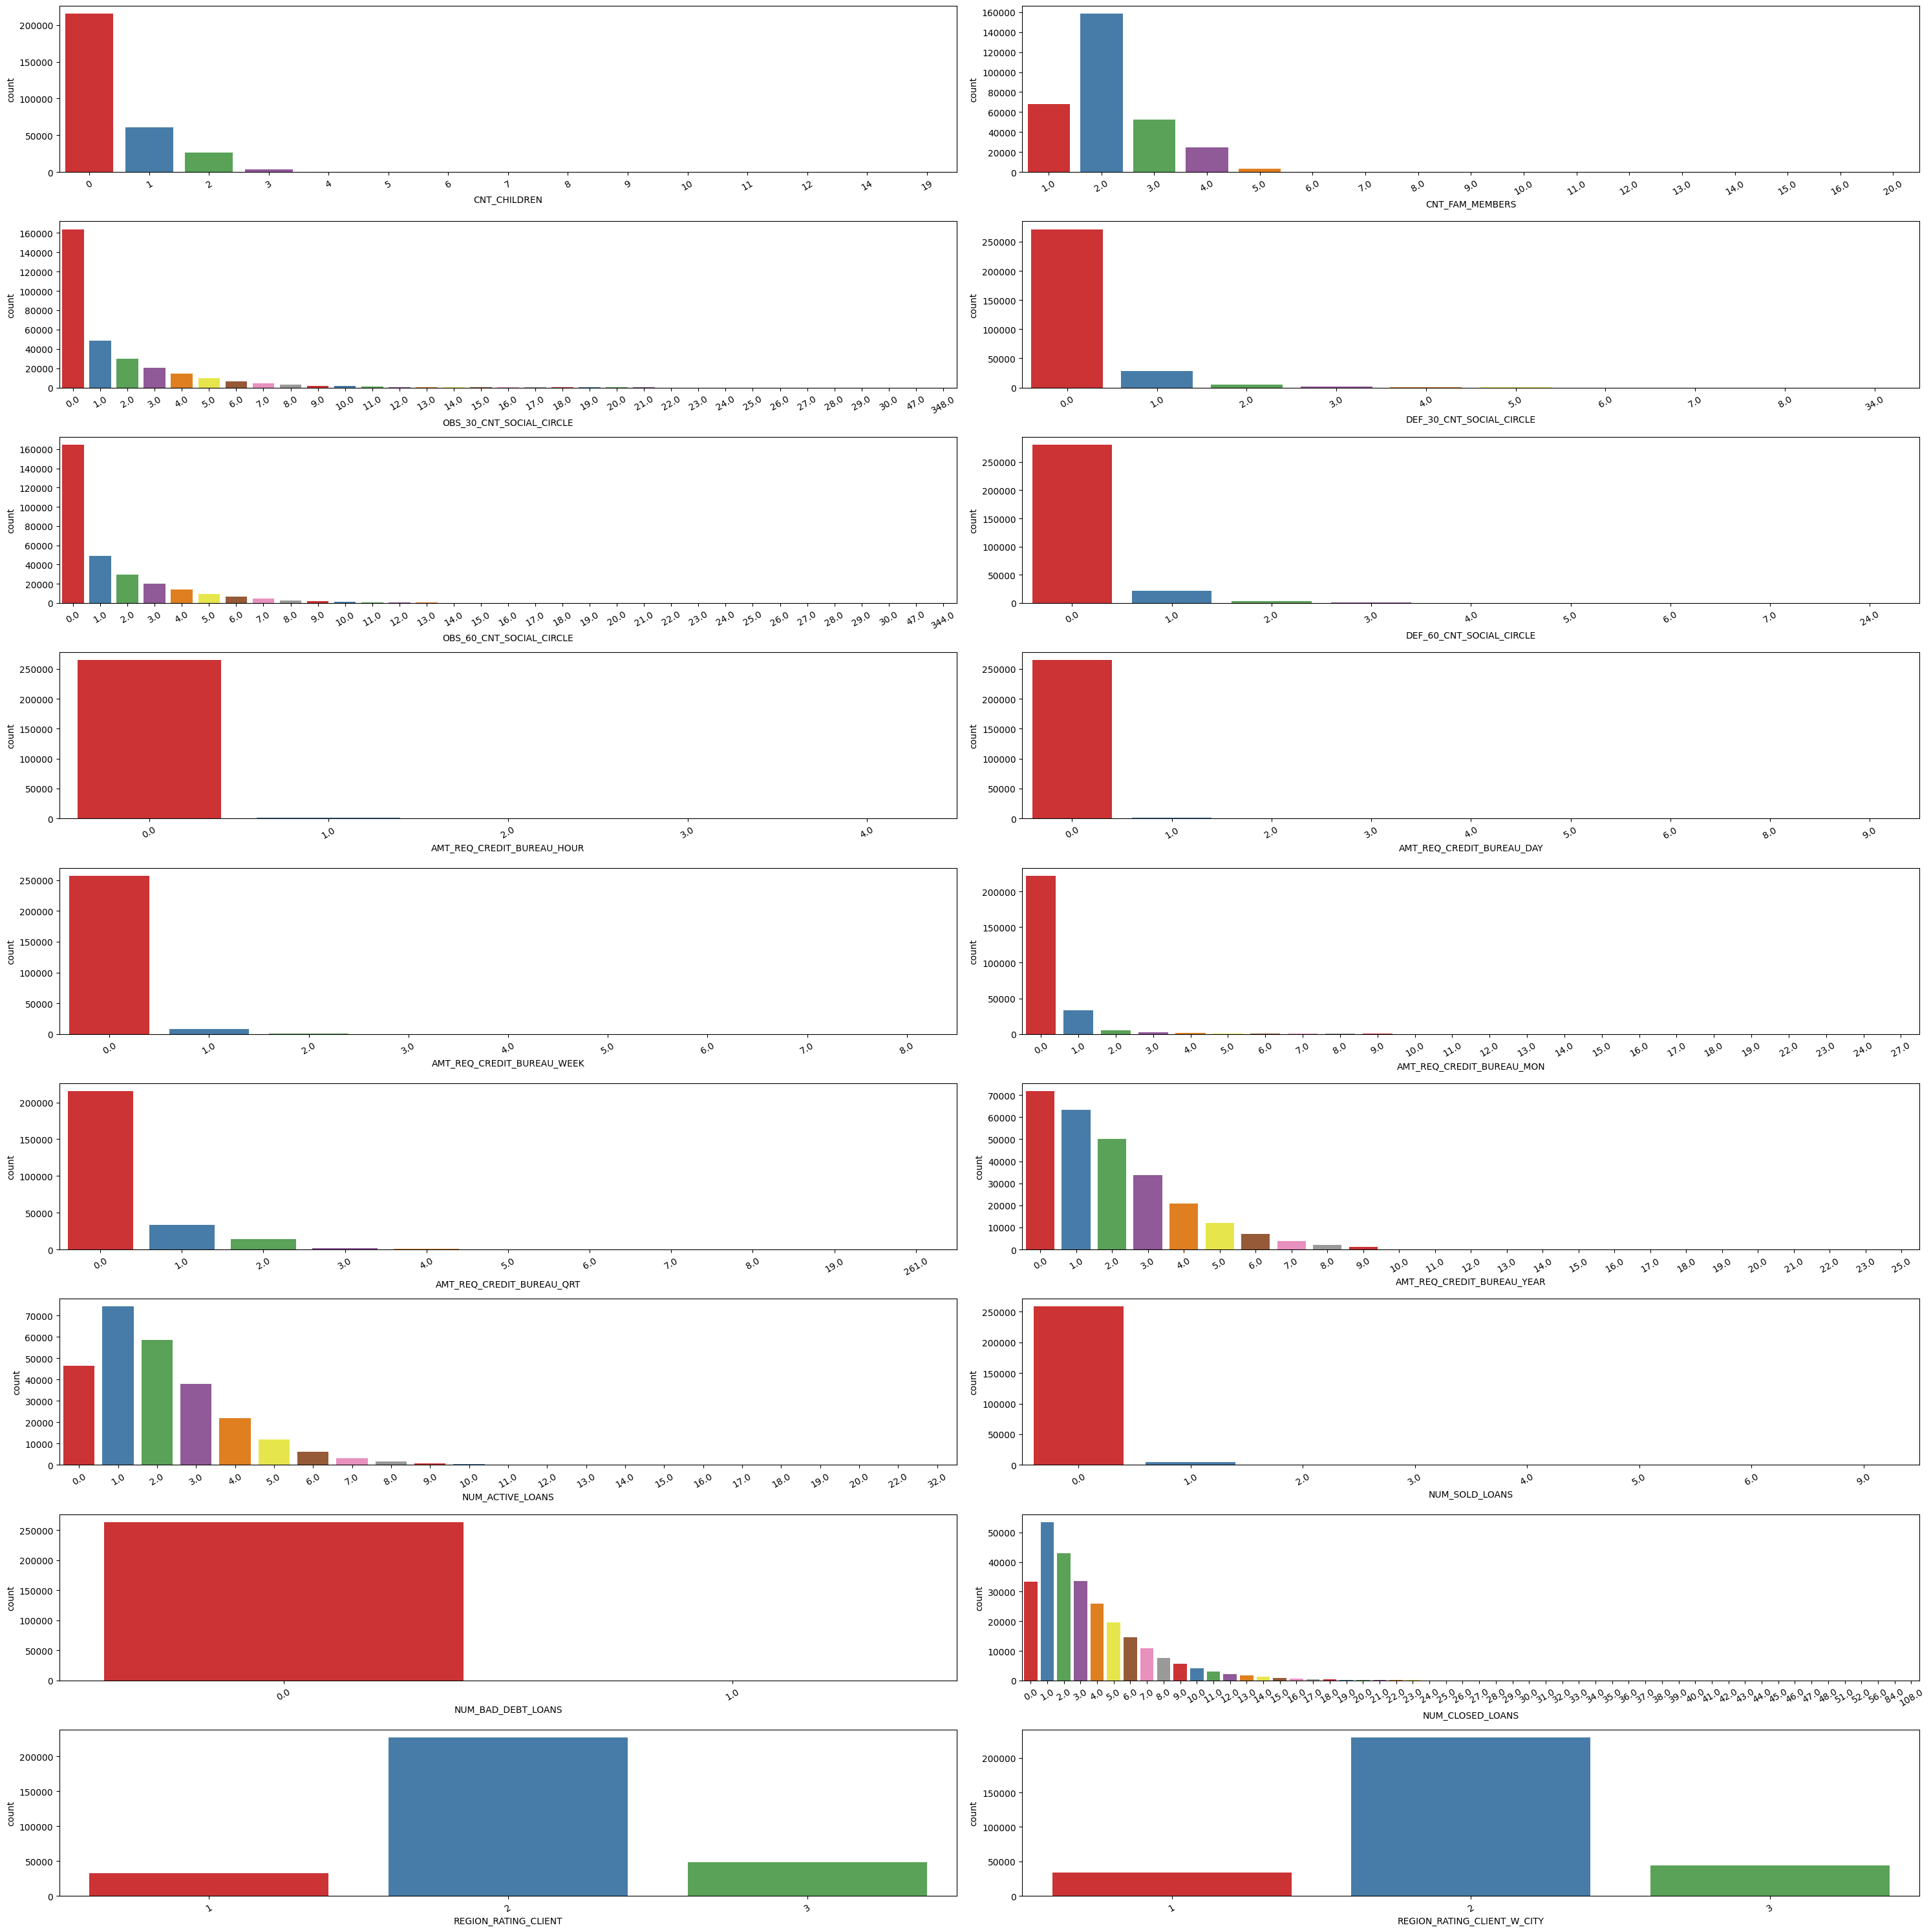

In [654]:
row_count=int(np.ceil(len(num_disc_var)/2))

fig, axes = plt.subplots(ncols=2, nrows=row_count, figsize=(30,30))

for i, axis in enumerate(fig.axes):
    sns.countplot(ax=axis, x=unclean_merged_data[num_disc_var[i]],orient='h', palette="Set1")
    axis.set_xlabel(str(num_disc_var[i]))
    axis.set_xticklabels(axis.get_xticklabels(), rotation=30)
    if i == len(num_disc_var)-1: 
         break

plt.tight_layout()

#### Bar Chart - Categorical Variables

##### Organization Type

[Text(0, 0, 'Business Entity Type 3'),
 Text(1, 0, 'XNA'),
 Text(2, 0, 'Self-employed'),
 Text(3, 0, 'Other'),
 Text(4, 0, 'Medicine'),
 Text(5, 0, 'Business Entity Type 2'),
 Text(6, 0, 'Government'),
 Text(7, 0, 'School'),
 Text(8, 0, 'Trade: type 7'),
 Text(9, 0, 'Kindergarten'),
 Text(10, 0, 'Construction'),
 Text(11, 0, 'Business Entity Type 1'),
 Text(12, 0, 'Transport: type 4'),
 Text(13, 0, 'Trade: type 3'),
 Text(14, 0, 'Industry: type 9'),
 Text(15, 0, 'Industry: type 3'),
 Text(16, 0, 'Security'),
 Text(17, 0, 'Housing'),
 Text(18, 0, 'Industry: type 11'),
 Text(19, 0, 'Military'),
 Text(20, 0, 'Bank'),
 Text(21, 0, 'Agriculture'),
 Text(22, 0, 'Police'),
 Text(23, 0, 'Transport: type 2'),
 Text(24, 0, 'Postal'),
 Text(25, 0, 'Security Ministries'),
 Text(26, 0, 'Trade: type 2'),
 Text(27, 0, 'Restaurant'),
 Text(28, 0, 'Services'),
 Text(29, 0, 'University'),
 Text(30, 0, 'Industry: type 7'),
 Text(31, 0, 'Transport: type 3'),
 Text(32, 0, 'Industry: type 1'),
 Text(33, 0, 

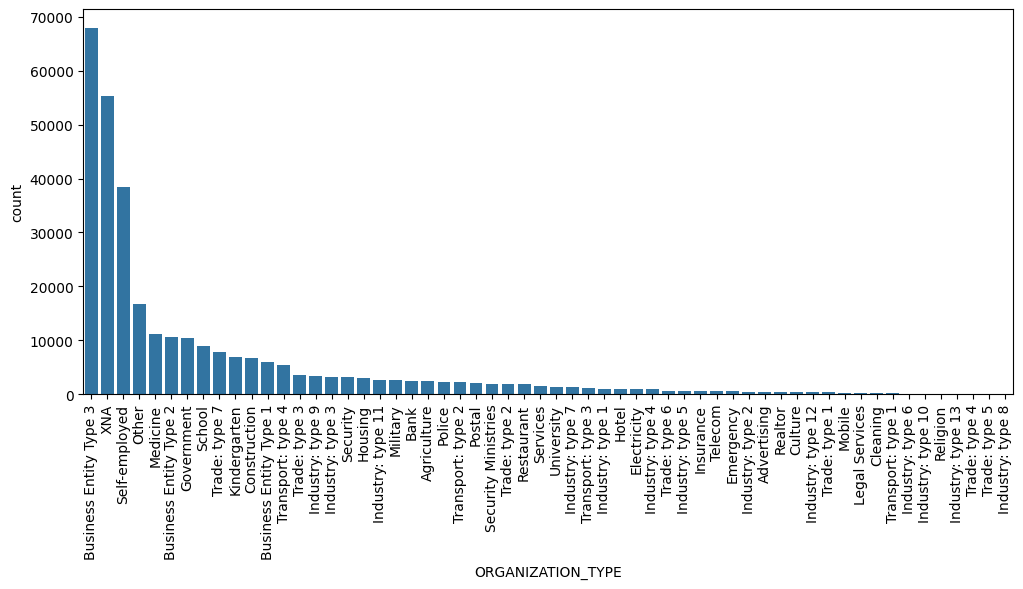

In [655]:
plt.figure(figsize=(12,5))
ax = sns.countplot(x= unclean_merged_data['ORGANIZATION_TYPE'], order = unclean_merged_data['ORGANIZATION_TYPE'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

#### Count distribution of Flag Documents (no clue where to fit this but it doesnt fit here)

In [656]:
### Get distribution of Flag Documents 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
variable_name = "FLAG_DOCUMENT_"
for i in range(2,22):
    print("FLAG_DOCUMENT_"+str(i))
    print(app_data["FLAG_DOCUMENT_"+str(i)].value_counts())
    print("")

FLAG_DOCUMENT_2
FLAG_DOCUMENT_2
0    307498
1        13
Name: count, dtype: int64

FLAG_DOCUMENT_3
FLAG_DOCUMENT_3
1    218340
0     89171
Name: count, dtype: int64

FLAG_DOCUMENT_4
FLAG_DOCUMENT_4
0    307486
1        25
Name: count, dtype: int64

FLAG_DOCUMENT_5
FLAG_DOCUMENT_5
0    302863
1      4648
Name: count, dtype: int64

FLAG_DOCUMENT_6
FLAG_DOCUMENT_6
0    280433
1     27078
Name: count, dtype: int64

FLAG_DOCUMENT_7
FLAG_DOCUMENT_7
0    307452
1        59
Name: count, dtype: int64

FLAG_DOCUMENT_8
FLAG_DOCUMENT_8
0    282487
1     25024
Name: count, dtype: int64

FLAG_DOCUMENT_9
FLAG_DOCUMENT_9
0    306313
1      1198
Name: count, dtype: int64

FLAG_DOCUMENT_10
FLAG_DOCUMENT_10
0    307504
1         7
Name: count, dtype: int64

FLAG_DOCUMENT_11
FLAG_DOCUMENT_11
0    306308
1      1203
Name: count, dtype: int64

FLAG_DOCUMENT_12
FLAG_DOCUMENT_12
0    307509
1         2
Name: count, dtype: int64

FLAG_DOCUMENT_13
FLAG_DOCUMENT_13
0    306427
1      1084
Name: count, dtype: int

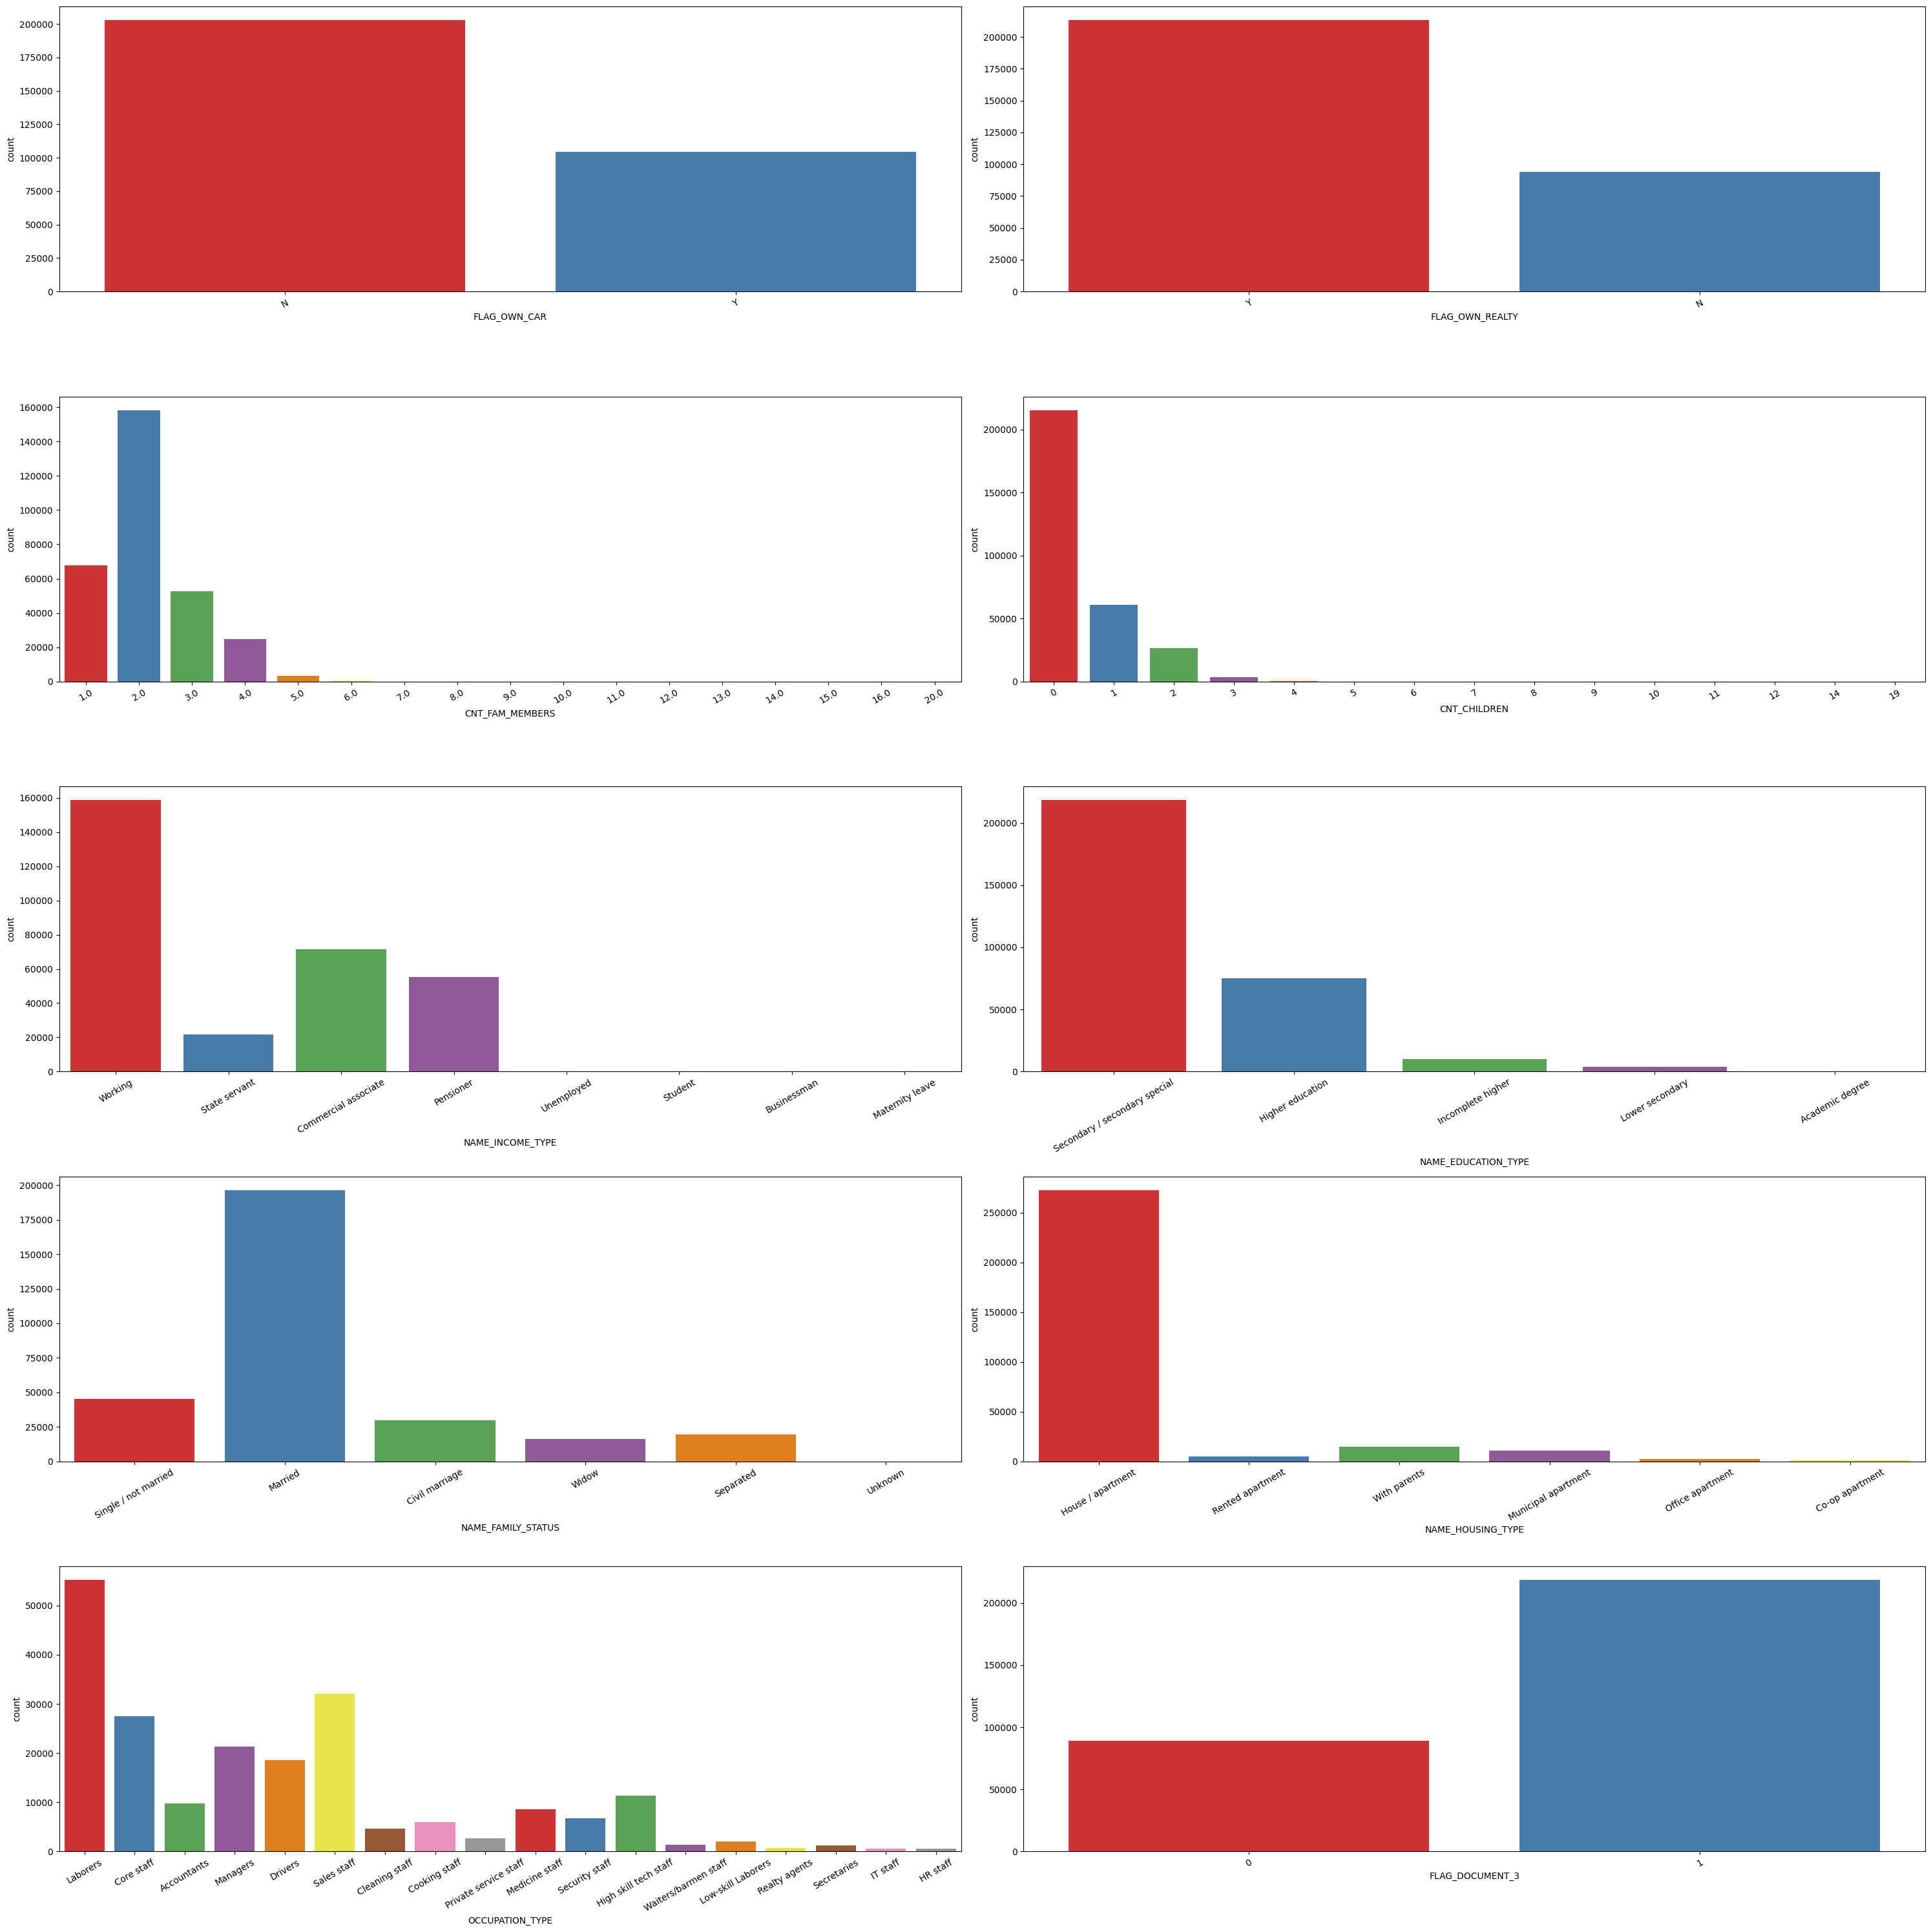

In [657]:
row_count=int(np.ceil(len(cat_var)/2))

fig, axes = plt.subplots(ncols=2, nrows=row_count, figsize=(30,30))

for i, axis in enumerate(fig.axes):
    sns.countplot(ax=axis, x=unclean_merged_data[cat_var[i]],orient='h', palette="Set1")
    axis.set_xlabel(str(cat_var[i]))
    axis.set_xticklabels(axis.get_xticklabels(), rotation=30)
    if i == len(cat_var)-1: 
         break

plt.tight_layout()

## 1.2 Bivariate Analysis

#### KDE Plot - Continuous Numerical Variables 

** same x10E6 issue

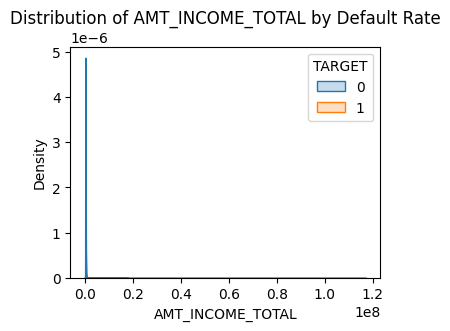

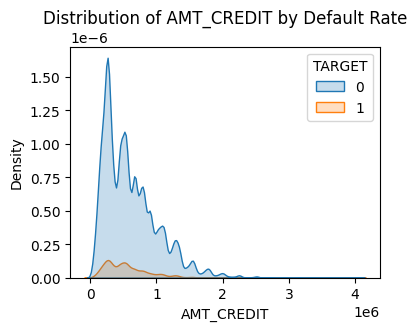

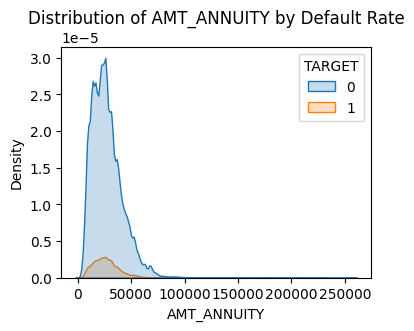

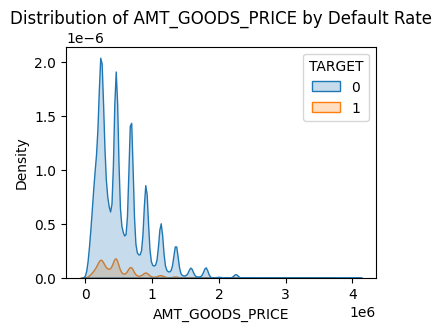

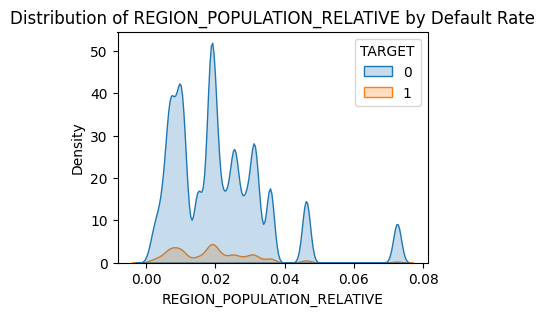

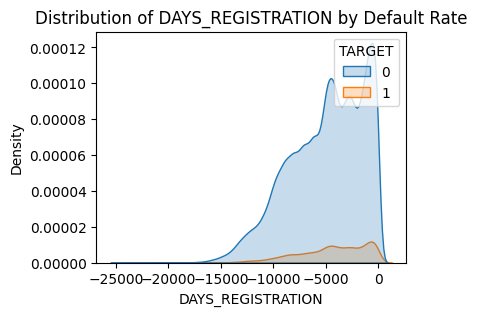

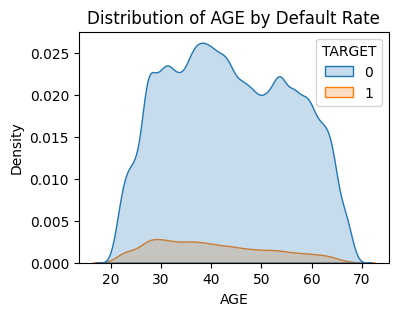

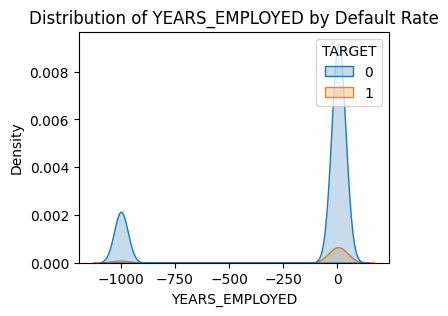

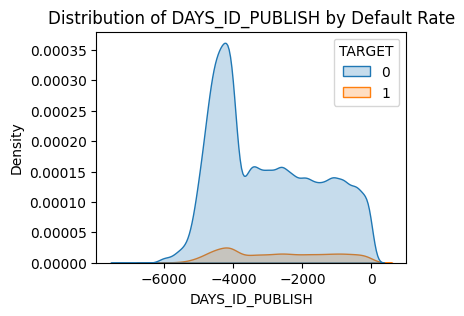

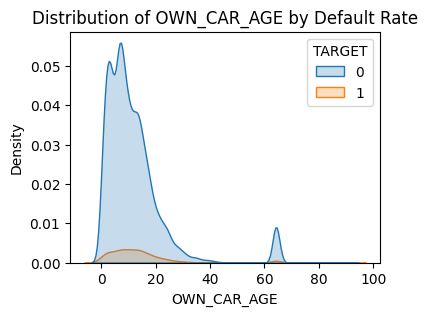

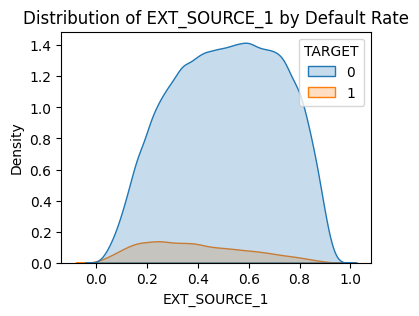

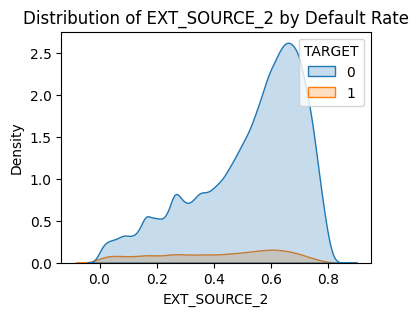

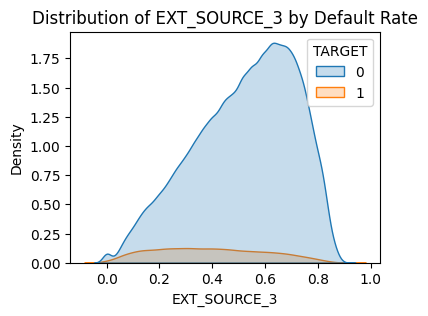

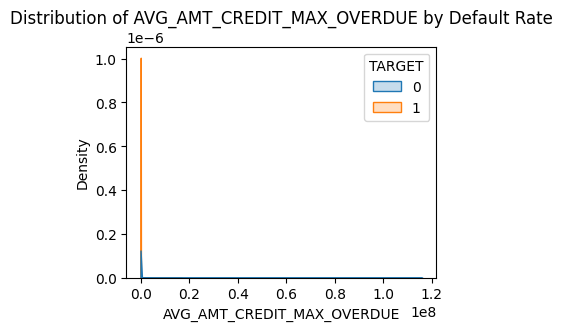

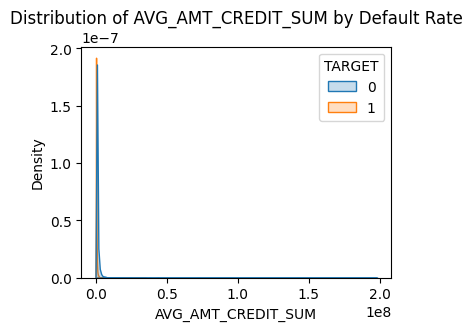

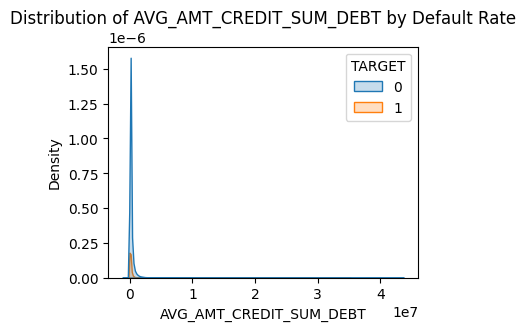

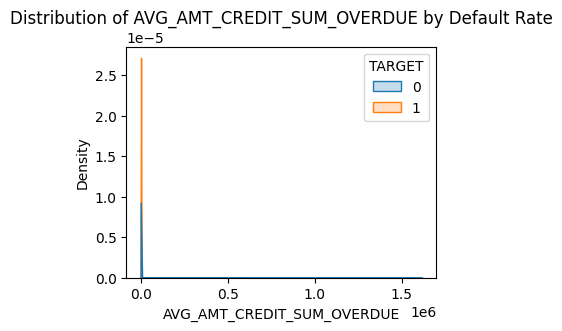

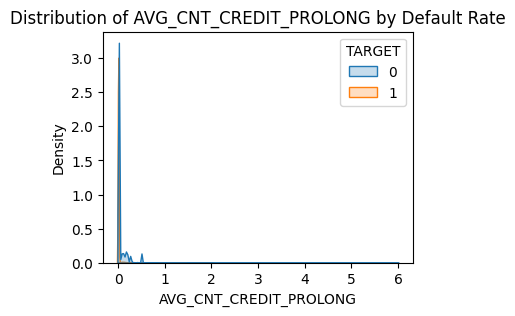

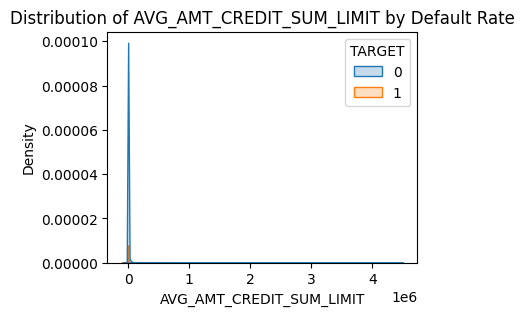

In [658]:
for i in range(len(num_cont_var)):
    plt.figure(figsize=(4,3))
    sns.kdeplot(data=unclean_merged_data, x=num_cont_var[i], hue="TARGET", fill = True)
    title = "Distribution of " + num_cont_var[i] + " by Default Rate"
    plt.title(title)

#### Bar Charts - Discrete Numerical Data

** sam ething maybe can remove also and not do for dsicrete num

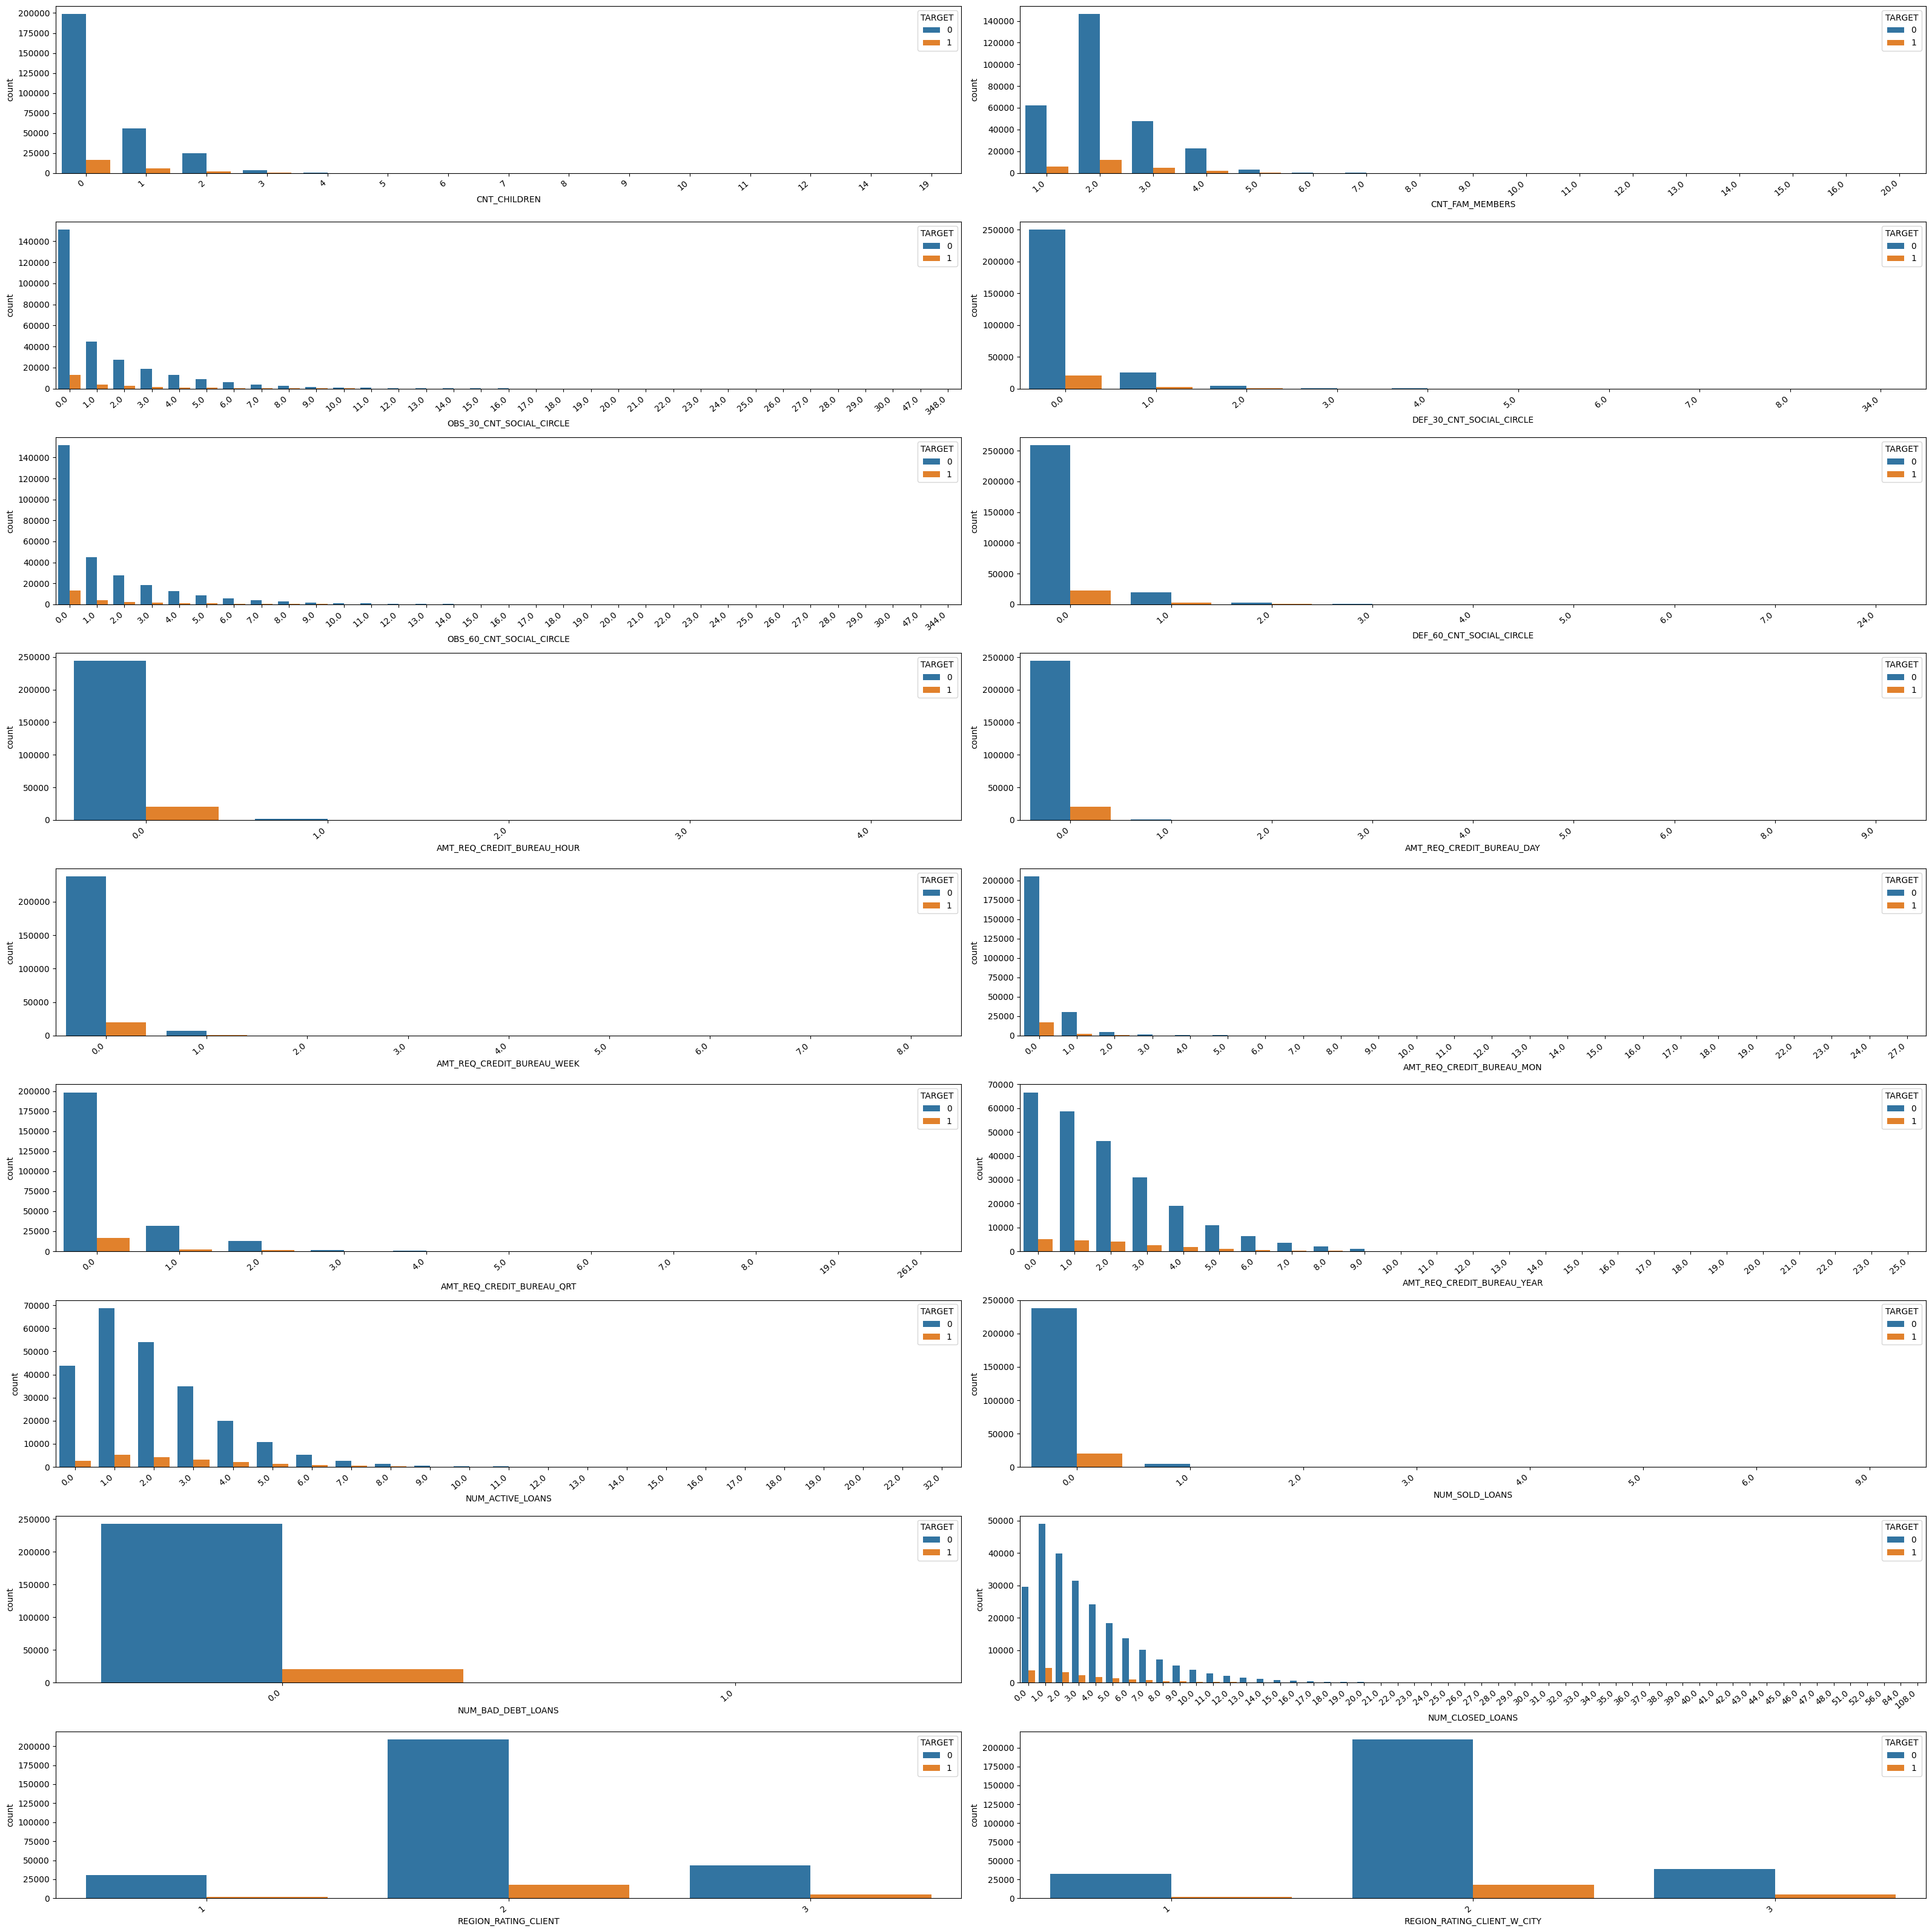

In [659]:
row_count=int(np.ceil(len(num_disc_var)/2))
fig, axes = plt.subplots(ncols=2, nrows=row_count, figsize=(32, 32))

for i, axis in enumerate(fig.axes):
    sns.countplot(ax=axis, x= unclean_merged_data[num_disc_var[i]], hue=app_data['TARGET'])
    axis.set_xlabel(str(num_disc_var[i]))
    axis.set_xticklabels(axis.get_xticklabels(), rotation=40, ha="right")

    if i == len(num_disc_var)-1: 
         break
    
# Show the plot
plt.tight_layout()

#### Bar Charts - Categorical Data

##### Organization Type

[Text(0, 0, 'Business Entity Type 3'),
 Text(1, 0, 'School'),
 Text(2, 0, 'Government'),
 Text(3, 0, 'Religion'),
 Text(4, 0, 'Other'),
 Text(5, 0, 'XNA'),
 Text(6, 0, 'Electricity'),
 Text(7, 0, 'Medicine'),
 Text(8, 0, 'Business Entity Type 2'),
 Text(9, 0, 'Self-employed'),
 Text(10, 0, 'Transport: type 2'),
 Text(11, 0, 'Construction'),
 Text(12, 0, 'Housing'),
 Text(13, 0, 'Kindergarten'),
 Text(14, 0, 'Trade: type 7'),
 Text(15, 0, 'Industry: type 11'),
 Text(16, 0, 'Military'),
 Text(17, 0, 'Services'),
 Text(18, 0, 'Security Ministries'),
 Text(19, 0, 'Transport: type 4'),
 Text(20, 0, 'Industry: type 1'),
 Text(21, 0, 'Emergency'),
 Text(22, 0, 'Security'),
 Text(23, 0, 'Trade: type 2'),
 Text(24, 0, 'University'),
 Text(25, 0, 'Transport: type 3'),
 Text(26, 0, 'Police'),
 Text(27, 0, 'Business Entity Type 1'),
 Text(28, 0, 'Postal'),
 Text(29, 0, 'Industry: type 4'),
 Text(30, 0, 'Agriculture'),
 Text(31, 0, 'Restaurant'),
 Text(32, 0, 'Culture'),
 Text(33, 0, 'Hotel'),
 Tex

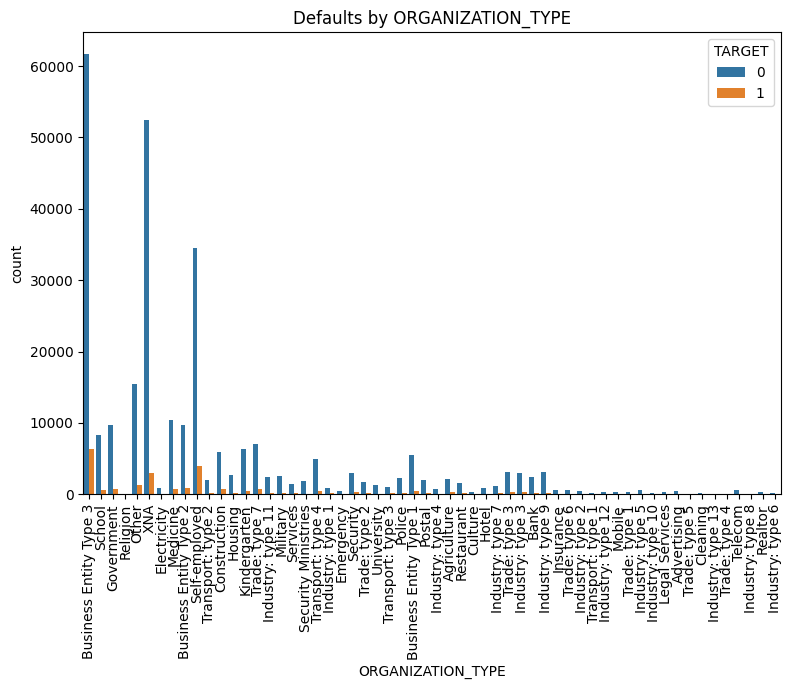

In [660]:
plt.figure(figsize=(9,6))
ax = sns.countplot(x= unclean_merged_data['ORGANIZATION_TYPE'], hue=unclean_merged_data['TARGET'])
plt.title('Defaults by ORGANIZATION_TYPE')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

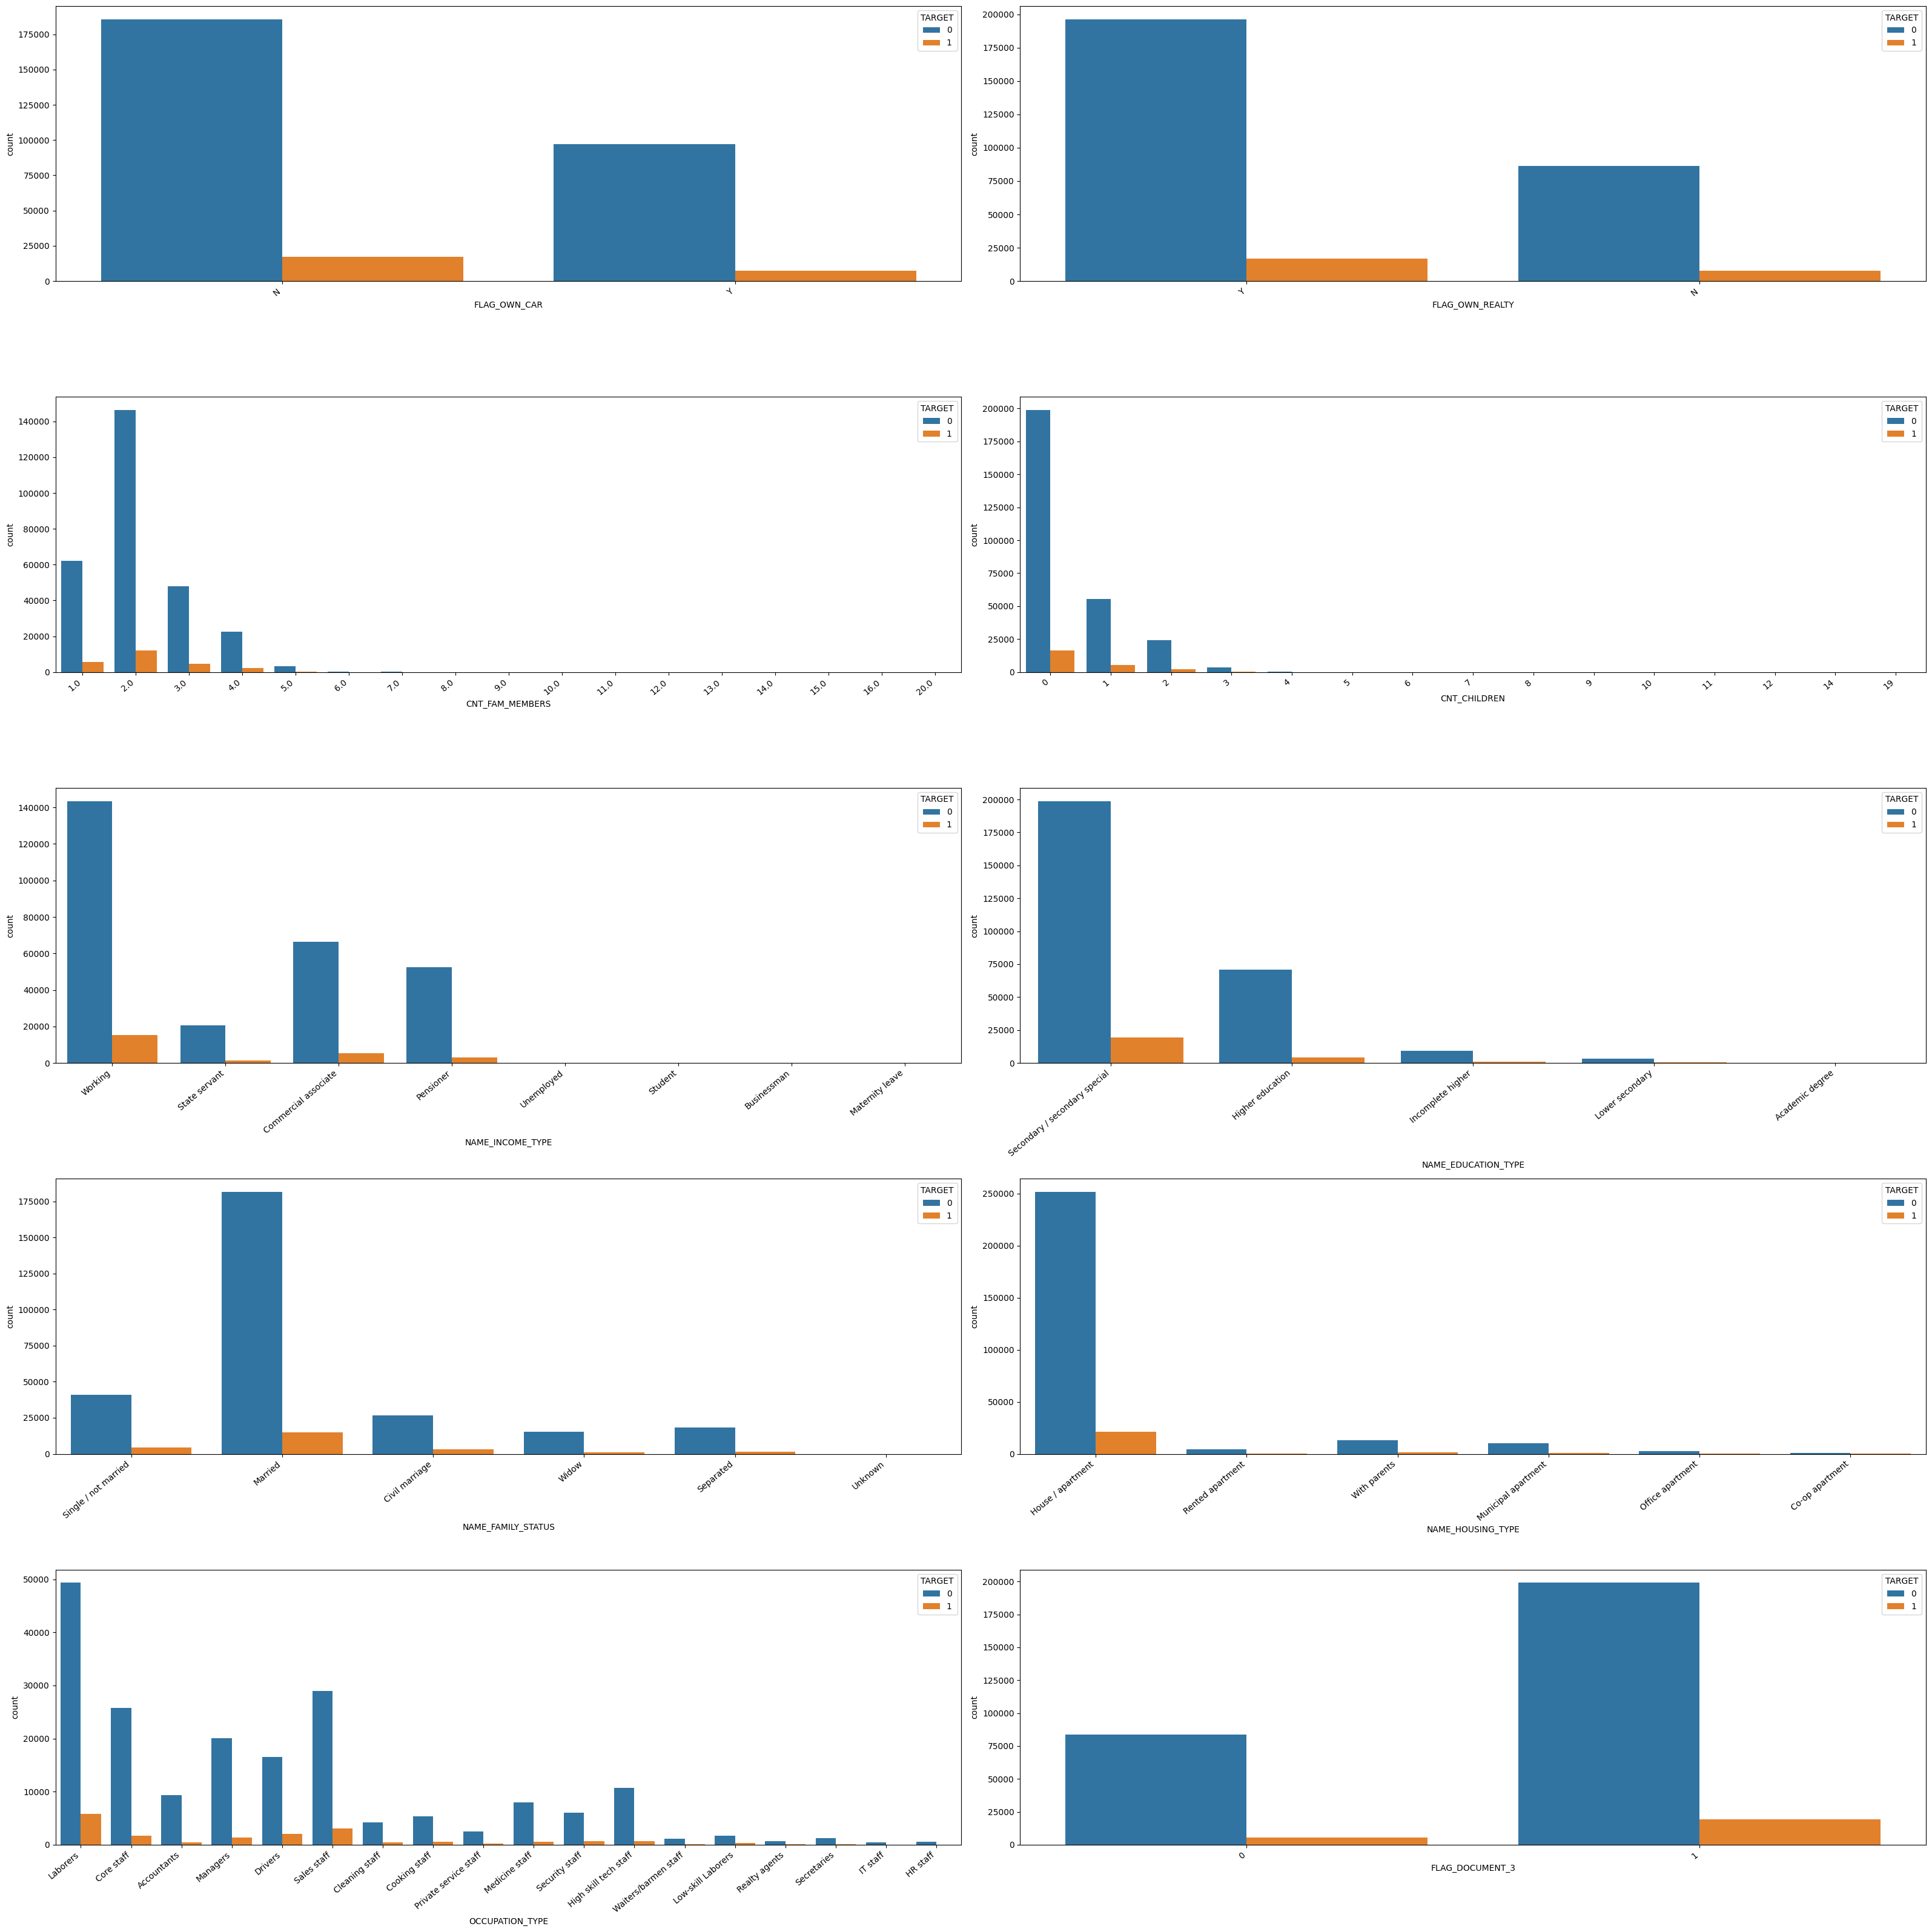

In [661]:
row_count=int(np.ceil(len(cat_var)/2))
fig, axes = plt.subplots(ncols=2, nrows=row_count, figsize=(32, 32))

for i, axis in enumerate(fig.axes):
    sns.countplot(ax=axis, x= unclean_merged_data[cat_var[i]], hue=app_data['TARGET'])
    axis.set_xlabel(str(cat_var[i]))
    axis.set_xticklabels(axis.get_xticklabels(), rotation=40, ha="right")

    if i == len(cat_var)-1: 
         break
    
# Show the plot
plt.tight_layout()

#### Stacked Bar Charts - Numerical Discrete Data

##### Age

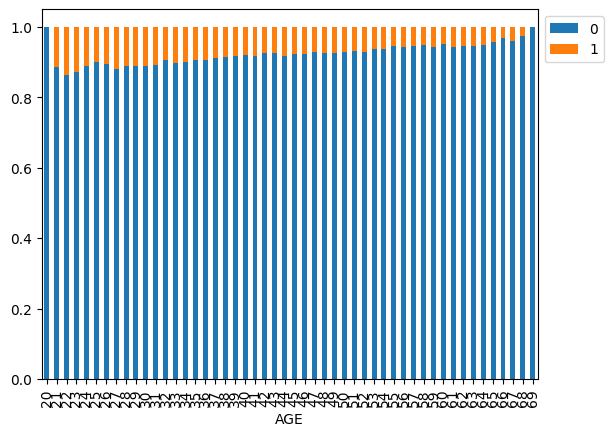

In [662]:
df_reason_bivariate = unclean_merged_data.groupby("AGE")['TARGET'].value_counts(normalize = True).unstack()
ax = df_reason_bivariate.plot(kind='bar', stacked='True')
ax.legend(bbox_to_anchor=(1.0, 1.0))

#### Stacked Bar Charts - Categorical Data

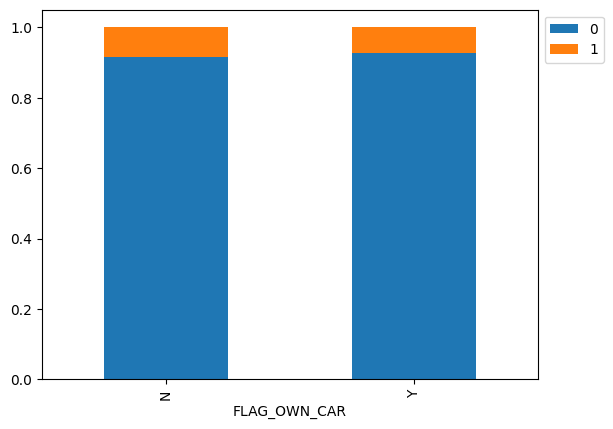

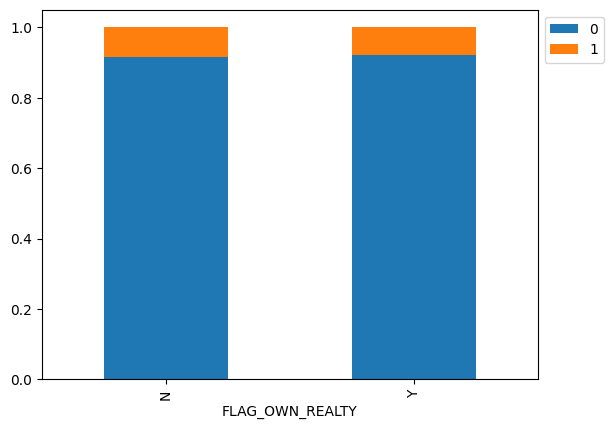

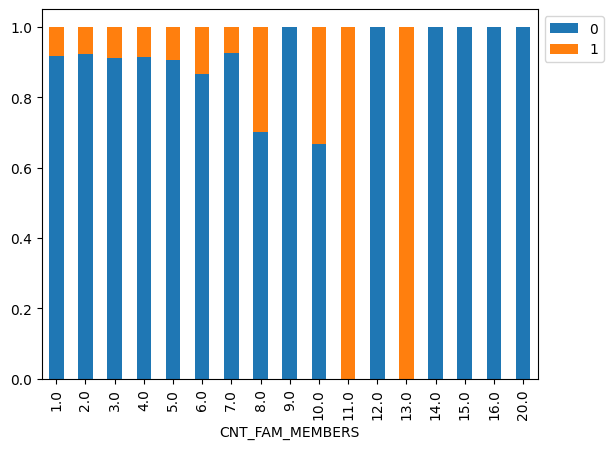

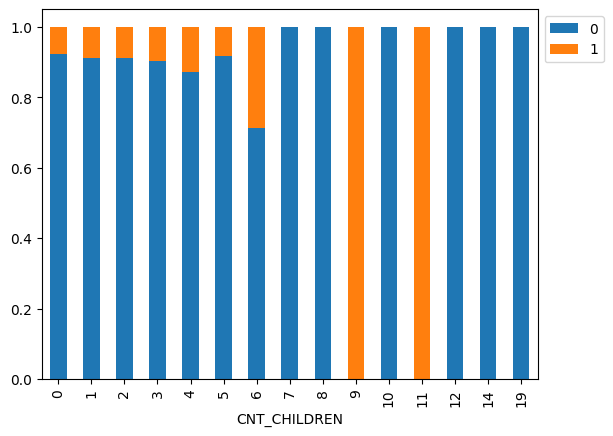

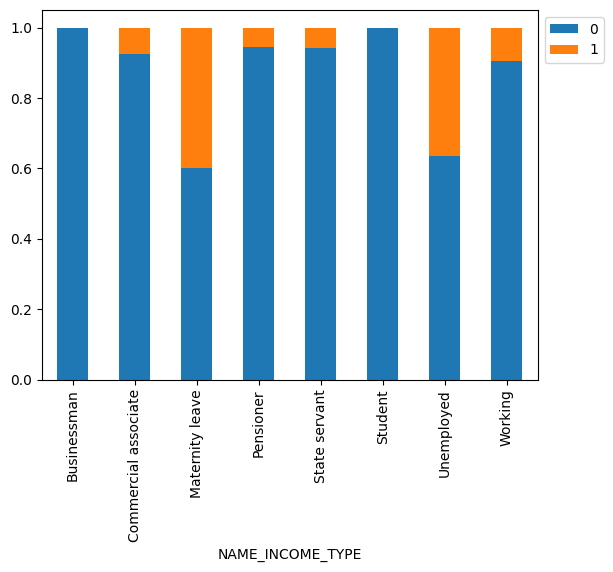

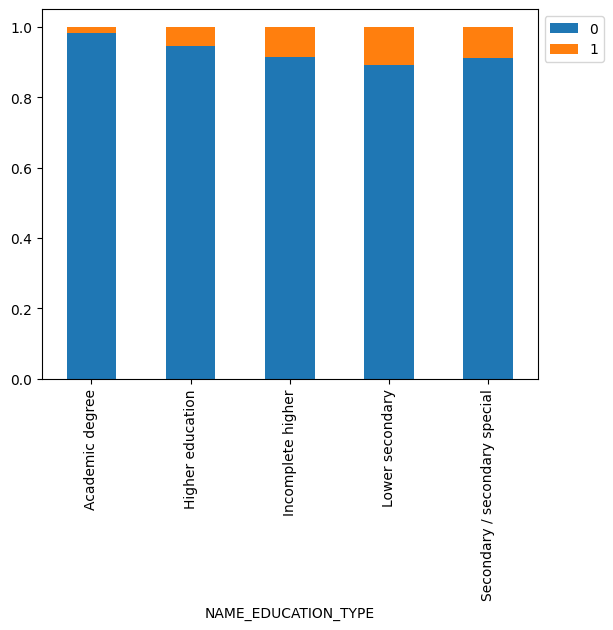

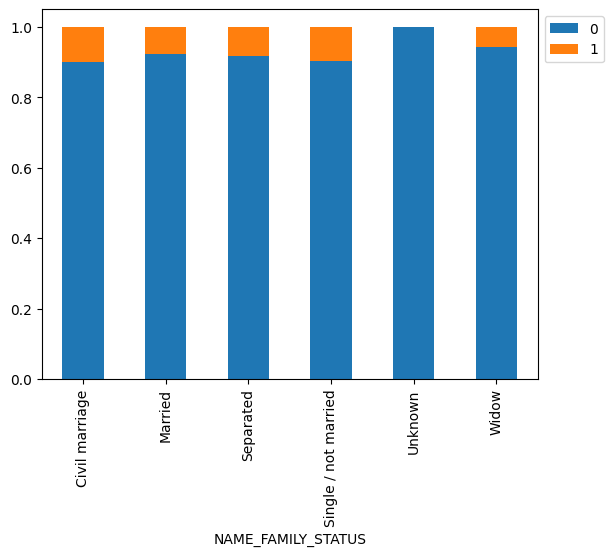

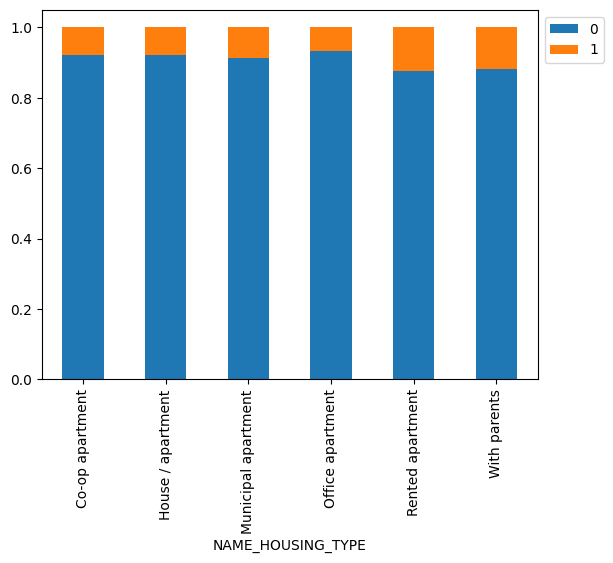

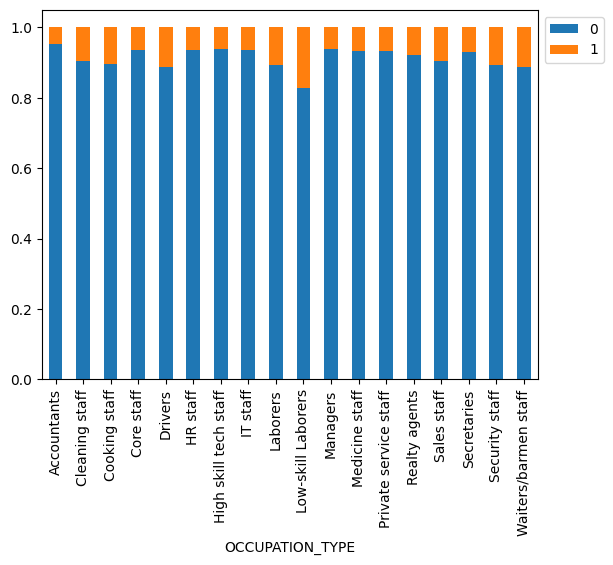

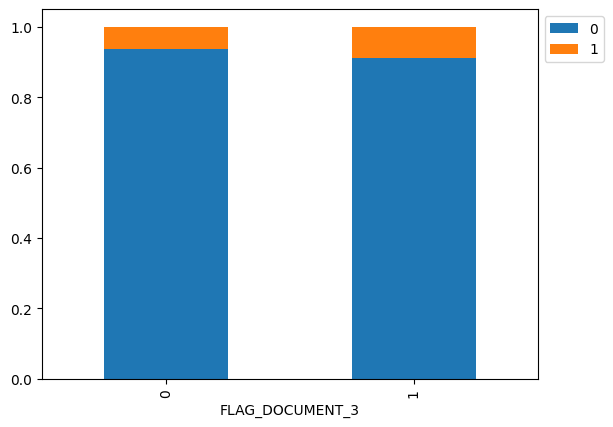

In [663]:
row_count=int(np.ceil(len(cat_var)/2))

for i in cat_var:
    df_reason_bivariate = unclean_merged_data.groupby(i)['TARGET'].value_counts(normalize = True).unstack()
    ax = df_reason_bivariate.plot(kind='bar', stacked='True')
    ax.legend(bbox_to_anchor=(1.0, 1.0))
    if i == len(cat_var)-1: 
         break
        
plt.show()

## 2. Data Preparation

## 2.1 Feature Selection & Extraction from Merged Data
#### Select Columns and Filter Out Self-Employed & Age 


In [664]:
# extract selected columns and filter by self-employed
unclean_merged_data = unclean_merged_data[unclean_merged_data['ORGANIZATION_TYPE'] == 'Self-employed']
unclean_merged_data

SK_ID_CURR  TARGET FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
13          100017       0            Y               N             1   
20          100024       0            Y               Y             0   
22          100026       0            N               N             1   
33          100039       0            Y               N             1   
35          100041       0            N               N             0   
...            ...     ...          ...             ...           ...   
307491      456235       0            Y               Y             2   
307492      456236       0            Y               Y             0   
307494      456238       0            Y               N             1   
307496      456240       0            N               N             0   
307504      456248       0            N               Y             0   

        AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
13             225000.00   918468.00     28966.50        697500.00   
20             135000.00   427500.00     21375.00        427500.00   
22             450000.00   497520.00     32521.50        450000.00   
33             360000.00   733315.50     39069.00        679500.00   
35             112500.00   450000.00     44509.50        450000.00   
...                  ...         ...          ...              ...   
307491          90000.00  1078200.00     31522.50        900000.00   
307492         585000.00  1575000.00     43443.00       1575000.00   
307494         270000.00   479700.00     46858.50        450000.00   
307496         360000.00   337500.00     16875.00        337500.00   
307504         153000.00   331920.00     16096.50        225000.00   

            NAME_INCOME_TYPE  ... AVG_AMT_CREDIT_MAX_OVERDUE  \
13                   Working  ...                       0.00   
20                   Working  ...                        NaN   
22                   Working  ...                       0.00   
33      Commercial associate  ...                        NaN   
35                   Working  ...                     769.37   
...                      ...  ...                        ...   
307491  Commercial associate  ...                       0.00   
307492               Working  ...                    2805.55   
307494  Commercial associate  ...                    3191.74   
307496               Working  ...                    3996.00   
307504               Working  ...                        NaN   

       AVG_CNT_CREDIT_PROLONG AVG_AMT_CREDIT_SUM  AVG_AMT_CREDIT_SUM_DEBT  \
13                       0.00          143295.00                     0.00   
20                        NaN                NaN                      NaN   
22                       0.00         1875000.00               1738907.19   
33                       0.00          498788.00                348392.57   
35                       0.00           63254.24                     0.00   
...                       ...                ...                      ...   
307491                   0.00          493050.00                386679.00   
307492                   0.00          638975.60                442079.68   
307494                   0.00          184917.00                104225.25   
307496                   0.00           66199.50                 39872.25   
307504                    NaN                NaN                      NaN   

        AVG_AMT_CREDIT_SUM_LIMIT  AVG_AMT_CREDIT_SUM_OVERDUE  \
13                          0.00                        0.00   
20                           NaN                         NaN   
22                          0.00                        0.00   
33                          0.00                        0.00   
35                          0.00                        0.00   
...                          ...                         ...   
307491                      0.00                        0.00   
307492                      0.00                        0.00   
307494              

#### Applicants aged between 21 - 35

In [665]:
# Select records with applicants aged between 18 and 35
unclean_merged_data = unclean_merged_data[(unclean_merged_data["AGE"] >= 21) & (unclean_merged_data["AGE"] <= 35)]

#### Applicants with credit amount < 500k

In [666]:
# Select records with applicants with credit amount < 500k
unclean_merged_data = unclean_merged_data[(unclean_merged_data["AMT_CREDIT"] <= 500000)]
unclean_merged_data.info

<bound method DataFrame.info of         SK_ID_CURR  TARGET FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
22          100026       0            N               N             1   
35          100041       0            N               N             0   
45          100052       0            N               Y             1   
53          100061       0            N               Y             2   
77          100089       0            N               Y             0   
...            ...     ...          ...             ...           ...   
307353      456078       0            N               Y             0   
307383      456108       1            N               Y             1   
307385      456110       0            Y               Y             2   
307436      456174       0            N               N             2   
307457      456196       0            N               Y             2   

        AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
22             450000

In [667]:
# identify columns with NULL values
unclean_merged_data.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
FLAG_OWN_CAR                      0
FLAG_OWN_REALTY                   0
CNT_CHILDREN                      0
AMT_INCOME_TOTAL                  0
AMT_CREDIT                        0
AMT_ANNUITY                       0
AMT_GOODS_PRICE                  22
NAME_INCOME_TYPE                  0
NAME_EDUCATION_TYPE               0
NAME_FAMILY_STATUS                0
NAME_HOUSING_TYPE                 0
REGION_POPULATION_RELATIVE        0
DAYS_REGISTRATION                 0
DAYS_ID_PUBLISH                   0
OWN_CAR_AGE                    5447
OCCUPATION_TYPE                 739
CNT_FAM_MEMBERS                   0
REGION_RATING_CLIENT              0
REGION_RATING_CLIENT_W_CITY       0
EXT_SOURCE_1                   3569
EXT_SOURCE_2                     19
EXT_SOURCE_3                   2455
FLAG_DOCUMENT_3                   0
OBS_30_CNT_SOCIAL_CIRCLE         35
DEF_30_CNT_SOCIAL_CIRCLE         35
OBS_60_CNT_SOCIAL_CIRCLE    

#### Check Correlation of Variables

Correlation Heatmap: Application Data

<Axes: >

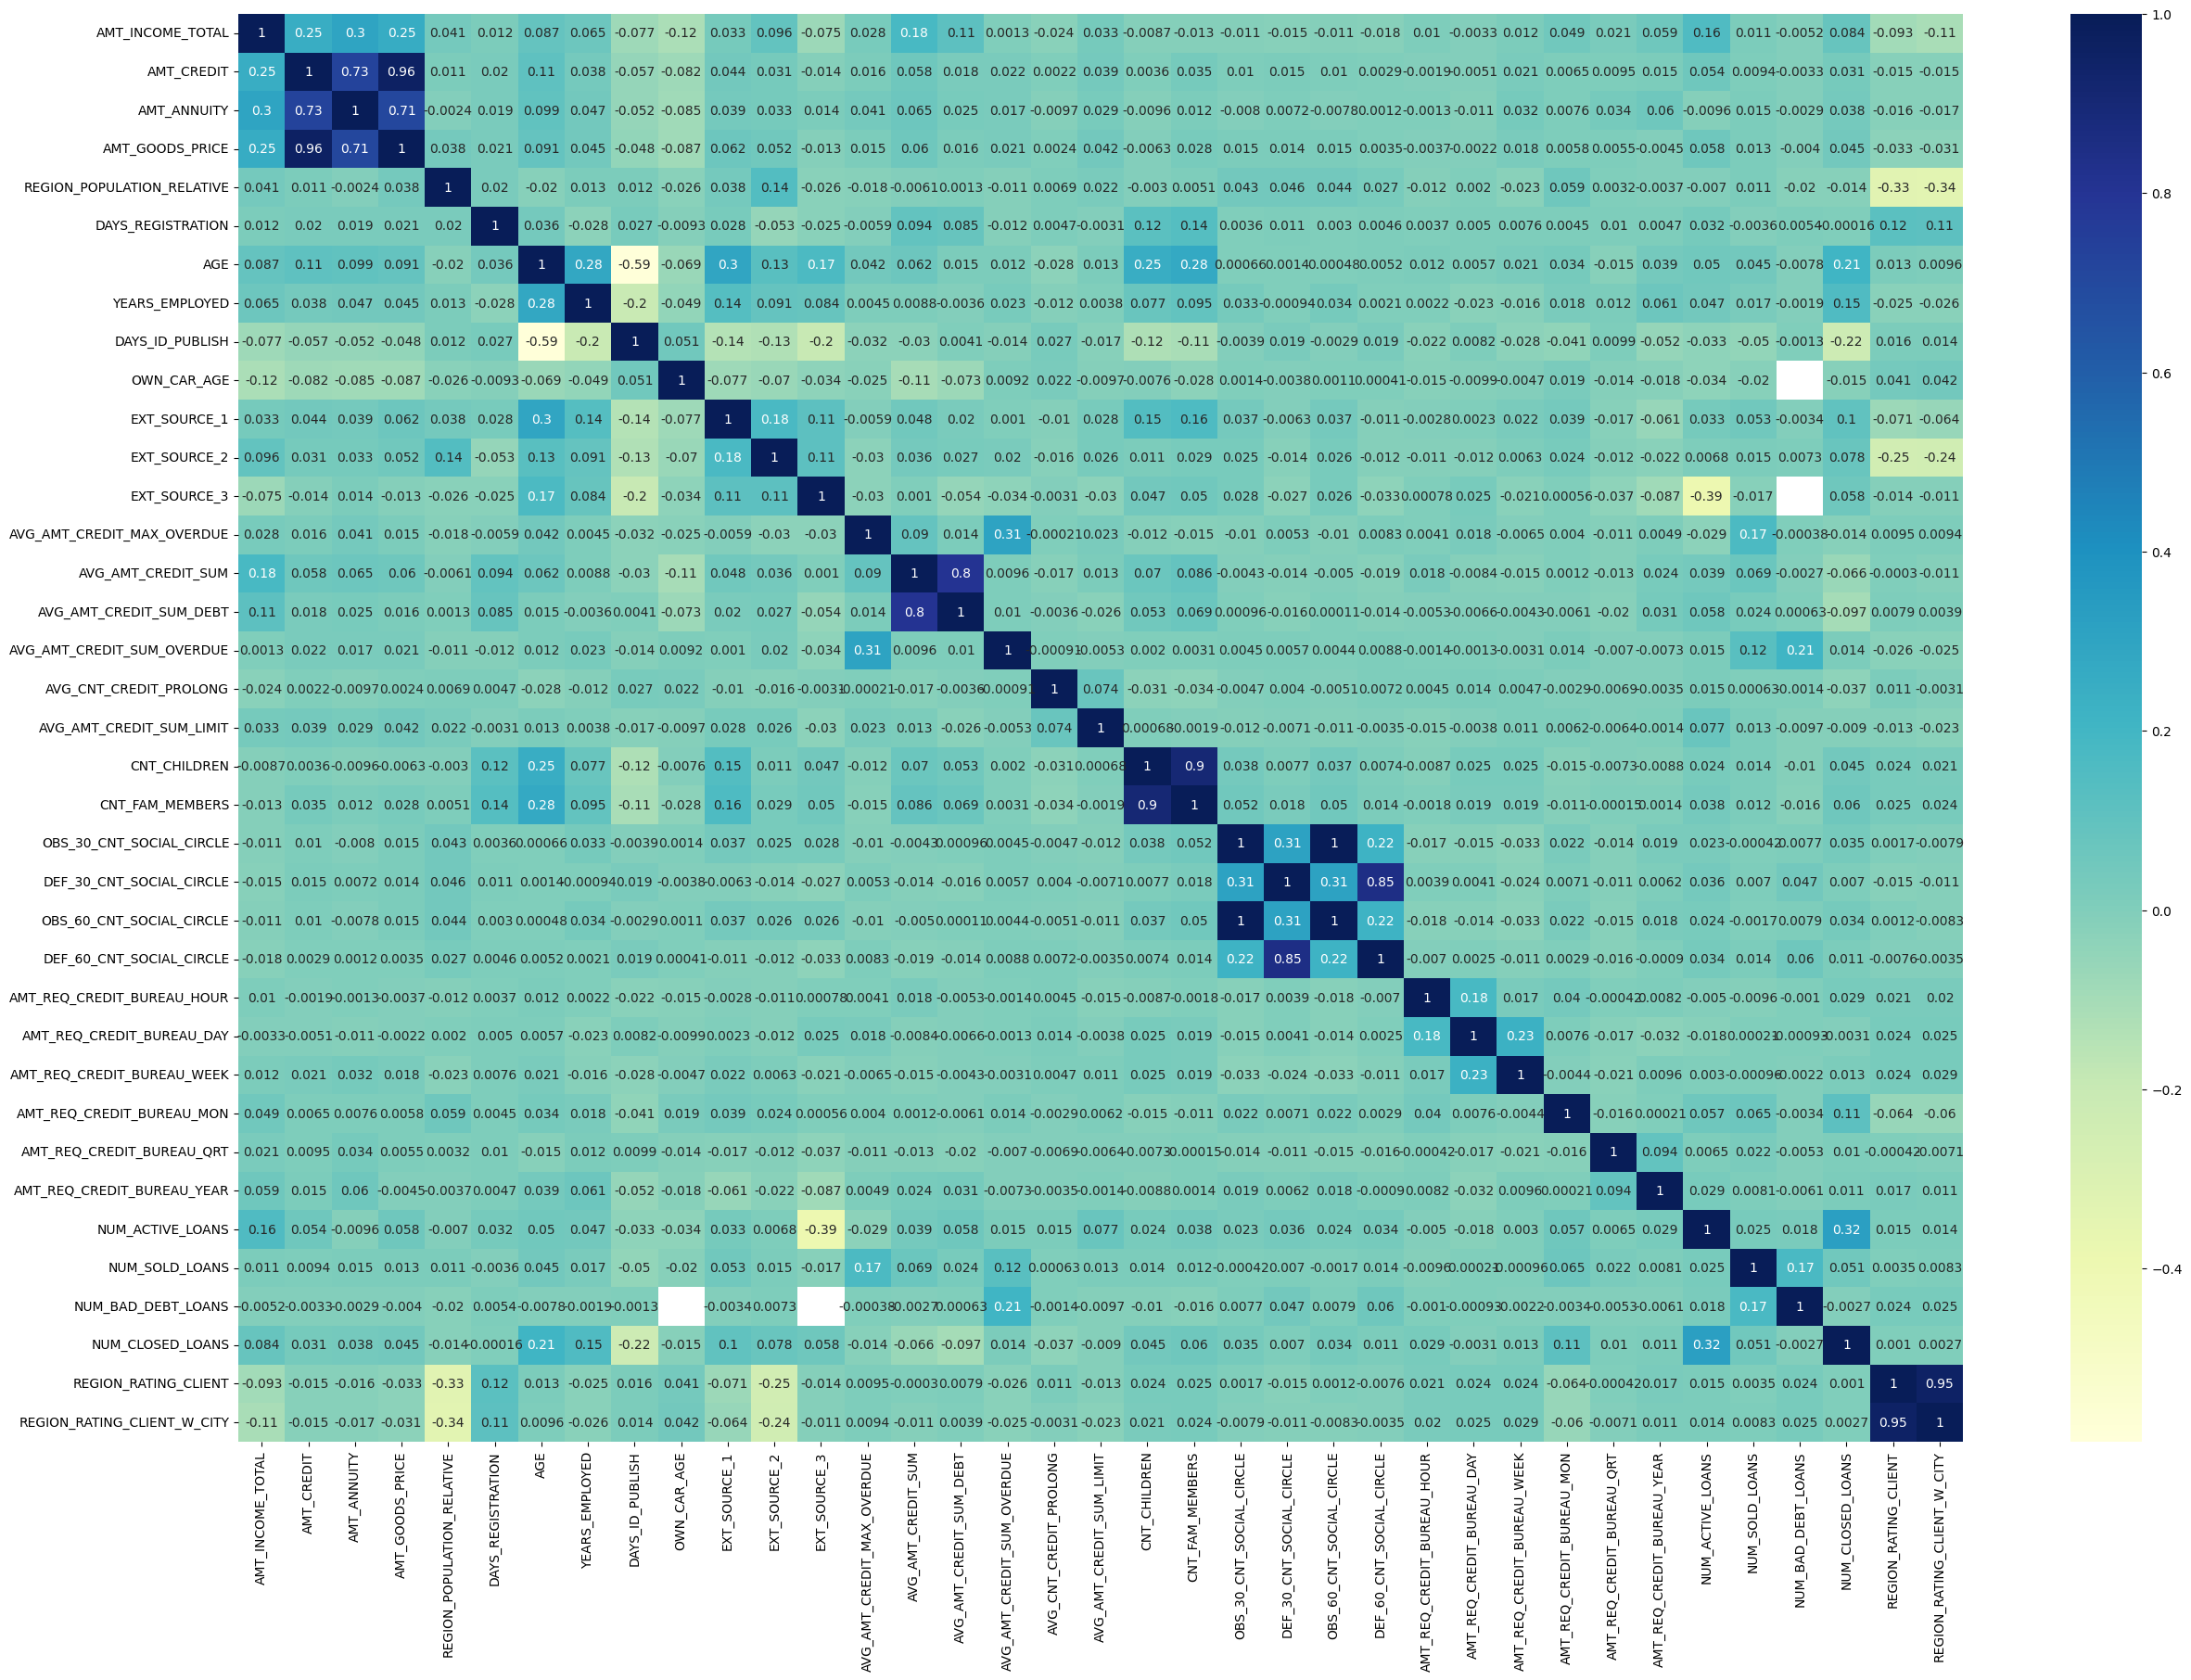

In [668]:

numerical_var = num_cont_var + num_disc_var
        
corr_matrix = unclean_merged_data[numerical_var].corr()

# plot heat map
fig, ax = plt.subplots(figsize=(30,20))
sns.heatmap(corr_matrix,xticklabels=corr_matrix.columns,yticklabels=corr_matrix.columns,annot=True,cmap="YlGnBu", ax=ax)

In [669]:
# Identify variables with highest correlation
# Set lower half of matrix to NaN
corr_matrix_top = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Convert to pivot table structure (panda series) to have both variables and their correlation in same row
corr_table = corr_matrix_top.stack()

# Locate variables with correlation > 0.5 (or indicated number)
corr_table_gt_0_5 = corr_table.loc[lambda x: x > 0.5]
print(corr_table_gt_0_5)

AMT_CREDIT                AMT_ANNUITY                   0.73
                          AMT_GOODS_PRICE               0.96
AMT_ANNUITY               AMT_GOODS_PRICE               0.71
AVG_AMT_CREDIT_SUM        AVG_AMT_CREDIT_SUM_DEBT       0.80
CNT_CHILDREN              CNT_FAM_MEMBERS               0.90
OBS_30_CNT_SOCIAL_CIRCLE  OBS_60_CNT_SOCIAL_CIRCLE      1.00
DEF_30_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE      0.85
REGION_RATING_CLIENT      REGION_RATING_CLIENT_W_CITY   0.95
dtype: float64


####  Highly correlated variables (r > 0.5)
- CNT_CHILDREN & CNT_FAM_MEMBERS: corr 0.9 --> drop CNT_CHILDREN as CNT_FAM_MEMBERS includes cnt_children
- AMT_CREDIT & AMT_ANNUITY: corr 0.73 --> drop AMT_ANNUITY as anuity is calculated from AMT_CREDIT
- AMT_CREDIT & AMT_GOODS_PRICE: corr 0.96 --> drop AMT_GOODS_PRICE as it is included in AMT_CREDIT
- AMT_ANNUITY & AMT_GOODS_PRICE: corr 0.71 --> dropped both as seen above
- REGION_RATING_CLIENT & REGION_RATING_CLIENT_W_CITY: corr 0.95 --> drop REGION_RATING_CLIENT
- OBS_30_CNT_SOCIAL_CIRCLE & OBS_60_CNT_SOCIAL_CIRCLE: corr 1.00 --> drop OBS_30_CNT_SOCIAL_CIRCLE
- DEF_30_CNT_SOCIAL_CIRCLE & DEF_60_CNT_SOCIAL_CIRCLE: corr 0.85 --> drop DEF_30_CNT_SOCIAL_CIRCLE

In [670]:
# Drop redundant variables
# Check if this is what we should drop
unclean_merged_data = unclean_merged_data.copy()
unclean_merged_data.drop(["CNT_CHILDREN","AMT_GOODS_PRICE", "AMT_ANNUITY", "REGION_RATING_CLIENT", "CNT_FAM_MEMBERS","OBS_30_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE"], axis=1, inplace=True)
unclean_merged_data

SK_ID_CURR  TARGET FLAG_OWN_CAR FLAG_OWN_REALTY  AMT_INCOME_TOTAL  \
22          100026       0            N               N         450000.00   
35          100041       0            N               N         112500.00   
45          100052       0            N               Y          90000.00   
53          100061       0            N               Y         225000.00   
77          100089       0            N               Y         135000.00   
...            ...     ...          ...             ...               ...   
307353      456078       0            N               Y         112500.00   
307383      456108       1            N               Y         135000.00   
307385      456110       0            Y               Y         180000.00   
307436      456174       0            N               N         135000.00   
307457      456196       0            N               Y         202500.00   

        AMT_CREDIT      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
22       497520.00               Working  Secondary / secondary special   
35       450000.00               Working               Higher education   
45       180000.00               Working  Secondary / secondary special   
53       314055.00  Commercial associate               Higher education   
77       337761.00               Working  Secondary / secondary special   
...            ...                   ...                            ...   
307353   390960.00               Working  Secondary / secondary special   
307383   457834.50               Working  Secondary / secondary special   
307385   180000.00  Commercial associate  Secondary / secondary special   
307436   215640.00               Working  Secondary / secondary special   
307457   360000.00  Commercial associate  Secondary / secondary special   

          NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  ...  \
22                   Married   Rented apartment  ...   
35                   Married  House / apartment  ...   
45            Civil marriage  House / apartment  ...   
53                   Married  House / apartment  ...   
77            Civil marriage  House / apartment  ...   
...                      ...                ...  ...   
307353  Single / not married  House / apartment  ...   
307383               Married  House / apartment  ...   
307385               Married  House / apartment  ...   
307436               Married  House / apartment  ...   
307457        Civil marriage  House / apartment  ...   

        AVG_AMT_CREDIT_MAX_OVERDUE  AVG_CNT_CREDIT_PROLONG  \
22                            0.00                    0.00   
35                          769.37                    0.00   
45                             NaN                     NaN   
53                             NaN                    0.00   
77                         9283.50                    0.00   
...                            ...                     ...   
307353                         NaN                     NaN   
307383                     2032.58                    0.00   
307385                         NaN                    0.00   
307436                        0.00                    0.00   
307457                         NaN                    0.00   

        AVG_AMT_CREDIT_SUM  AVG_AMT_CREDIT_SUM_DEBT AVG_AMT_CREDIT_SUM_LIMIT  \
22              1875000.00               1738907.19                     0.00   
35                63254.24                     0.00                     0.00   
45                     NaN                      NaN                      NaN   
53                37741.50                     0.00                      NaN   
77               116545.50                     0.00                     0.00   
...                    ...                      ...                      ...   
307353                 NaN                      NaN                      NaN   
307383           168275.04                108897.75                   581.47   
307385          6760620.00               651

Correlation Heatmap: Bureau Data

In [671]:
# # sample code 
# # generate correlation maxtrix
# cont_var_bureau = ["AMT_CREDIT_MAX_OVERDUE",
#                      "AMT_CREDIT_SUM",
#                      "AMT_CREDIT_SUM_DEBT",
#                      "AMT_CREDIT_SUM_LIMIT",
#                      "AMT_CREDIT_SUM_OVERDUE"]

# corr_matrix_bureau = bureau_data[cont_var_bureau].corr()

# # plot heat map
# fig, ax = plt.subplots(figsize=(8,5))
# sns.heatmap(corr_matrix_bureau,xticklabels=corr_matrix_bureau.columns,yticklabels=corr_matrix_bureau.columns,annot=True,cmap="YlGnBu", ax=ax)

In [672]:
# # Identify variables with highest correlation
# # Set lower half of matrix to NaN
# corr_matrix_top_bureau = corr_matrix_bureau.where(np.triu(np.ones(corr_matrix_bureau.shape), k=1).astype(bool))

# # Convert to pivot table structure (panda series) to have both variables and their correlation in same row
# corr_table_bureau = corr_matrix_top_bureau.stack()

# # Locate variables with correlation > 0.5 (or indicated number)
# corr_table_gt_0_5_bureau = corr_table_bureau.loc[lambda x: x > 0.5]
# print(corr_table_gt_0_5_bureau)

## 2.2 Feature Extraction & Engineering

### Feature extraction from uncleaned merged data

In [673]:
# Create DEBT_INCOME_RATIO variable
unclean_merged_data['DEBT_INCOME_RATIO'] = unclean_merged_data['AMT_CREDIT']/unclean_merged_data['AMT_INCOME_TOTAL']
unclean_merged_data['DEBT_INCOME_RATIO'] = unclean_merged_data['DEBT_INCOME_RATIO'].astype(float)
unclean_merged_data['DEBT_INCOME_RATIO'] = unclean_merged_data['DEBT_INCOME_RATIO'].round(2)
# DROP AMT_CREDIT and AMT_INCOME_TOTAL
unclean_merged_data.drop("AMT_CREDIT", axis=1, inplace=True)
unclean_merged_data.drop("AMT_INCOME_TOTAL", axis=1, inplace=True)

unclean_merged_data['DEBT_INCOME_RATIO']


22       1.11
35       4.00
45       2.00
53       1.40
77       2.50
         ... 
307353   3.48
307383   3.39
307385   1.00
307436   1.60
307457   1.78
Name: DEBT_INCOME_RATIO, Length: 8270, dtype: float64

In [674]:
unclean_merged_data["TOTAL_LOANS"] = unclean_merged_data["NUM_ACTIVE_LOANS"] + unclean_merged_data["NUM_SOLD_LOANS"] + unclean_merged_data["NUM_BAD_DEBT_LOANS"] + unclean_merged_data["NUM_CLOSED_LOANS"]
unclean_merged_data

SK_ID_CURR  TARGET FLAG_OWN_CAR FLAG_OWN_REALTY      NAME_INCOME_TYPE  \
22          100026       0            N               N               Working   
35          100041       0            N               N               Working   
45          100052       0            N               Y               Working   
53          100061       0            N               Y  Commercial associate   
77          100089       0            N               Y               Working   
...            ...     ...          ...             ...                   ...   
307353      456078       0            N               Y               Working   
307383      456108       1            N               Y               Working   
307385      456110       0            Y               Y  Commercial associate   
307436      456174       0            N               N               Working   
307457      456196       0            N               Y  Commercial associate   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
22      Secondary / secondary special               Married   
35                   Higher education               Married   
45      Secondary / secondary special        Civil marriage   
53                   Higher education               Married   
77      Secondary / secondary special        Civil marriage   
...                               ...                   ...   
307353  Secondary / secondary special  Single / not married   
307383  Secondary / secondary special               Married   
307385  Secondary / secondary special               Married   
307436  Secondary / secondary special               Married   
307457  Secondary / secondary special        Civil marriage   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_REGISTRATION  ...  \
22       Rented apartment                        0.02            -114.00  ...   
35      House / apartment                        0.01           -6265.00  ...   
45      House / apartment                        0.01           -6591.00  ...   
53      House / apartment                        0.01           -2025.00  ...   
77      House / apartment                        0.03           -4437.00  ...   
...                   ...                         ...                ...  ...   
307353  House / apartment                        0.04           -1822.00  ...   
307383  House / apartment                        0.02           -4771.00  ...   
307385  House / apartment                        0.01             -72.00  ...   
307436  House / apartment                        0.02           -2160.00  ...   
307457  House / apartment                        0.04           -6804.00  ...   

        AVG_AMT_CREDIT_SUM  AVG_AMT_CREDIT_SUM_DEBT AVG_AMT_CREDIT_SUM_LIMIT  \
22              1875000.00               1738907.19                     0.00   
35                63254.24                     0.00                     0.00   
45                     NaN                      NaN                      NaN   
53                37741.50                     0.00                      NaN   
77               116545.50                     0.00                     0.00   
...                    ...                      ...                      ...   
307353                 NaN                      NaN                      NaN   
307383           168275.04                108897.75                   581.47   
307385          6760620.00               6510321.00                     0.00   
307436            64469.25                     0.00                     0.00   
307457           125526.27                 24386.85                     0.00   

        AVG_AMT_CREDIT_SUM_OVERDUE  NUM_ACTIVE_LOANS  NUM_SOLD_LOANS  \
22                            0.00              2.00            0.00   
35                            0.00              1.00            0.00   
45                             NaN               NaN             NaN   
53                            0.00              0.00    

##### Get Active Loans, Bad Debt Loans, and Closed Loans Ratio
Drop used variables

In [675]:
unclean_merged_data["ACTIVE_LOAN_RATIO"] = unclean_merged_data["NUM_ACTIVE_LOANS"] / unclean_merged_data["TOTAL_LOANS"]
unclean_merged_data["CLOSED_LOAN_RATIO"] = unclean_merged_data["NUM_CLOSED_LOANS"] / unclean_merged_data["TOTAL_LOANS"]
unclean_merged_data["BAD_DEBT_LOAN_RATIO"] = unclean_merged_data["NUM_BAD_DEBT_LOANS"] / unclean_merged_data["TOTAL_LOANS"]
unclean_merged_data["SOLD_LOAN_RATIO"] = unclean_merged_data["NUM_SOLD_LOANS"] / unclean_merged_data["TOTAL_LOANS"]

# Drop Active, Bad debt and Closed columns
unclean_merged_data.drop(["NUM_ACTIVE_LOANS", "NUM_CLOSED_LOANS","NUM_BAD_DEBT_LOANS", "NUM_SOLD_LOANS", "TOTAL_LOANS"], axis=1, inplace=True)
unclean_merged_data

SK_ID_CURR  TARGET FLAG_OWN_CAR FLAG_OWN_REALTY      NAME_INCOME_TYPE  \
22          100026       0            N               N               Working   
35          100041       0            N               N               Working   
45          100052       0            N               Y               Working   
53          100061       0            N               Y  Commercial associate   
77          100089       0            N               Y               Working   
...            ...     ...          ...             ...                   ...   
307353      456078       0            N               Y               Working   
307383      456108       1            N               Y               Working   
307385      456110       0            Y               Y  Commercial associate   
307436      456174       0            N               N               Working   
307457      456196       0            N               Y  Commercial associate   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
22      Secondary / secondary special               Married   
35                   Higher education               Married   
45      Secondary / secondary special        Civil marriage   
53                   Higher education               Married   
77      Secondary / secondary special        Civil marriage   
...                               ...                   ...   
307353  Secondary / secondary special  Single / not married   
307383  Secondary / secondary special               Married   
307385  Secondary / secondary special               Married   
307436  Secondary / secondary special               Married   
307457  Secondary / secondary special        Civil marriage   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_REGISTRATION  ...  \
22       Rented apartment                        0.02            -114.00  ...   
35      House / apartment                        0.01           -6265.00  ...   
45      House / apartment                        0.01           -6591.00  ...   
53      House / apartment                        0.01           -2025.00  ...   
77      House / apartment                        0.03           -4437.00  ...   
...                   ...                         ...                ...  ...   
307353  House / apartment                        0.04           -1822.00  ...   
307383  House / apartment                        0.02           -4771.00  ...   
307385  House / apartment                        0.01             -72.00  ...   
307436  House / apartment                        0.02           -2160.00  ...   
307457  House / apartment                        0.04           -6804.00  ...   

        AVG_CNT_CREDIT_PROLONG  AVG_AMT_CREDIT_SUM AVG_AMT_CREDIT_SUM_DEBT  \
22                        0.00          1875000.00              1738907.19   
35                        0.00            63254.24                    0.00   
45                         NaN                 NaN                     NaN   
53                        0.00            37741.50                    0.00   
77                        0.00           116545.50                    0.00   
...                        ...                 ...                     ...   
307353                     NaN                 NaN                     NaN   
307383                    0.00           168275.04               108897.75   
307385                    0.00          6760620.00              6510321.00   
307436                    0.00            64469.25                    0.00   
307457                    0.00           125526.27                24386.85   

        AVG_AMT_CREDIT_SUM_LIMIT  AVG_AMT_CREDIT_SUM_OVERDUE  \
22                          0.00                        0.00   
35                          0.00                        0.00   
45                           NaN                         NaN   
53                           NaN                        0.00   
77                          0.00                

In [676]:

unclean_merged_data.drop(["AVG_AMT_CREDIT_MAX_OVERDUE", "AVG_CNT_CREDIT_PROLONG", "AVG_AMT_CREDIT_SUM_LIMIT"], axis=1, inplace=True)

unclean_merged_data

SK_ID_CURR  TARGET FLAG_OWN_CAR FLAG_OWN_REALTY      NAME_INCOME_TYPE  \
22          100026       0            N               N               Working   
35          100041       0            N               N               Working   
45          100052       0            N               Y               Working   
53          100061       0            N               Y  Commercial associate   
77          100089       0            N               Y               Working   
...            ...     ...          ...             ...                   ...   
307353      456078       0            N               Y               Working   
307383      456108       1            N               Y               Working   
307385      456110       0            Y               Y  Commercial associate   
307436      456174       0            N               N               Working   
307457      456196       0            N               Y  Commercial associate   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
22      Secondary / secondary special               Married   
35                   Higher education               Married   
45      Secondary / secondary special        Civil marriage   
53                   Higher education               Married   
77      Secondary / secondary special        Civil marriage   
...                               ...                   ...   
307353  Secondary / secondary special  Single / not married   
307383  Secondary / secondary special               Married   
307385  Secondary / secondary special               Married   
307436  Secondary / secondary special               Married   
307457  Secondary / secondary special        Civil marriage   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_REGISTRATION  ...  \
22       Rented apartment                        0.02            -114.00  ...   
35      House / apartment                        0.01           -6265.00  ...   
45      House / apartment                        0.01           -6591.00  ...   
53      House / apartment                        0.01           -2025.00  ...   
77      House / apartment                        0.03           -4437.00  ...   
...                   ...                         ...                ...  ...   
307353  House / apartment                        0.04           -1822.00  ...   
307383  House / apartment                        0.02           -4771.00  ...   
307385  House / apartment                        0.01             -72.00  ...   
307436  House / apartment                        0.02           -2160.00  ...   
307457  House / apartment                        0.04           -6804.00  ...   

        AGE  YEARS_EMPLOYED AVG_AMT_CREDIT_SUM  AVG_AMT_CREDIT_SUM_DEBT  \
22       30              11         1875000.00               1738907.19   
35       33               3           63254.24                     0.00   
45       21               2                NaN                      NaN   
53       28               3           37741.50                     0.00   
77       26               7          116545.50                     0.00   
...     ...             ...                ...                      ...   
307353   23               0                NaN                      NaN   
307383   34               5          168275.04                108897.75   
307385   34               8         6760620.00               6510321.00   
307436   30               2           64469.25                     0.00   
307457   35               9          125526.27                 24386.85   

        AVG_AMT_CREDIT_SUM_OVERDUE  DEBT_INCOME_RATIO  ACTIVE_LOAN_RATIO  \
22                            0.00               1.11               0.67   
35                            0.00               4.00               0.08   
45                             NaN               2.00                NaN   
53                            0.00               1.40               0.00   
77                      

## 2.3 Data Cleaning

### Missing Values


#### Missing Values in Columns

In [677]:
## Get Propotion of Null Values 
# Total number of records
total_records = unclean_merged_data.shape[0]

# Get proportion of null values for each column
null_propotion = unclean_merged_data.isnull().sum()/total_records

# Get columns with null values > 10%
null_propotion[null_propotion > 0.2]


OWN_CAR_AGE                  0.66
EXT_SOURCE_1                 0.43
EXT_SOURCE_3                 0.30
AMT_REQ_CREDIT_BUREAU_HOUR   0.21
AMT_REQ_CREDIT_BUREAU_DAY    0.21
AMT_REQ_CREDIT_BUREAU_WEEK   0.21
AMT_REQ_CREDIT_BUREAU_MON    0.21
AMT_REQ_CREDIT_BUREAU_QRT    0.21
AMT_REQ_CREDIT_BUREAU_YEAR   0.21
AVG_AMT_CREDIT_SUM           0.22
AVG_AMT_CREDIT_SUM_DEBT      0.24
AVG_AMT_CREDIT_SUM_OVERDUE   0.22
ACTIVE_LOAN_RATIO            0.22
CLOSED_LOAN_RATIO            0.22
BAD_DEBT_LOAN_RATIO          0.22
SOLD_LOAN_RATIO              0.22
dtype: float64

#### Drop Columns with high proportion of missing data

In [678]:
# Drop Columns with null values > 60%
unclean_merged_data.drop(["OWN_CAR_AGE"], axis=1, inplace=True)

### Identifying Outliers

To address outliers, our team identified extreme outliers and used business reasons to decide whether to keep, replace, or delete the outliers

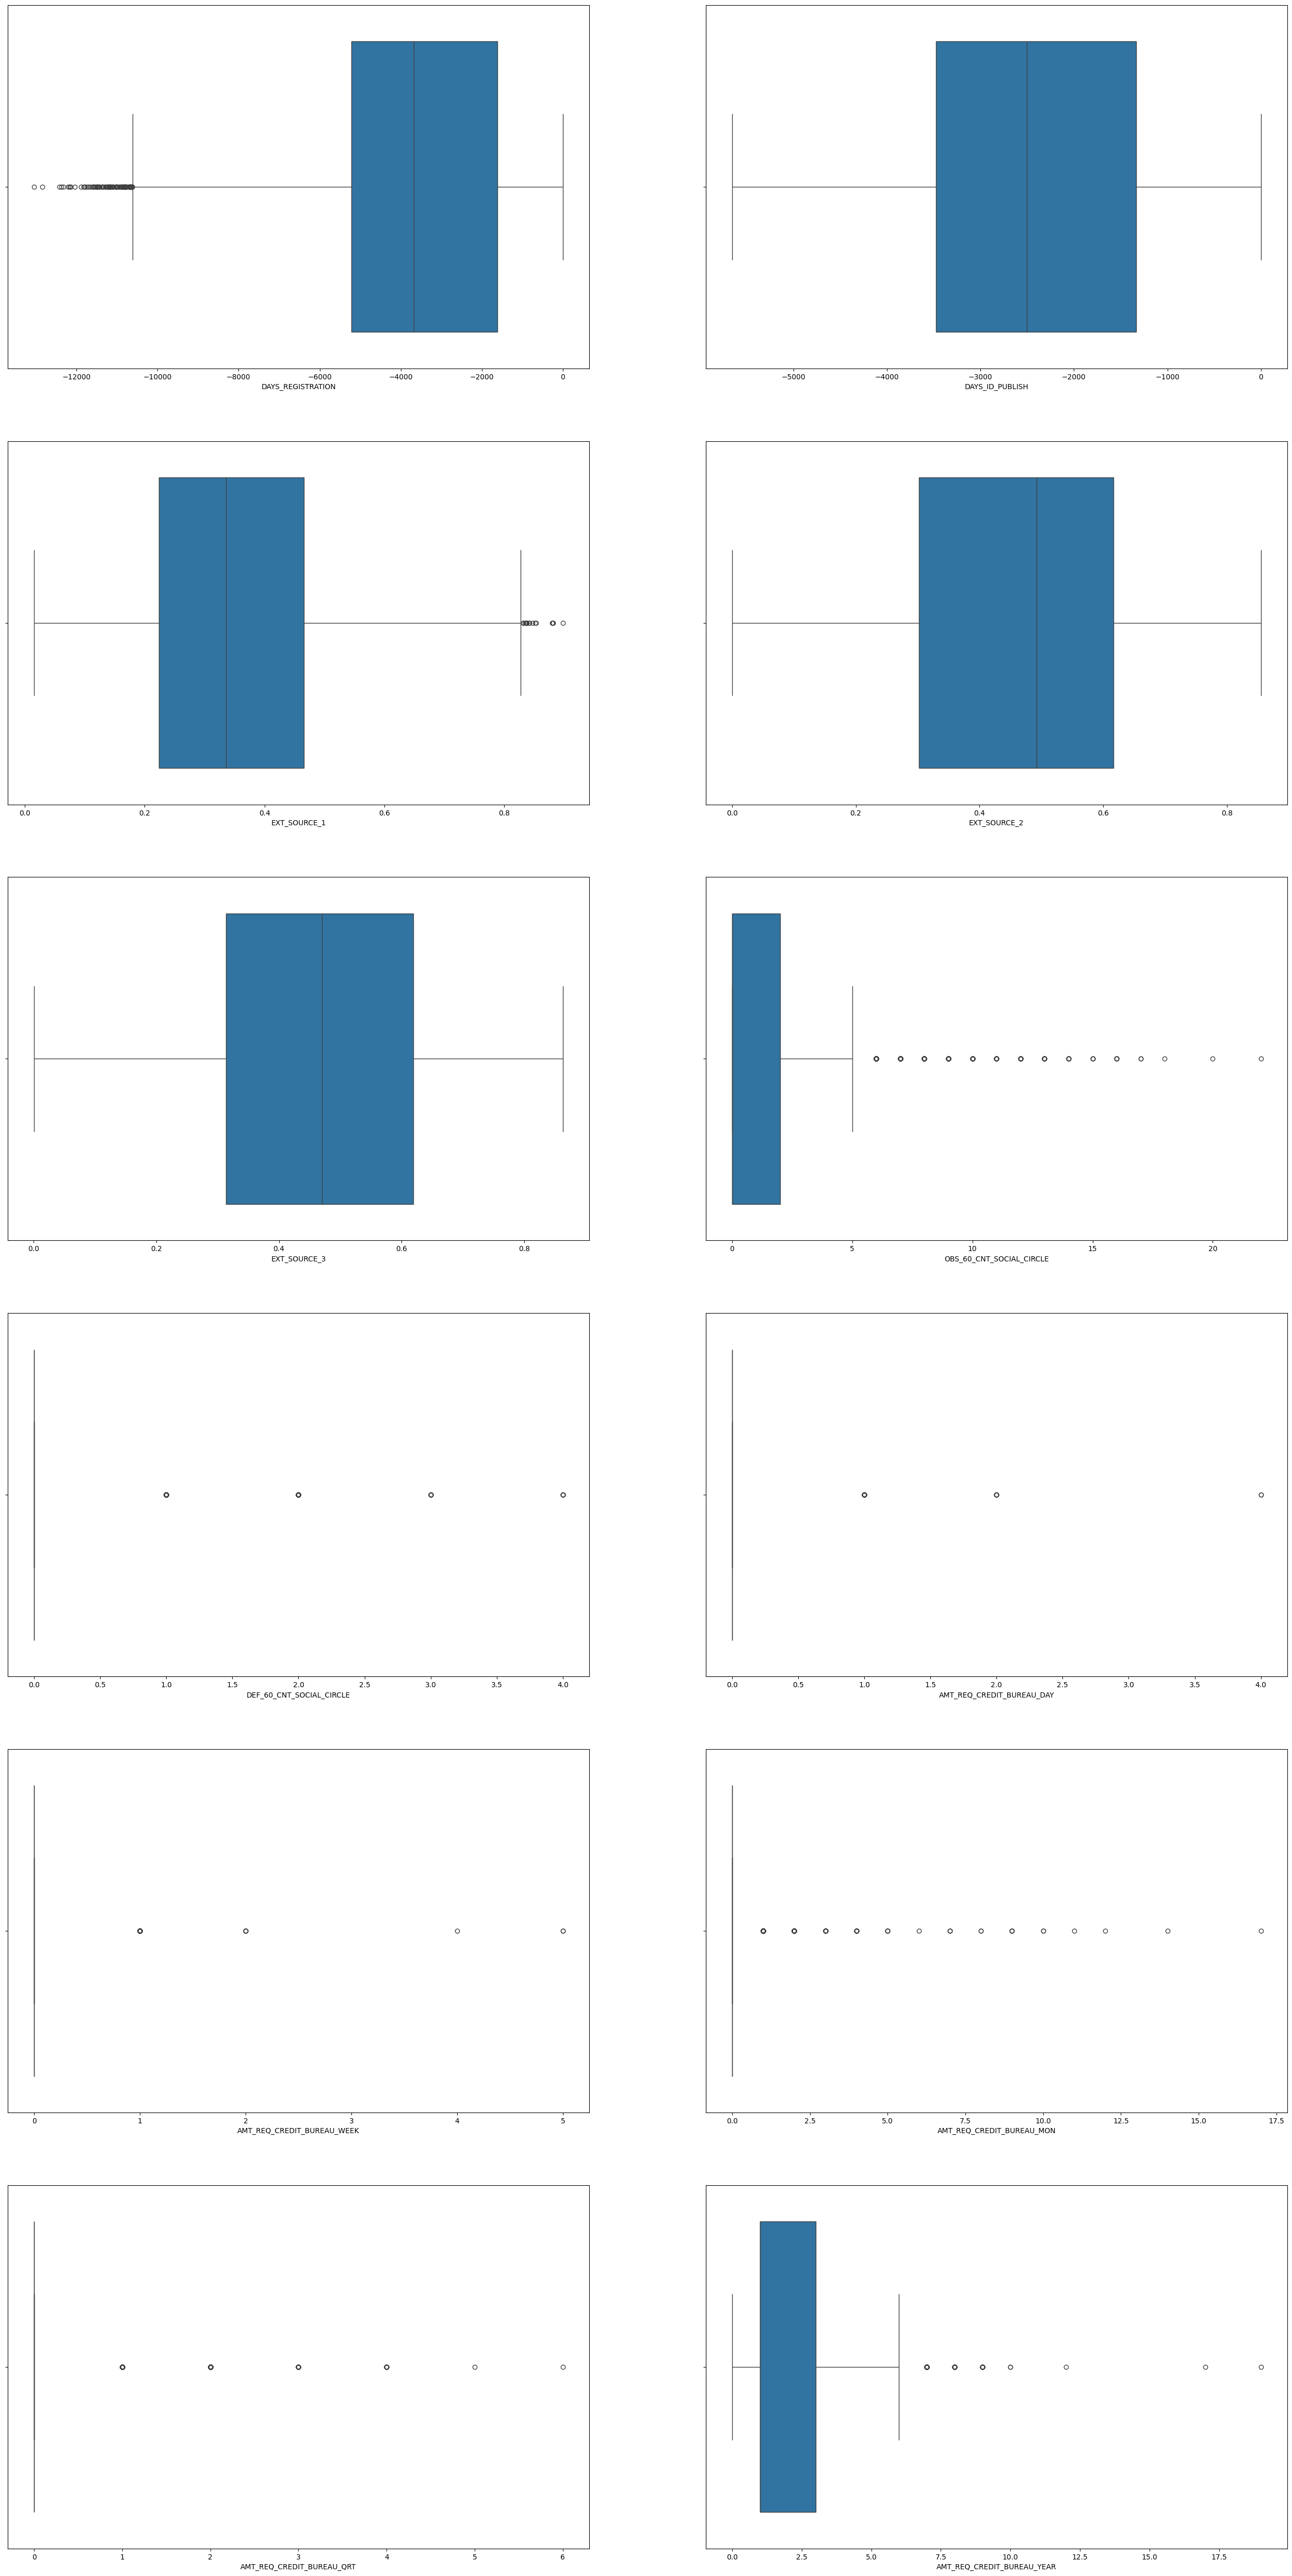

In [679]:
# create boxplots
large_numeric_var = [
                "DAYS_REGISTRATION",
                "DAYS_ID_PUBLISH",
                "EXT_SOURCE_1",
                "EXT_SOURCE_2",
                "EXT_SOURCE_3",
                "OBS_60_CNT_SOCIAL_CIRCLE",
                "DEF_60_CNT_SOCIAL_CIRCLE",
                "AMT_REQ_CREDIT_BUREAU_DAY",
                "AMT_REQ_CREDIT_BUREAU_WEEK",
                "AMT_REQ_CREDIT_BUREAU_MON",
                "AMT_REQ_CREDIT_BUREAU_QRT",
                "AMT_REQ_CREDIT_BUREAU_YEAR"]

row_count=int(np.ceil(len(large_numeric_var)/2))

# create the figure and two subplots
fig, axes = plt.subplots(ncols=2, nrows=row_count, figsize=(32, 64))

for i, axis in enumerate(fig.axes):
    sns.boxplot(ax=axis, data=unclean_merged_data, x = large_numeric_var[i],orient='h')
    axis.set_xlabel(str(large_numeric_var[i]))
    if i == len(large_numeric_var)-1: 
         break

# Show the plot
plt.show()


#### Dropping irrelevant columns with too many outliers

In [680]:
# Dropping columns with too many outliers and irrelevant columns
unclean_merged_data.drop(["OBS_60_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE", "AMT_REQ_CREDIT_BUREAU_HOUR","AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_QRT","AMT_REQ_CREDIT_BUREAU_WEEK", "AMT_REQ_CREDIT_BUREAU_MON", "AMT_REQ_CREDIT_BUREAU_QRT", "AMT_REQ_CREDIT_BUREAU_YEAR","ORGANIZATION_TYPE"], axis=1,inplace=True)
unclean_merged_data

SK_ID_CURR  TARGET FLAG_OWN_CAR FLAG_OWN_REALTY      NAME_INCOME_TYPE  \
22          100026       0            N               N               Working   
35          100041       0            N               N               Working   
45          100052       0            N               Y               Working   
53          100061       0            N               Y  Commercial associate   
77          100089       0            N               Y               Working   
...            ...     ...          ...             ...                   ...   
307353      456078       0            N               Y               Working   
307383      456108       1            N               Y               Working   
307385      456110       0            Y               Y  Commercial associate   
307436      456174       0            N               N               Working   
307457      456196       0            N               Y  Commercial associate   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
22      Secondary / secondary special               Married   
35                   Higher education               Married   
45      Secondary / secondary special        Civil marriage   
53                   Higher education               Married   
77      Secondary / secondary special        Civil marriage   
...                               ...                   ...   
307353  Secondary / secondary special  Single / not married   
307383  Secondary / secondary special               Married   
307385  Secondary / secondary special               Married   
307436  Secondary / secondary special               Married   
307457  Secondary / secondary special        Civil marriage   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_REGISTRATION  ...  \
22       Rented apartment                        0.02            -114.00  ...   
35      House / apartment                        0.01           -6265.00  ...   
45      House / apartment                        0.01           -6591.00  ...   
53      House / apartment                        0.01           -2025.00  ...   
77      House / apartment                        0.03           -4437.00  ...   
...                   ...                         ...                ...  ...   
307353  House / apartment                        0.04           -1822.00  ...   
307383  House / apartment                        0.02           -4771.00  ...   
307385  House / apartment                        0.01             -72.00  ...   
307436  House / apartment                        0.02           -2160.00  ...   
307457  House / apartment                        0.04           -6804.00  ...   

        AGE YEARS_EMPLOYED  AVG_AMT_CREDIT_SUM  AVG_AMT_CREDIT_SUM_DEBT  \
22       30             11          1875000.00               1738907.19   
35       33              3            63254.24                     0.00   
45       21              2                 NaN                      NaN   
53       28              3            37741.50                     0.00   
77       26              7           116545.50                     0.00   
...     ...            ...                 ...                      ...   
307353   23              0                 NaN                      NaN   
307383   34              5           168275.04                108897.75   
307385   34              8          6760620.00               6510321.00   
307436   30              2            64469.25                     0.00   
307457   35              9           125526.27                 24386.85   

        AVG_AMT_CREDIT_SUM_OVERDUE  DEBT_INCOME_RATIO  ACTIVE_LOAN_RATIO  \
22                            0.00               1.11               0.67   
35                            0.00               4.00               0.08   
45                             NaN               2.00                NaN   
53                            0.00               1.40               0.00   
77                      

#### Dropping unncessary columns because of relative to business context
- SK_ID_CURR
- REGION_POPULATION_RELATIVE
- DAYS_REGISTRATION
- DAYS_ID_PUBLISH
- AVG_AMT_CREDIT_SUM
- REGION_RATING_CLIENT

In [681]:
# Drop unnecessary columns mentioned 
unclean_merged_data.drop(["SK_ID_CURR","DAYS_REGISTRATION","DAYS_ID_PUBLISH","AVG_AMT_CREDIT_SUM"], axis=1,inplace=True)
clean_merged_data = unclean_merged_data.copy()

In [682]:
clean_merged_data.columns

Index(['TARGET', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'OCCUPATION_TYPE',
       'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'FLAG_DOCUMENT_3', 'AGE', 'YEARS_EMPLOYED',
       'AVG_AMT_CREDIT_SUM_DEBT', 'AVG_AMT_CREDIT_SUM_OVERDUE',
       'DEBT_INCOME_RATIO', 'ACTIVE_LOAN_RATIO', 'CLOSED_LOAN_RATIO',
       'BAD_DEBT_LOAN_RATIO', 'SOLD_LOAN_RATIO'],
      dtype='object')

In [683]:
len(clean_merged_data.columns)

23

## 3. Grouping and Screening



### 3.1 Fine Classing
#### Generating WOE Bins 
Woebin() generate groupings as a python dictionary object and also provides a method to plot WOE for the bins.  It will optimize for IV, but will not attempt to make the trend monotonic.

Scorecardpy will automatically do the one-hot encoding as part of the binning process so it is not neccesary to do that in advance.

It will also create missing bins for all the variables, so there is no need to imput or remove missing values.

In [684]:
bins = sc.woebin(clean_merged_data, y='TARGET')

# make it easy to read the bins
for variables , bindetails in bins.items():
    print(variables , " : ")
    display(bindetails)
    print("--"*50)

[INFO] creating woe binning ...


/Users/jackyteo/Library/Python/3.9/lib/python/site-packages/scorecardpy/woebin.py:136: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  binning_sv = pd.merge(
/Users/jackyteo/Library/Python/3.9/lib/python/site-packages/scorecardpy/woebin.py:136: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  binning_sv = pd.merge(
/Users/jackyteo/Library/Python/3.9/lib/python/site-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this 

AGE  : 


variable          bin  count  count_distr  good  bad  badprob   woe  bin_iv  \
0      AGE  [-inf,24.0)    859         0.10   721  138     0.16  0.23    0.01   
1      AGE  [24.0,27.0)   1154         0.14  1014  140     0.12 -0.09    0.00   
2      AGE  [27.0,29.0)   1569         0.19  1337  232     0.15  0.14    0.00   
3      AGE  [29.0,35.0)   4082         0.49  3587  495     0.12 -0.09    0.00   
4      AGE   [35.0,inf)    606         0.07   524   82     0.14  0.03    0.00   

   total_iv breaks  is_special_values  
0      0.02   24.0              False  
1      0.02   27.0              False  
2      0.02   29.0              False  
3      0.02   35.0              False  
4      0.02    inf              False

----------------------------------------------------------------------------------------------------
AVG_AMT_CREDIT_SUM_DEBT  : 


variable                 bin  count  count_distr  good  bad  \
0  AVG_AMT_CREDIT_SUM_DEBT             missing   1999         0.24  1703  296   
1  AVG_AMT_CREDIT_SUM_DEBT      [-inf,40000.0)   3613         0.44  3238  375   
2  AVG_AMT_CREDIT_SUM_DEBT   [40000.0,90000.0)    986         0.12   839  147   
3  AVG_AMT_CREDIT_SUM_DEBT  [90000.0,310000.0)   1152         0.14   941  211   
4  AVG_AMT_CREDIT_SUM_DEBT      [310000.0,inf)    520         0.06   462   58   

   badprob   woe  bin_iv  total_iv    breaks  is_special_values  
0     0.15  0.14    0.00      0.06   missing               True  
1     0.10 -0.27    0.03      0.06   40000.0              False  
2     0.15  0.15    0.00      0.06   90000.0              False  
3     0.18  0.39    0.02      0.06  310000.0              False  
4     0.11 -0.19    0.00      0.06       inf              False

----------------------------------------------------------------------------------------------------
OCCUPATION_TYPE  : 


variable                                                bin  count  \
0  OCCUPATION_TYPE                                            missing    739   
1  OCCUPATION_TYPE  IT staff%,%Medicine staff%,%Accountants%,%Core...   1241   
2  OCCUPATION_TYPE                           Managers%,%Realty agents    441   
3  OCCUPATION_TYPE  High skill tech staff%,%Sales staff%,%Cooking ...   3376   
4  OCCUPATION_TYPE                                           Laborers   1474   
5  OCCUPATION_TYPE  Drivers%,%Security staff%,%Secretaries%,%Waite...    999   

   count_distr  good  bad  badprob   woe  bin_iv  total_iv  \
0         0.09   643   96     0.13 -0.01    0.00      0.07   
1         0.15  1140  101     0.08 -0.54    0.04      0.07   
2         0.05   393   48     0.11 -0.21    0.00      0.07   
3         0.41  2951  425     0.13 -0.05    0.00      0.07   
4         0.18  1251  223     0.15  0.16    0.01      0.07   
5         0.12   805  194     0.19  0.47    0.03      0.07   

                                              breaks  is_special_values  
0                                            missing               True  
1  IT staff%,%Medicine staff%,%Accountants%,%Core...              False  
2                           Managers%,%Realty agents              False  
3  High skill tech staff%,%Sales staff%,%Cooking ...              False  
4                                           Laborers              False  
5  Drivers%,%Security staff%,%Secretaries%,%Waite...              False

----------------------------------------------------------------------------------------------------
REGION_POPULATION_RELATIVE  : 


variable            bin  count  count_distr  good  bad  \
0  REGION_POPULATION_RELATIVE   [-inf,0.005)    463         0.06   383   80   
1  REGION_POPULATION_RELATIVE  [0.005,0.021)   5246         0.63  4507  739   
2  REGION_POPULATION_RELATIVE  [0.021,0.027)    862         0.10   780   82   
3  REGION_POPULATION_RELATIVE  [0.027,0.031)    702         0.08   602  100   
4  REGION_POPULATION_RELATIVE    [0.031,inf)    997         0.12   911   86   

   badprob   woe  bin_iv  total_iv breaks  is_special_values  
0     0.17  0.32    0.01      0.05  0.005              False  
1     0.14  0.08    0.00      0.05  0.021              False  
2     0.10 -0.36    0.01      0.05  0.027              False  
3     0.14  0.09    0.00      0.05  0.031              False  
4     0.09 -0.47    0.02      0.05    inf              False

----------------------------------------------------------------------------------------------------
AVG_AMT_CREDIT_SUM_OVERDUE  : 


variable         bin  count  count_distr  good  bad  \
0  AVG_AMT_CREDIT_SUM_OVERDUE     missing   1809         0.22  1529  280   
1  AVG_AMT_CREDIT_SUM_OVERDUE  [-inf,inf)   6461         0.78  5654  807   

   badprob   woe  bin_iv  total_iv   breaks  is_special_values  
0     0.15  0.19    0.01      0.01  missing               True  
1     0.12 -0.06    0.00      0.01      inf              False

----------------------------------------------------------------------------------------------------
NAME_HOUSING_TYPE  : 


variable                                                bin  \
0  NAME_HOUSING_TYPE  Co-op apartment%,%Office apartment%,%House / a...   
1  NAME_HOUSING_TYPE  Rented apartment%,%With parents%,%Municipal ap...   

   count  count_distr  good  bad  badprob   woe  bin_iv  total_iv  \
0   6694         0.81  5850  844     0.13 -0.05    0.00      0.01   
1   1576         0.19  1333  243     0.15  0.19    0.01      0.01   

                                              breaks  is_special_values  
0  Co-op apartment%,%Office apartment%,%House / a...              False  
1  Rented apartment%,%With parents%,%Municipal ap...              False

----------------------------------------------------------------------------------------------------
CLOSED_LOAN_RATIO  : 


variable          bin  count  count_distr  good  bad  badprob  \
0  CLOSED_LOAN_RATIO      missing   1809         0.22  1529  280     0.15   
1  CLOSED_LOAN_RATIO  [-inf,0.48)   2181         0.26  1818  363     0.17   
2  CLOSED_LOAN_RATIO   [0.48,0.8)   2433         0.29  2145  288     0.12   
3  CLOSED_LOAN_RATIO   [0.8,0.92)    482         0.06   452   30     0.06   
4  CLOSED_LOAN_RATIO   [0.92,inf)   1365         0.17  1239  126     0.09   

    woe  bin_iv  total_iv   breaks  is_special_values  
0  0.19    0.01      0.09  missing               True  
1  0.28    0.02      0.09     0.48              False  
2 -0.12    0.00      0.09      0.8              False  
3 -0.82    0.03      0.09     0.92              False  
4 -0.40    0.02      0.09      inf              False

----------------------------------------------------------------------------------------------------
ACTIVE_LOAN_RATIO  : 


variable          bin  count  count_distr  good  bad  badprob  \
0  ACTIVE_LOAN_RATIO      missing   1809         0.22  1529  280     0.15   
1  ACTIVE_LOAN_RATIO  [-inf,0.08)   1380         0.17  1251  129     0.09   
2  ACTIVE_LOAN_RATIO  [0.08,0.22)    499         0.06   468   31     0.06   
3  ACTIVE_LOAN_RATIO  [0.22,0.52)   2437         0.29  2148  289     0.12   
4  ACTIVE_LOAN_RATIO   [0.52,inf)   2145         0.26  1787  358     0.17   

    woe  bin_iv  total_iv   breaks  is_special_values  
0  0.19    0.01      0.09  missing               True  
1 -0.38    0.02      0.09     0.08              False  
2 -0.83    0.03      0.09     0.22              False  
3 -0.12    0.00      0.09     0.52              False  
4  0.28    0.02      0.09      inf              False

----------------------------------------------------------------------------------------------------
FLAG_OWN_REALTY  : 


variable bin  count  count_distr  good  bad  badprob   woe  bin_iv  \
0  FLAG_OWN_REALTY   Y   5280         0.64  4600  680     0.13 -0.02    0.00   
1  FLAG_OWN_REALTY   N   2990         0.36  2583  407     0.14  0.04    0.00   

   total_iv breaks  is_special_values  
0      0.00      Y              False  
1      0.00      N              False

----------------------------------------------------------------------------------------------------
DEBT_INCOME_RATIO  : 


variable                                      bin  count  \
0  DEBT_INCOME_RATIO                [-inf,1.2000000000000002)   1253   
1  DEBT_INCOME_RATIO                 [1.2000000000000002,2.7)   4501   
2  DEBT_INCOME_RATIO                 [2.7,3.0000000000000004)    698   
3  DEBT_INCOME_RATIO  [3.0000000000000004,3.4000000000000004)    616   
4  DEBT_INCOME_RATIO                 [3.4000000000000004,inf)   1202   

   count_distr  good  bad  badprob   woe  bin_iv  total_iv  \
0         0.15  1137  116     0.09 -0.39    0.02      0.04   
1         0.54  3900  601     0.13  0.02    0.00      0.04   
2         0.08   619   79     0.11 -0.17    0.00      0.04   
3         0.07   501  115     0.19  0.42    0.02      0.04   
4         0.15  1026  176     0.15  0.13    0.00      0.04   

               breaks  is_special_values  
0  1.2000000000000002              False  
1                 2.7              False  
2  3.0000000000000004              False  
3  3.4000000000000004              False  
4                 inf              False

----------------------------------------------------------------------------------------------------
FLAG_OWN_CAR  : 


variable bin  count  count_distr  good  bad  badprob   woe  bin_iv  \
0  FLAG_OWN_CAR   Y   2823         0.34  2518  305     0.11 -0.22    0.02   
1  FLAG_OWN_CAR   N   5447         0.66  4665  782     0.14  0.10    0.01   

   total_iv breaks  is_special_values  
0      0.02      Y              False  
1      0.02      N              False

----------------------------------------------------------------------------------------------------
EXT_SOURCE_2  : 


variable          bin  count  count_distr  good  bad  badprob   woe  \
0  EXT_SOURCE_2      missing     19         0.00    17    2     0.11 -0.25   
1  EXT_SOURCE_2  [-inf,0.08)    454         0.05   321  133     0.29  1.01   
2  EXT_SOURCE_2  [0.08,0.34)   1926         0.23  1555  371     0.19  0.46   
3  EXT_SOURCE_2  [0.34,0.66)   4625         0.56  4125  500     0.11 -0.22   
4  EXT_SOURCE_2   [0.66,inf)   1246         0.15  1165   81     0.07 -0.78   

   bin_iv  total_iv   breaks  is_special_values  
0    0.00      0.23  missing               True  
1    0.08      0.23     0.08              False  
2    0.06      0.23     0.34              False  
3    0.03      0.23     0.66              False  
4    0.07      0.23      inf              False

----------------------------------------------------------------------------------------------------
NAME_EDUCATION_TYPE  : 


variable                                              bin  \
0  NAME_EDUCATION_TYPE               Academic degree%,%Higher education   
1  NAME_EDUCATION_TYPE                                Incomplete higher   
2  NAME_EDUCATION_TYPE  Secondary / secondary special%,%Lower secondary   

   count  count_distr  good  bad  badprob   woe  bin_iv  total_iv  \
0   1553         0.19  1430  123     0.08 -0.56    0.05      0.06   
1    556         0.07   479   77     0.14  0.06    0.00      0.06   
2   6161         0.74  5274  887     0.14  0.11    0.01      0.06   

                                            breaks  is_special_values  
0               Academic degree%,%Higher education              False  
1                                Incomplete higher              False  
2  Secondary / secondary special%,%Lower secondary              False

----------------------------------------------------------------------------------------------------
FLAG_DOCUMENT_3  : 


variable         bin  count  count_distr  good  bad  badprob   woe  \
0  FLAG_DOCUMENT_3  [-inf,1.0)   2440         0.30  2199  241     0.10 -0.32   
1  FLAG_DOCUMENT_3   [1.0,inf)   5830         0.70  4984  846     0.15  0.11   

   bin_iv  total_iv breaks  is_special_values  
0    0.03      0.04    1.0              False  
1    0.01      0.04    inf              False

----------------------------------------------------------------------------------------------------
REGION_RATING_CLIENT_W_CITY  : 


variable         bin  count  count_distr  good  bad  \
0  REGION_RATING_CLIENT_W_CITY  [-inf,3.0)   6863         0.83  6037  826   
1  REGION_RATING_CLIENT_W_CITY   [3.0,inf)   1407         0.17  1146  261   

   badprob   woe  bin_iv  total_iv breaks  is_special_values  
0     0.12 -0.10    0.01      0.04    3.0              False  
1     0.19  0.41    0.03      0.04    inf              False

----------------------------------------------------------------------------------------------------
BAD_DEBT_LOAN_RATIO  : 


variable         bin  count  count_distr  good  bad  badprob  \
0  BAD_DEBT_LOAN_RATIO     missing   1809         0.22  1529  280     0.15   
1  BAD_DEBT_LOAN_RATIO  [-inf,inf)   6461         0.78  5654  807     0.12   

    woe  bin_iv  total_iv   breaks  is_special_values  
0  0.19    0.01      0.01  missing               True  
1 -0.06    0.00      0.01      inf              False

----------------------------------------------------------------------------------------------------
EXT_SOURCE_1  : 


variable          bin  count  count_distr  good  bad  badprob   woe  \
0  EXT_SOURCE_1      missing   3569         0.43  3015  554     0.16  0.19   
1  EXT_SOURCE_1  [-inf,0.18)    737         0.09   577  160     0.22  0.61   
2  EXT_SOURCE_1  [0.18,0.44)   2596         0.31  2294  302     0.12 -0.14   
3  EXT_SOURCE_1  [0.44,0.52)    520         0.06   485   35     0.07 -0.74   
4  EXT_SOURCE_1   [0.52,inf)    848         0.10   812   36     0.04 -1.23   

   bin_iv  total_iv   breaks  is_special_values  
0    0.02      0.19  missing               True  
1    0.04      0.19     0.18              False  
2    0.01      0.19     0.44              False  
3    0.03      0.19     0.52              False  
4    0.10      0.19      inf              False

----------------------------------------------------------------------------------------------------
NAME_INCOME_TYPE  : 


variable                                   bin  count  count_distr  \
0  NAME_INCOME_TYPE  State servant%,%Commercial associate   2186         0.26   
1  NAME_INCOME_TYPE                               Working   6084         0.74   

   good  bad  badprob   woe  bin_iv  total_iv  \
0  1943  243     0.11 -0.19    0.01      0.01   
1  5240  844     0.14  0.06    0.00      0.01   

                                 breaks  is_special_values  
0  State servant%,%Commercial associate              False  
1                               Working              False

----------------------------------------------------------------------------------------------------
NAME_FAMILY_STATUS  : 


variable                               bin  count  count_distr  \
0  NAME_FAMILY_STATUS                   Widow%,%Married   4629         0.56   
1  NAME_FAMILY_STATUS                    Civil marriage   1153         0.14   
2  NAME_FAMILY_STATUS  Single / not married%,%Separated   2488         0.30   

   good  bad  badprob   woe  bin_iv  total_iv  \
0  4083  546     0.12 -0.12    0.01      0.02   
1   987  166     0.14  0.11    0.00      0.02   
2  2113  375     0.15  0.16    0.01      0.02   

                             breaks  is_special_values  
0                   Widow%,%Married              False  
1                    Civil marriage              False  
2  Single / not married%,%Separated              False

----------------------------------------------------------------------------------------------------
EXT_SOURCE_3  : 


variable          bin  count  count_distr  good  bad  badprob   woe  \
0  EXT_SOURCE_3      missing   2455         0.30  2109  346     0.14  0.08   
1  EXT_SOURCE_3  [-inf,0.26)   1048         0.13   788  260     0.25  0.78   
2  EXT_SOURCE_3  [0.26,0.46)   1766         0.21  1512  254     0.14  0.10   
3  EXT_SOURCE_3  [0.46,0.68)   2111         0.26  1924  187     0.09 -0.44   
4  EXT_SOURCE_3  [0.68,0.74)    452         0.05   427   25     0.06 -0.95   
5  EXT_SOURCE_3   [0.74,inf)    438         0.05   423   15     0.03 -1.45   

   bin_iv  total_iv   breaks  is_special_values  
0    0.00      0.25  missing               True  
1    0.10      0.25     0.26              False  
2    0.00      0.25     0.46              False  
3    0.04      0.25     0.68              False  
4    0.03      0.25     0.74              False  
5    0.07      0.25      inf              False

----------------------------------------------------------------------------------------------------
YEARS_EMPLOYED  : 


variable         bin  count  count_distr  good  bad  badprob   woe  \
0  YEARS_EMPLOYED  [-inf,5.0)   6062         0.73  5188  874     0.14  0.11   
1  YEARS_EMPLOYED   [5.0,8.0)   1428         0.17  1280  148     0.10 -0.27   
2  YEARS_EMPLOYED   [8.0,inf)    780         0.09   715   65     0.08 -0.51   

   bin_iv  total_iv breaks  is_special_values  
0    0.01      0.04    5.0              False  
1    0.01      0.04    8.0              False  
2    0.02      0.04    inf              False

----------------------------------------------------------------------------------------------------
SOLD_LOAN_RATIO  : 


variable         bin  count  count_distr  good  bad  badprob   woe  \
0  SOLD_LOAN_RATIO     missing   1809         0.22  1529  280     0.15  0.19   
1  SOLD_LOAN_RATIO  [-inf,inf)   6461         0.78  5654  807     0.12 -0.06   

   bin_iv  total_iv   breaks  is_special_values  
0    0.01      0.01  missing               True  
1    0.00      0.01      inf              False

----------------------------------------------------------------------------------------------------


{'AGE': <Figure size 640x480 with 2 Axes>,
 'AVG_AMT_CREDIT_SUM_DEBT': <Figure size 640x480 with 2 Axes>,
 'OCCUPATION_TYPE': <Figure size 640x480 with 2 Axes>,
 'REGION_POPULATION_RELATIVE': <Figure size 640x480 with 2 Axes>,
 'AVG_AMT_CREDIT_SUM_OVERDUE': <Figure size 640x480 with 2 Axes>,
 'NAME_HOUSING_TYPE': <Figure size 640x480 with 2 Axes>,
 'CLOSED_LOAN_RATIO': <Figure size 640x480 with 2 Axes>,
 'ACTIVE_LOAN_RATIO': <Figure size 640x480 with 2 Axes>,
 'FLAG_OWN_REALTY': <Figure size 640x480 with 2 Axes>,
 'DEBT_INCOME_RATIO': <Figure size 640x480 with 2 Axes>,
 'FLAG_OWN_CAR': <Figure size 640x480 with 2 Axes>,
 'EXT_SOURCE_2': <Figure size 640x480 with 2 Axes>,
 'NAME_EDUCATION_TYPE': <Figure size 640x480 with 2 Axes>,
 'FLAG_DOCUMENT_3': <Figure size 640x480 with 2 Axes>,
 'REGION_RATING_CLIENT_W_CITY': <Figure size 640x480 with 2 Axes>,
 'BAD_DEBT_LOAN_RATIO': <Figure size 640x480 with 2 Axes>,
 'EXT_SOURCE_1': <Figure size 640x480 with 2 Axes>,
 'NAME_INCOME_TYPE': <Figure

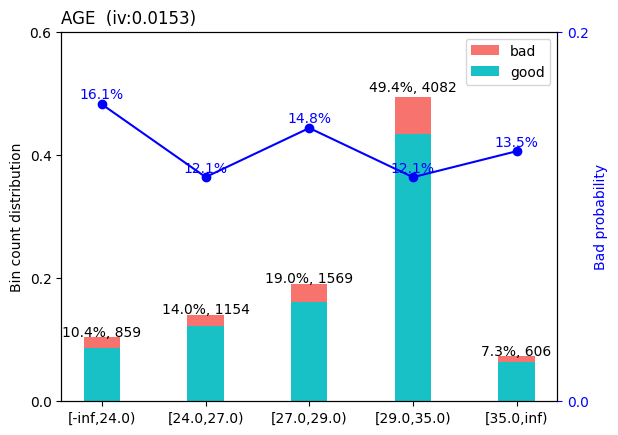

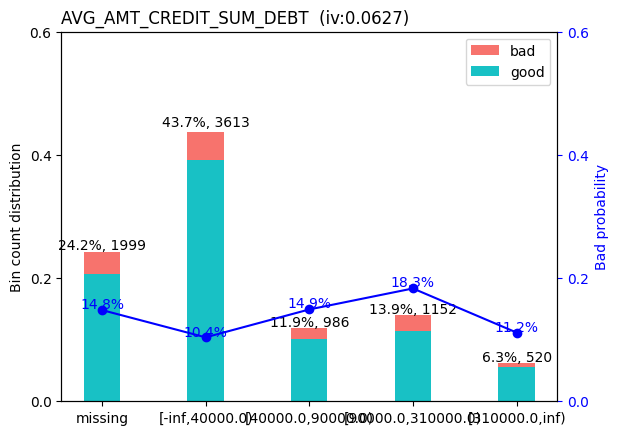

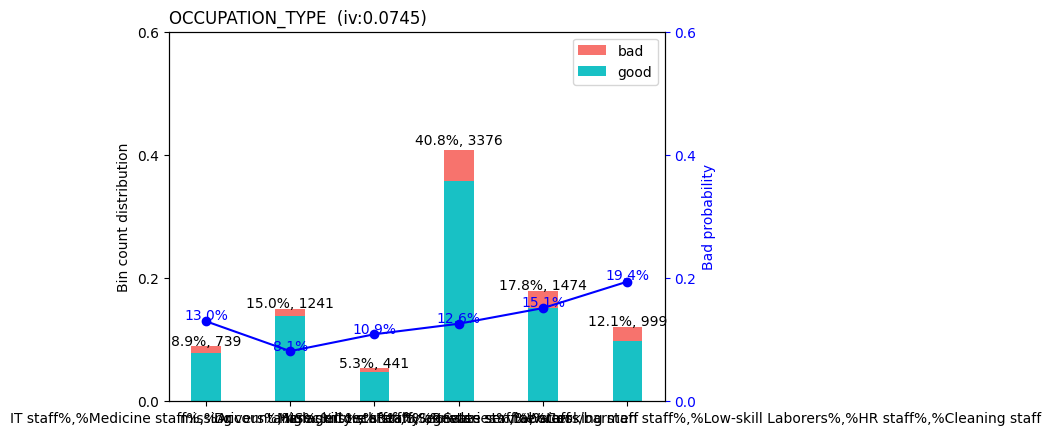

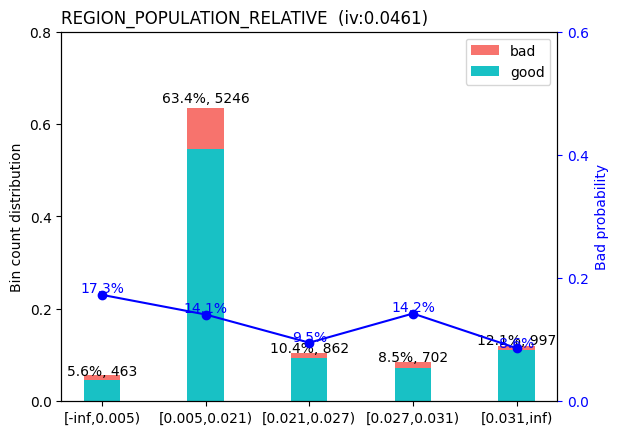

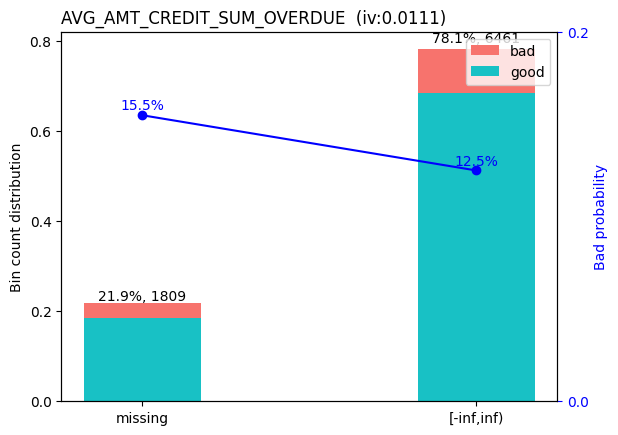

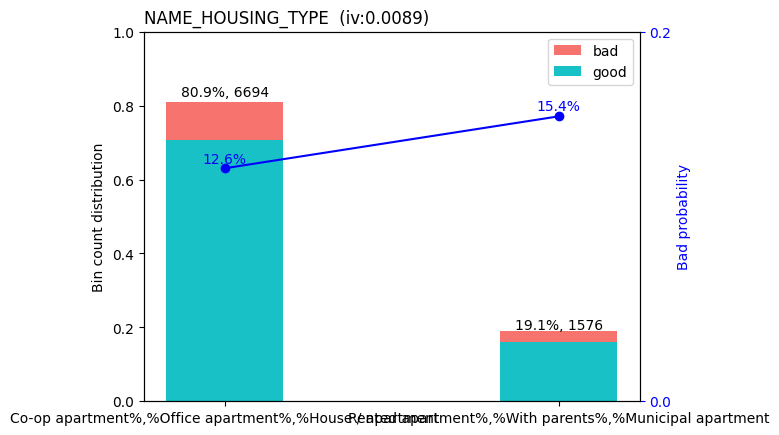

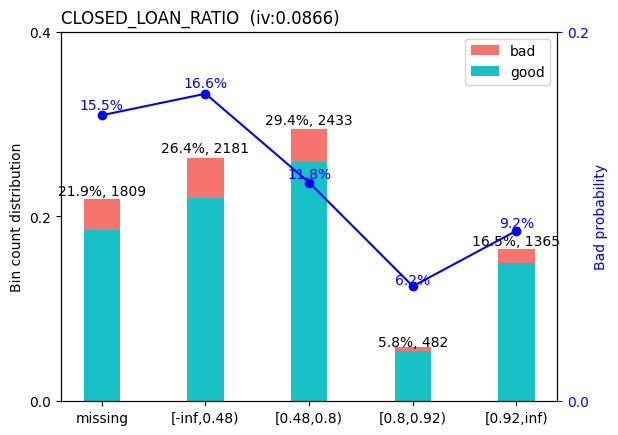

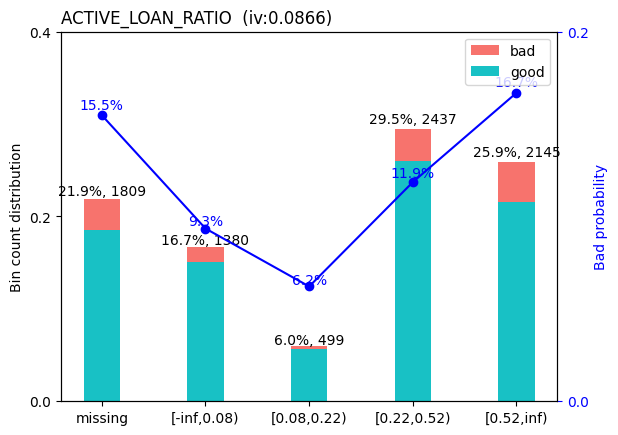

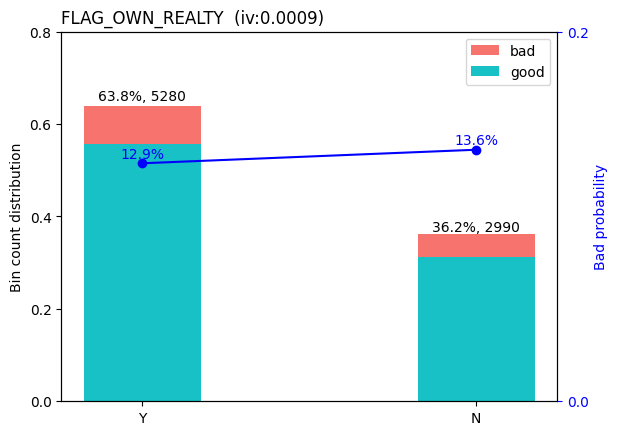

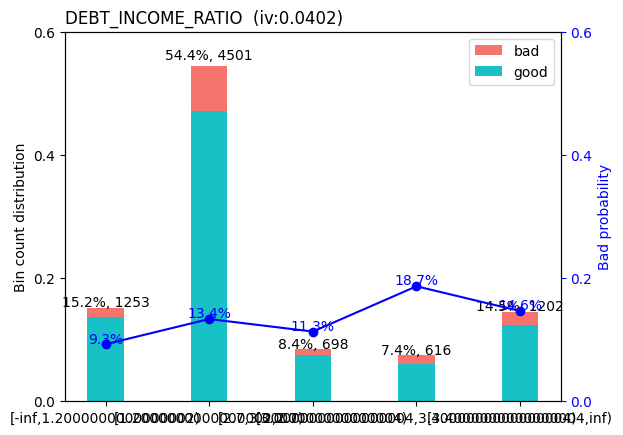

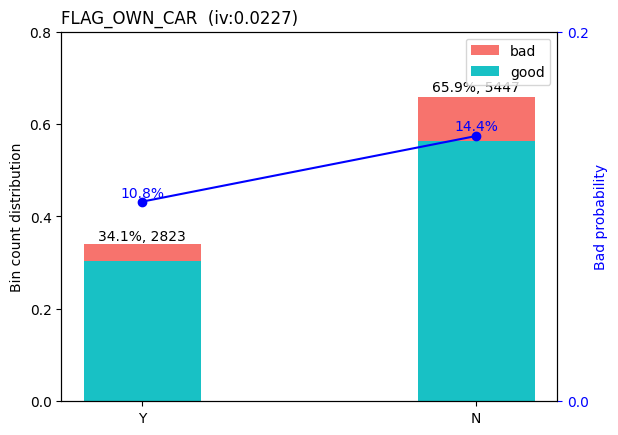

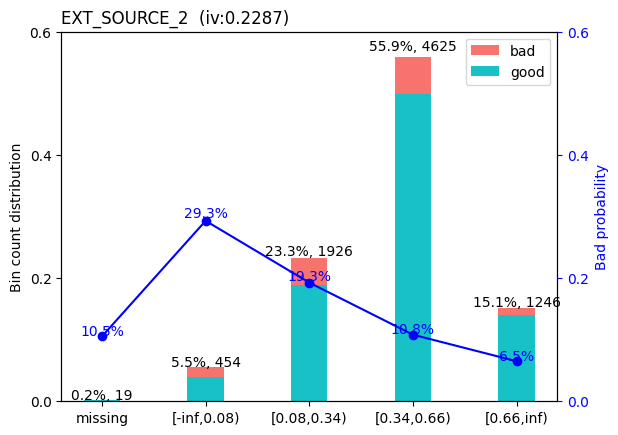

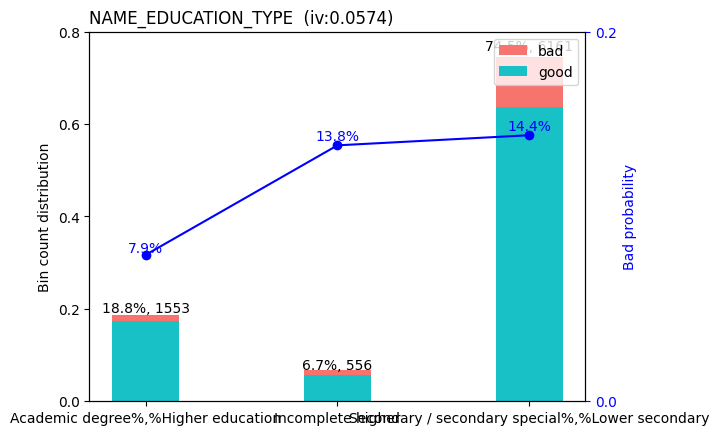

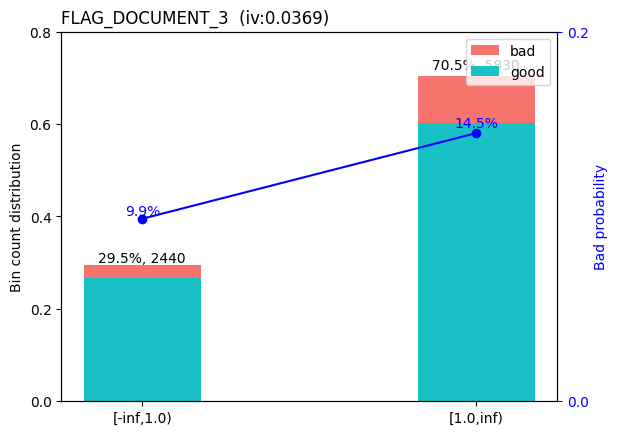

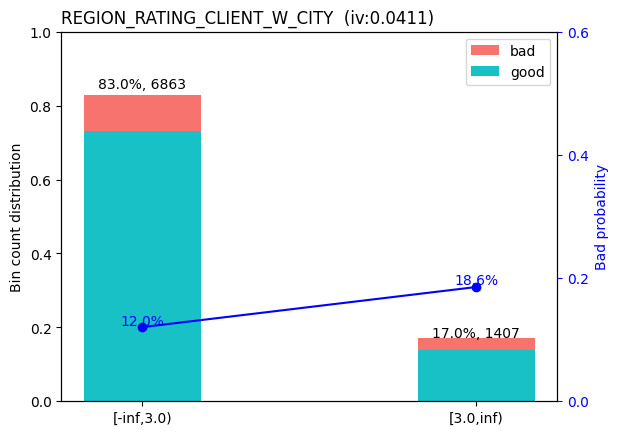

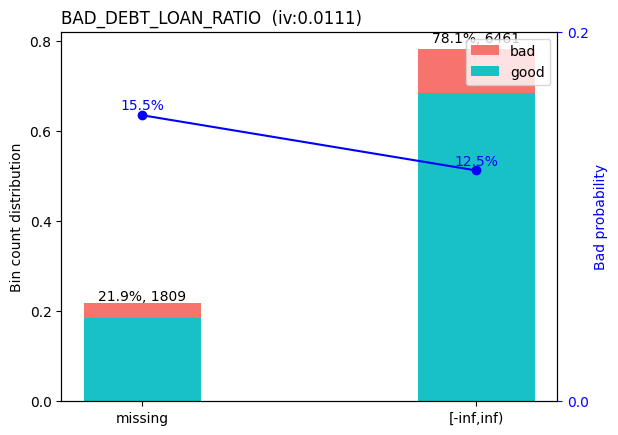

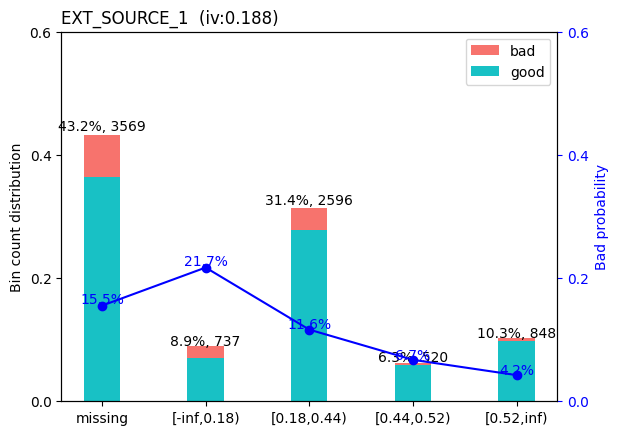

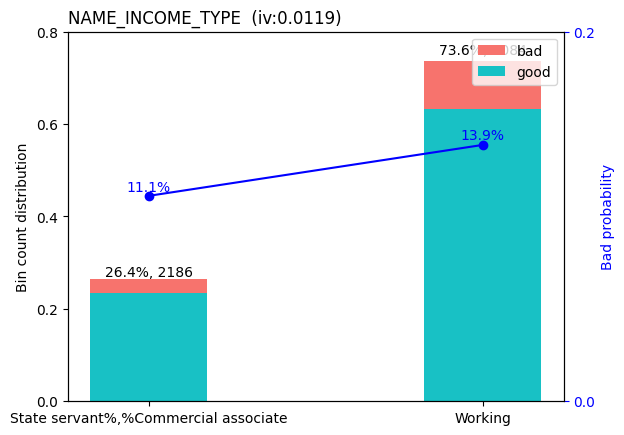

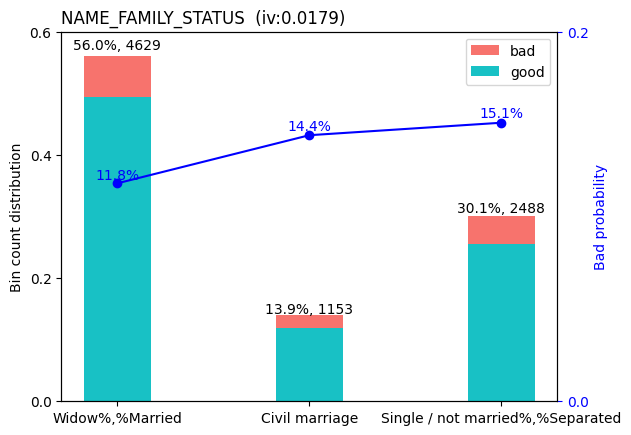

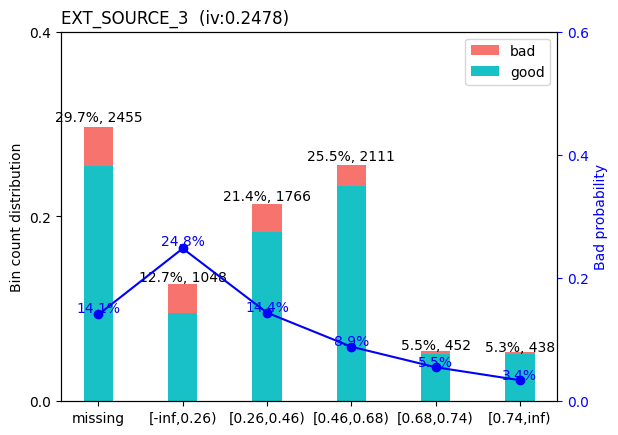

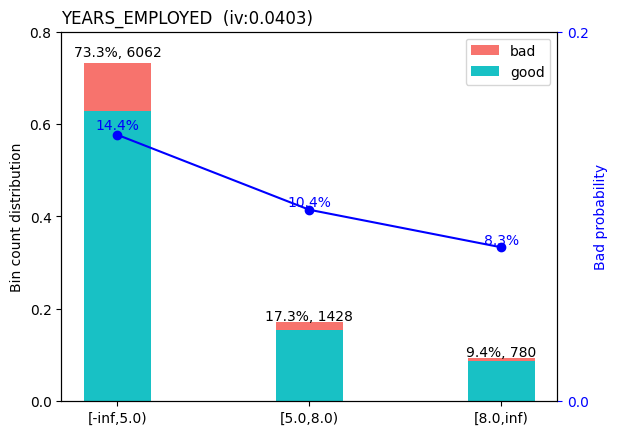

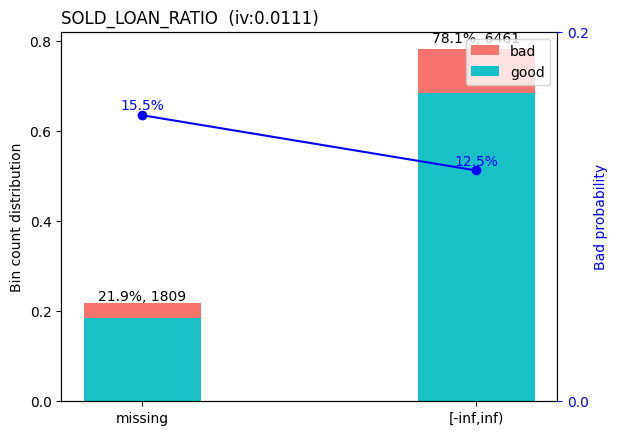

In [685]:
sc.woebin_plot(bins)

### Extract columns with IV <= 0.03
| Variable                  | Information Value |
|---------------------------|-------------------|
| NAME_FAMILY_STATUS        | 0.0178            |
| FLAG_OWN_CAR              | 0.0228            |
| NAME_INCOME_TYPE          | 0.0119            |
| AGE                       | 0.0152            |
| NAME_HOUSING_TYPE         | 0.0089            |
| FLAG_OWN_REALTY           | 0.001             |
| AVG_AMT_CREDIT_SUM_OVERDUE | 0.0112            |
| SOLD_LOAN_RATIO | 0.0111        |
| BAD_DEBT_LOAN_RATIO | 0.0111        |

In [686]:
## Drop variable with IV < 0.03
columns_to_drop = ["NAME_FAMILY_STATUS","FLAG_OWN_CAR","NAME_INCOME_TYPE","AGE","NAME_HOUSING_TYPE","FLAG_OWN_REALTY","AVG_AMT_CREDIT_SUM_OVERDUE","SOLD_LOAN_RATIO","BAD_DEBT_LOAN_RATIO"]

for col in columns_to_drop:
    clean_merged_data.drop(col, axis=1, inplace=True)

clean_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8270 entries, 22 to 307457
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   TARGET                       8270 non-null   int64  
 1   NAME_EDUCATION_TYPE          8270 non-null   object 
 2   REGION_POPULATION_RELATIVE   8270 non-null   float64
 3   OCCUPATION_TYPE              7531 non-null   object 
 4   REGION_RATING_CLIENT_W_CITY  8270 non-null   int64  
 5   EXT_SOURCE_1                 4701 non-null   float64
 6   EXT_SOURCE_2                 8251 non-null   float64
 7   EXT_SOURCE_3                 5815 non-null   float64
 8   FLAG_DOCUMENT_3              8270 non-null   int64  
 9   YEARS_EMPLOYED               8270 non-null   int64  
 10  AVG_AMT_CREDIT_SUM_DEBT      6271 non-null   float64
 11  DEBT_INCOME_RATIO            8270 non-null   float64
 12  ACTIVE_LOAN_RATIO            6461 non-null   float64
 13  CLOSED_LOAN_RATIO   

## 3.2 Coarse Classing

#### Manual adjustment of sc.woebin groupings

[INFO] creating woe binning ...


/Users/jackyteo/Library/Python/3.9/lib/python/site-packages/scorecardpy/woebin.py:361: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  init_bin = init_bin.groupby('brkp', group_keys=False).agg({
/Users/jackyteo/Library/Python/3.9/lib/python/site-packages/scorecardpy/woebin.py:410: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  total_iv_all_brks = pd.melt(
/Users/jackyteo/Library/Python/3.9/lib/python/site-packages/scorecardpy/woebin.py:410: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep c

{'EXT_SOURCE_2': <Figure size 640x480 with 2 Axes>,
 'AVG_AMT_CREDIT_SUM_DEBT': <Figure size 640x480 with 2 Axes>,
 'NAME_EDUCATION_TYPE': <Figure size 640x480 with 2 Axes>,
 'OCCUPATION_TYPE': <Figure size 640x480 with 2 Axes>,
 'REGION_RATING_CLIENT_W_CITY': <Figure size 640x480 with 2 Axes>,
 'REGION_POPULATION_RELATIVE': <Figure size 640x480 with 2 Axes>,
 'EXT_SOURCE_1': <Figure size 640x480 with 2 Axes>,
 'FLAG_DOCUMENT_3': <Figure size 640x480 with 2 Axes>,
 'CLOSED_LOAN_RATIO': <Figure size 640x480 with 2 Axes>,
 'ACTIVE_LOAN_RATIO': <Figure size 640x480 with 2 Axes>,
 'EXT_SOURCE_3': <Figure size 640x480 with 2 Axes>,
 'YEARS_EMPLOYED': <Figure size 640x480 with 2 Axes>,
 'DEBT_INCOME_RATIO': <Figure size 640x480 with 2 Axes>}

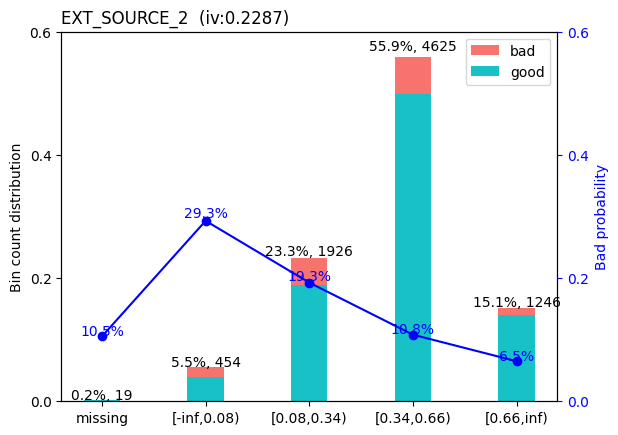

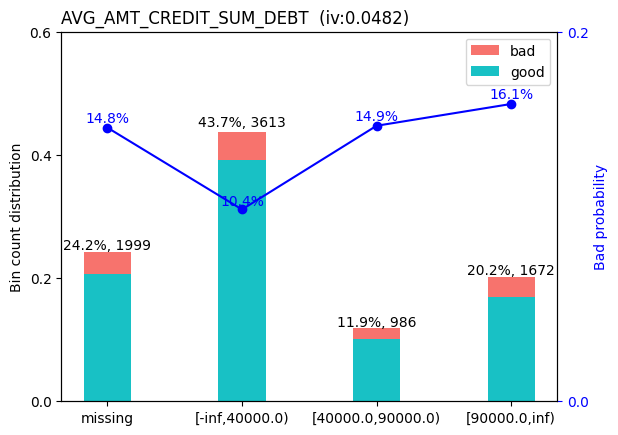

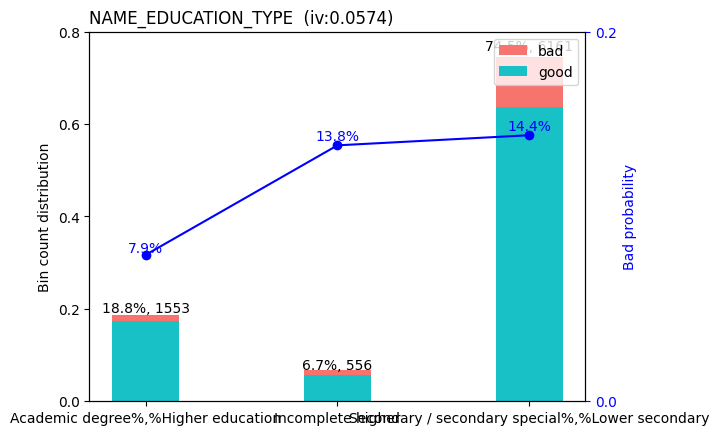

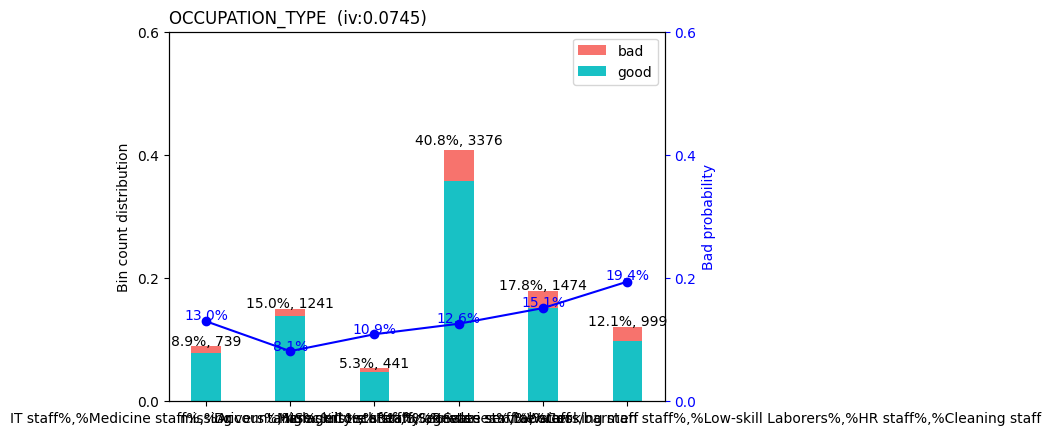

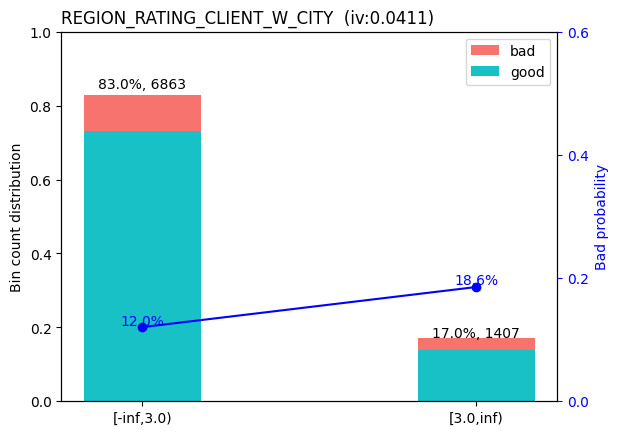

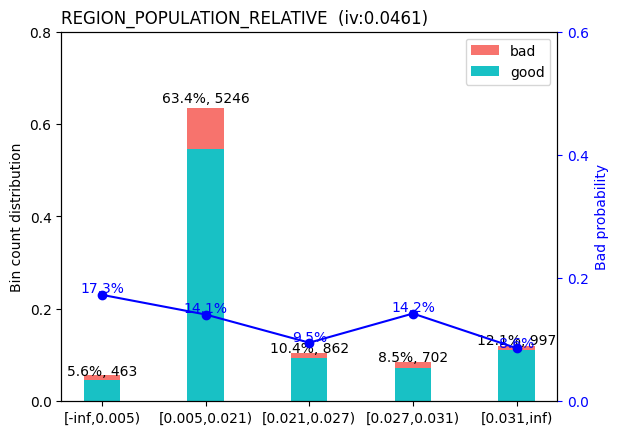

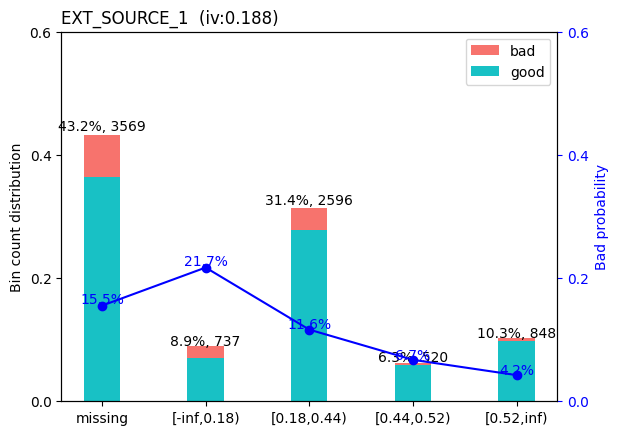

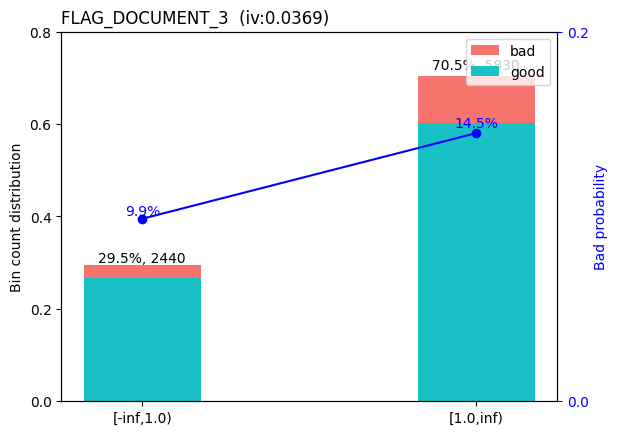

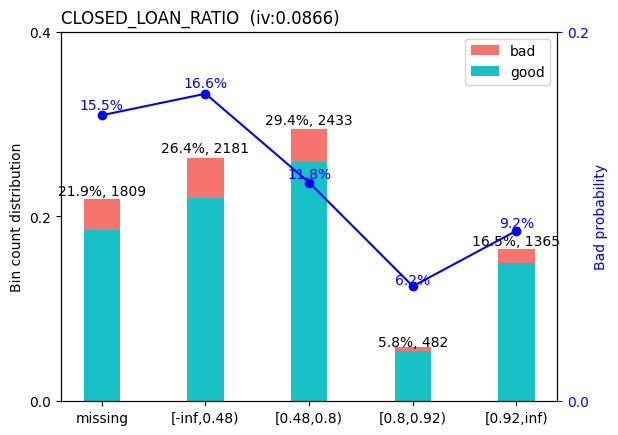

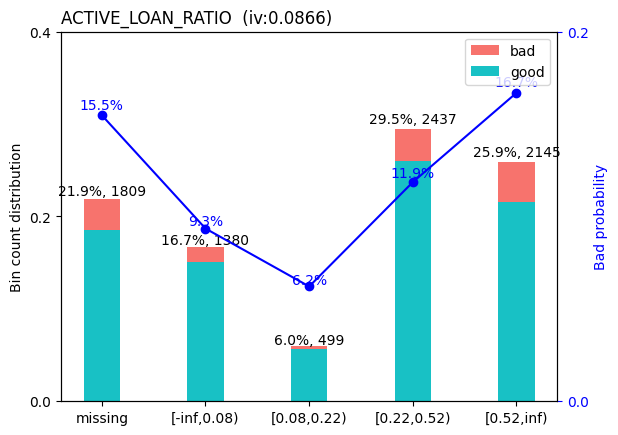

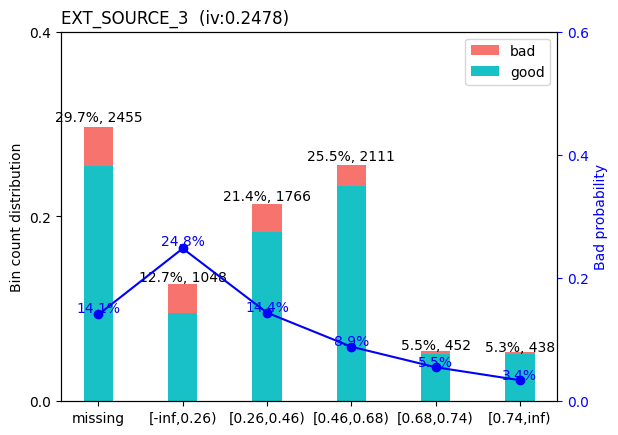

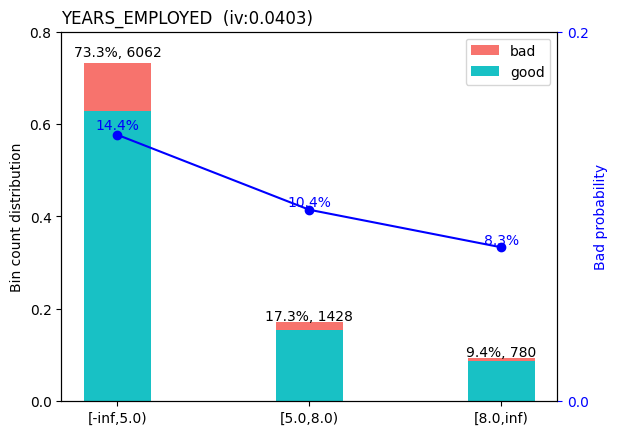

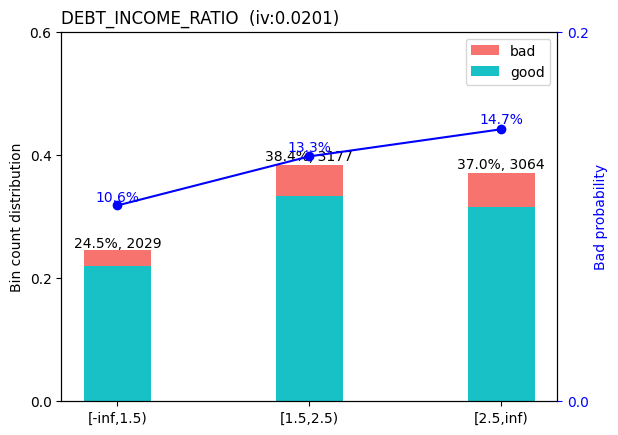

In [687]:
# # sample code

# bin adjustments for AVG_AMT_CREDIT_SUM_DEBT, DEBT_INCOME_RATIO, ACTIVE_CLOSE_DEBT_RATIO- reduce to 3 bins to make monotonic

########################## This is from when ACTIVE_CLOSE_DEBT_RATIO still existed
# breaks_adj = {'AVG_AMT_CREDIT_SUM_DEBT' : [40000, 90000],'DEBT_INCOME_RATIO' : [1.5,2.5],'ACTIVE_CLOSE_DEBT_RATIO':[0.5,1.1]}

breaks_adj = {'AVG_AMT_CREDIT_SUM_DEBT' : [40000, 90000],'DEBT_INCOME_RATIO' : [1.5,2.5]}

bins2 = sc.woebin(clean_merged_data, y='TARGET',breaks_list=breaks_adj)
sc.woebin_plot(bins2)

## 4. Create Scorecard

## 4.1 Logistic Regression with WOE encoding


In [688]:
train, test = sc.split_df(clean_merged_data, 'TARGET', ratio=0.7).values()
print(train.shape)
print(test.shape)

(5789, 14)
(2481, 14)


In [689]:
# prepare a dataset with the WOE values for Logistic Regression training
# woebin_ply() converts original values of input data into woe
train_woe = sc.woebin_ply(train,bins2)
test_woe = sc.woebin_ply(test,bins2)
train_woe

[INFO] converting into woe values ...
[INFO] converting into woe values ...


TARGET  EXT_SOURCE_2_woe  AVG_AMT_CREDIT_SUM_DEBT_woe  \
22           0             -0.22                         0.24   
35           0             -0.78                        -0.27   
53           0             -0.78                        -0.27   
77           0             -0.22                        -0.27   
168          0             -0.22                         0.14   
...        ...               ...                          ...   
307353       0              0.46                         0.14   
307383       1              0.46                         0.24   
307385       0             -0.22                         0.24   
307436       0             -0.78                        -0.27   
307457       0             -0.78                        -0.27   

        OCCUPATION_TYPE_woe  NAME_EDUCATION_TYPE_woe  \
22                    -0.05                     0.11   
35                    -0.05                    -0.56   
53                    -0.54                    -0.56   
77                     0.16                     0.11   
168                   -0.05                     0.11   
...                     ...                      ...   
307353                -0.01                     0.11   
307383                 0.16                     0.11   
307385                -0.05                     0.11   
307436                -0.05                     0.11   
307457                -0.05                     0.11   

        REGION_RATING_CLIENT_W_CITY_woe  EXT_SOURCE_1_woe  \
22                                -0.10              0.19   
35                                -0.10              0.19   
53                                -0.10             -0.14   
77                                -0.10              0.19   
168                               -0.10             -1.23   
...                                 ...               ...   
307353                            -0.10              0.19   
307383                             0.41              0.19   
307385                            -0.10             -0.14   
307436                            -0.10             -0.14   
307457                            -0.10              0.19   

        REGION_POPULATION_RELATIVE_woe  FLAG_DOCUMENT_3_woe  \
22                                0.08                 0.11   
35                                0.08                 0.11   
53                                0.08                 0.11   
77                               -0.36                 0.11   
168                               0.32                 0.11   
...                                ...                  ...   
307353                           -0.47                 0.11   
307383                            0.08                 0.11   
307385                            0.08                -0.32   
307436                            0.08                 0.11   
307457                           -0.47                -0.32   

        CLOSED_LOAN_RATIO_woe  ACTIVE_LOAN_RATIO_woe  EXT_SOURCE_3_woe  \
22                       0.28                   0.28              0.10   
35                      -0.40                  -0.38             -0.44   
53                      -0.40                  -0.38             -0.95   
77                      -0.40                  -0.38             -0.44   
168                      0.19                   0.19              0.08   
...                       ...                    ...               ...   
307353                   0.19                   0.19              0.08   
307383                  -0.12                  -0.12              0.78   
307385                   0.28                   0.28              0.08   
307436                  -0.40                  -0.38             -1.45   
307457                  -0.82                  -0.83             -0.44   

        YEARS_EMPLOYED_woe  DEBT_INCOME_RATIO_woe  
22                   -0.51                  -0.24  
35                    0.11                   0.13  
53                 

In [690]:
#create the X, y parts of data for train and test
y_train = train_woe.loc[:,'TARGET']
X_train = train_woe.loc[:,train_woe.columns != 'TARGET']
y_test = test_woe.loc[:,'TARGET']
X_test = test_woe.loc[:,train_woe.columns != 'TARGET']

#create a logistic regression model object
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(lr.coef_)
print(lr.intercept_)

[[ 0.6884058   0.32756236  0.73580032  0.52495793  0.28864411  0.72827267
   0.57338302  0.68030818  0.28817841 -0.01914354  0.91520114  0.4601741
   0.68973131]]
[-1.90297356]


## 4.2 Generate scorecard

In [691]:
card = sc.scorecard(bins,lr, X_train.columns, points0 = 600, odds0 = 1/50, pdo = 20,
      basepoints_eq0 = True)

## 5. Analysis and Tuning

## 5.1 Score all the test data and train data

Text(0.5, 1.0, 'test data scores')

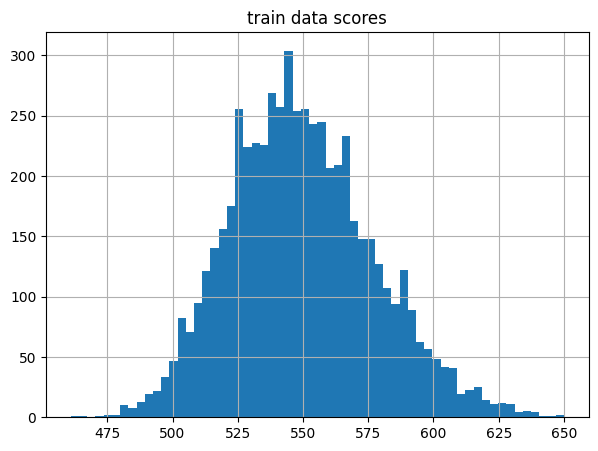

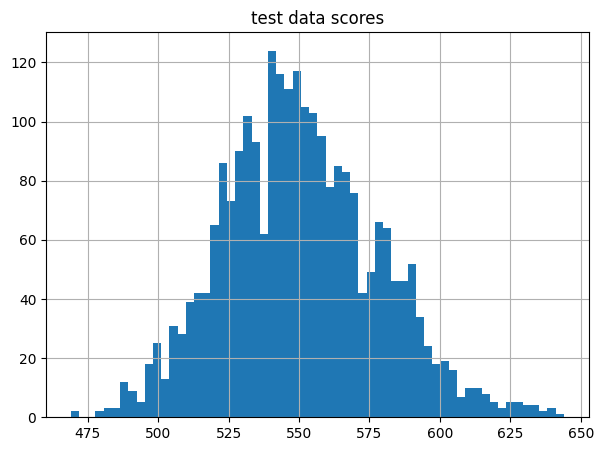

In [692]:
train_score = sc.scorecard_ply(train, card)
test_score = sc.scorecard_ply(test, card)

#distrubution of scores on test data
train_score.hist(figsize=(7,5),bins=60)
plt.title('train data scores')
test_score.hist(figsize=(7,5),bins=60)
plt.title('test data scores')

## 5.2 Percentage Correctly Classified measures on LR Model

In [693]:
y_pred = lr.predict(X_test)

print("Confusion matrix:")
print(confusion_matrix(y_pred, y_test))
print("\nPCC measures:")
print(classification_report(y_pred, y_test))

Confusion matrix:
[[2153  318]
 [   2    8]]

PCC measures:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      2471
           1       0.02      0.80      0.05        10

    accuracy                           0.87      2481
   macro avg       0.51      0.84      0.49      2481
weighted avg       1.00      0.87      0.93      2481



### 5.3 Evaluate perfomance of logistic regression model with ROC


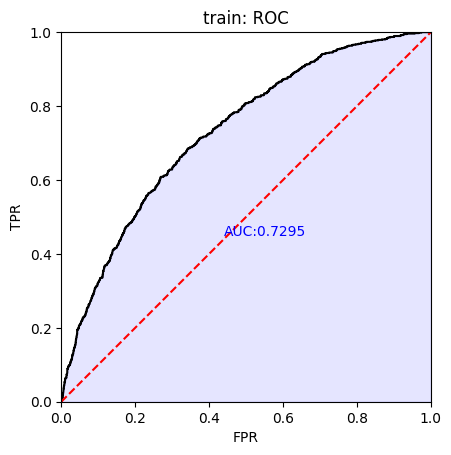

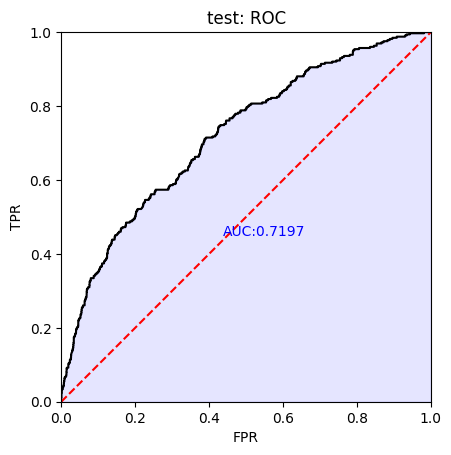

In [694]:
# evaluate the performance of the logistic regression
train_pred = lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]

# performance ks & roc
train_perf = sc.perf_eva(y_train, train_pred, plot_type=['roc'], title = "train")
test_perf = sc.perf_eva(y_test, test_pred, plot_type=['roc'], title = "test")

## 5.3 Tunning 

### Hyperparameter Tuning

In [695]:
from sklearn.metrics import get_scorer_names
fcustom_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)
scoring = {'AUC': 'roc_auc', 'F2': fcustom_scorer}
# parameter grid
parameters = {
    'penalty' : ['l1','l2','none', 'elasticnet'], 
    'C'       : [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
}

clf = RandomizedSearchCV(LogisticRegression(
                random_state=42, 
                class_weight='balanced'),      
                param_distributions = parameters,
                scoring=fcustom_scorer,
                cv=10,
                n_iter=100)

clf.fit(X_train, y_train)

print("Tuned Hyperparameters :", clf.best_params_)

Tuned Hyperparameters : {'solver': 'liblinear', 'penalty': 'l1', 'C': 1}


### Model Selection: Best Performance
#### Hyperparameter Tuning applied onto LR

In [696]:
tuned_lr = LogisticRegression(penalty=clf.best_params_['penalty'], C=clf.best_params_['C'], solver=clf.best_params_['solver'], class_weight='balanced', random_state=42)
tuned_lr.fit(X_train, y_train)

new_card = sc.scorecard(bins,lr, X_train.columns, points0 = 600, odds0 = 1/50, pdo = 20,
      basepoints_eq0 = True)

y_pred_tuned = tuned_lr.predict(X_test)

print("\n")
print(30*"*", "Logistic Regression" , 30*"*")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("\n")
print(30*"*", "Tuned Logistic Regression" , 30*"*")
print(confusion_matrix(y_test, y_pred_tuned))
print(classification_report(y_test, y_pred_tuned))



****************************** Logistic Regression ******************************
[[2153    2]
 [ 318    8]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      2155
           1       0.80      0.02      0.05       326

    accuracy                           0.87      2481
   macro avg       0.84      0.51      0.49      2481
weighted avg       0.86      0.87      0.81      2481



****************************** Tuned Logistic Regression ******************************
[[1395  760]
 [ 114  212]]
              precision    recall  f1-score   support

           0       0.92      0.65      0.76      2155
           1       0.22      0.65      0.33       326

    accuracy                           0.65      2481
   macro avg       0.57      0.65      0.54      2481
weighted avg       0.83      0.65      0.70      2481



### Score all Test and Train Data

Text(0.5, 1.0, 'new card test data scores')

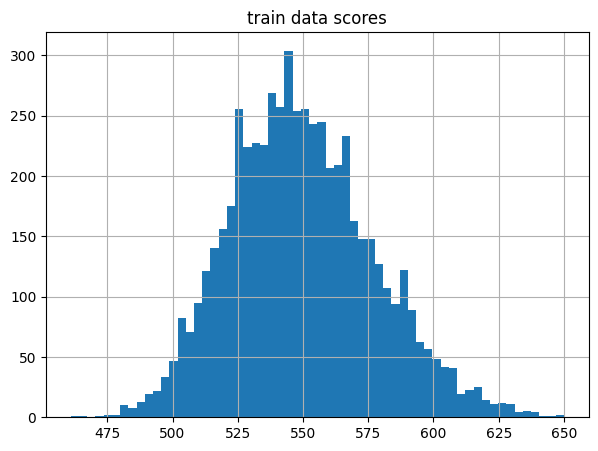

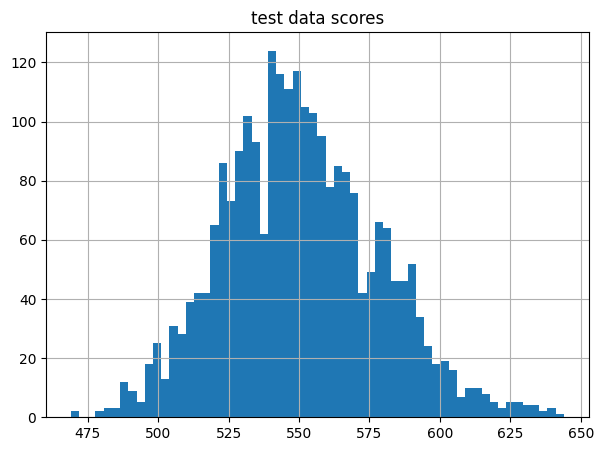

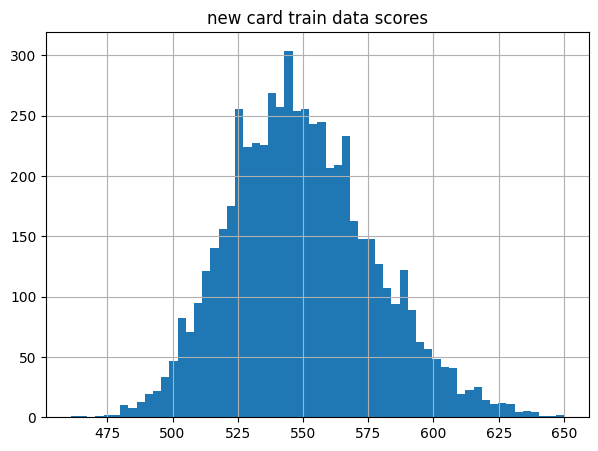

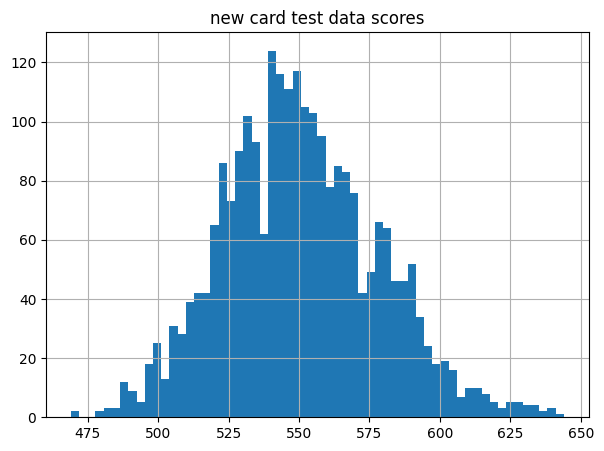

In [697]:
train_score = sc.scorecard_ply(train, card)
test_score = sc.scorecard_ply(test, card)

new_card_train_score = sc.scorecard_ply(train, new_card)
new_card_test_score = sc.scorecard_ply(test, new_card)

#distrubution of scores on test data
train_score.hist(figsize=(7,5),bins=60)
plt.title('train data scores')
test_score.hist(figsize=(7,5),bins=60)
plt.title('test data scores')

new_card_train_score.hist(figsize=(7,5),bins=60)
plt.title('new card train data scores')
new_card_test_score.hist(figsize=(7,5),bins=60)
plt.title('new card test data scores')

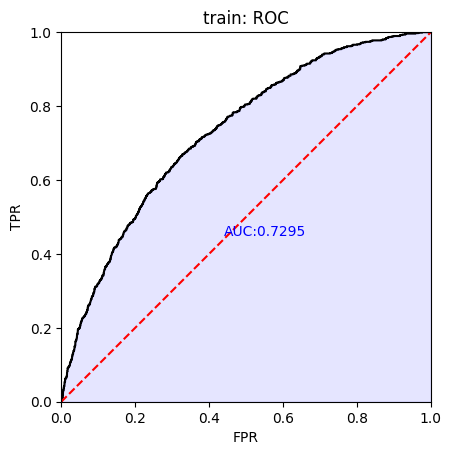

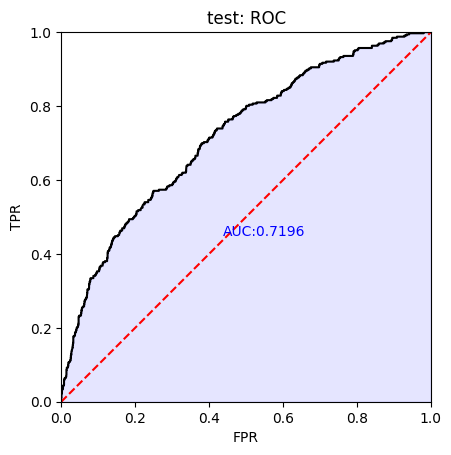

In [698]:
# evaluate the performance of the logistic regression
train_pred = tuned_lr.predict_proba(X_train)[:,1]
test_pred = tuned_lr.predict_proba(X_test)[:,1]

# performance ks & roc
train_perf = sc.perf_eva(y_train, train_pred, plot_type=['roc'], title = "train")
test_perf = sc.perf_eva(y_test, test_pred, plot_type=['roc'], title = "test")